## 三、素材和方法

為評估基於 Transformer 的模型於財經情感分類任務中的效能，本研究採用結構化實驗設計。方法涵蓋於領域資料集進行微調後，執行 zero-shot 與 few-shot 分類，以觀察模型在不同條件下的表現。比較對象如 Gemini、微調後的 BERT 及 FinBERT，並納入 SVM、隨機森林與羅吉斯回歸等傳統機器學習模型作為基準。

儘管目前已有如 LLaMA、Qwen 等開源大型語言模型，但本研究選擇採用 API 型 GPT 模型執行任務。開源模型雖具彈性與可控性，但有效應用通常需仰賴多張高效能 GPU 或 TPU，並投入大量時間與運算資源進行微調。相較之下，Gemini API 提供即時存取具先進語言理解能力的模型，擁有優化架構，並在 zero-shot 與 few-shot 任務中展現穩定效能。此選擇在資源與時間受限下，提供更具實用性與可擴展性的解決方案，同時維持財經情感分析中所需的高準確率與泛化能力。

本節說明本研究所採用之資料前處理流程、模型訓練程序、評估指標與實驗設計，藉以衡量各方法在分類準確率與運算效率上的表現。


## 3.1. 資料前處理階段

### 3.1.1. 資料集說明
本研究選用 Financial Sentiment Analysis 資料集，以推進財經情感分析領域之研究（Sbhatti, 2021）。該資料集整合自兩個具代表性來源：FiQA 與 Financial PhraseBank，合併為單一 CSV 檔，內含經標註之財經句子，並以 CC0 公眾授權方式公開於 Kaggle 平台與 Hugging Face。

其中，Financial PhraseBank 由 Malo 等人於 2014 年建立，為研究 “Good Debt or Bad Debt: Detecting Semantic Orientations in Economic Texts” 的一部分，發表於《Journal of the Association for Information Science and Technology》（Malo et al., 2014；Malo & Sinha, 2024）。此資料集為原創內容，非合成產出，情感標籤由 16 位標註者手動完成，平均配對一致率達 74.9%。

In [ ]:
!pip install datasets

In [ ]:
pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
import pandas as pd
from datasets import load_dataset
import ast


# 從 Hugging Face 平台導入數據
df_raw = load_dataset("mltrev23/financial-sentiment-analysis")
df_raw = pd.DataFrame(df_raw)

# 加入 id 欄（從 1 開始）
df_raw.insert(0, 'id', range(1, len(df_raw) + 1))

# 將 'train' 欄位中的字串型 dict 解析為真正的 dict，再轉為欄位
df_parsed = df_raw['train'].apply(lambda x: ast.literal_eval(str(x))).apply(pd.Series)

# 合併原始 id 與解析後的欄位
df = pd.concat([df_raw['id'], df_parsed], axis=1)

# 輸出檔案
df.to_excel('data.xlsx', index=False)

# 顯示結果
print(df.head())

README.md:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


archive.zip:   0%|          | 0.00/282k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5842 [00:00<?, ? examples/s]

   id                                           Sentence Sentiment
0   1  The GeoSolutions technology will leverage Bene...  positive
1   2  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2   3  For the last quarter of 2010 , Componenta 's n...  positive
3   4  According to the Finnish-Russian Chamber of Co...   neutral
4   5  The Swedish buyout firm has sold its remaining...   neutral


資料內容包含兩欄：「Sentence」紀錄財經文本，「Sentiment」標註情感類別（正面、負面或中性）。本研究選擇該資料集的原因在於其使用評價高（使用者評分為 10），且具備內容完整性與樣本多樣性。

In [ ]:
# 資料點總數
total_data_points = len(df)
print("==========Data Summary:==========")
print(f"Total number of data points: {total_data_points}")


# 句子長度
sentence_lengths = df['Sentence'].str.len()
max_sentence_length = sentence_lengths.max()
min_sentence_length = sentence_lengths.min()
avg_sentence_length = sentence_lengths.mean()
print(f"Max sentence length: {max_sentence_length}")
print(f"Min sentence length: {min_sentence_length}")
print(f"Average sentence length: {avg_sentence_length}")


# 情緒標籤計數
sentiment_counts = df['Sentiment'].value_counts()

negative_count = sentiment_counts.get('negative', 0)
positive_count = sentiment_counts.get('positive', 0)
neutral_count = sentiment_counts.get('neutral', 0)

print()
print("==========Sentiment label counts:==========")
print(f"Negative count: {negative_count}")
print(f"Positive count: {positive_count}")
print(f"Neutral count: {neutral_count}")

==========Data Summary:==========
Total number of data points: 5842
Max sentence length: 315
Min sentence length: 9
Average sentence length: 117.02225265320097

==========Sentiment label counts:==========
Negative count: 860
Positive count: 1852
Neutral count: 3130


在進行資料前處理前，先執行嚴謹的特徵工程，以深入瞭解資料內容。原始資料集共包含 5842 筆資料，欄位為「Sentence」與「Sentiment」。其中「Sentence」欄位的最大字元數為 315，最小為 9，平均為 117。情感標籤「Sentiment」共分為三類：neutral、positive 與 negative，分別佔 3130 筆、1852 筆與 860 筆。

儘管該資料集具高度研究價值，但情感分布不均，可能導致模型訓練時偏向多數類別，造成預測偏誤。為降低此風險，採用下採樣策略以平衡資料分布，確保模型學習效果更具代表性。

### 3.1.2. 資料集前處理

資料前處理階段採用結構化且可重複的流程，以確保資料品質與適用於預測模型的特性。整體流程涵蓋多項步驟，包括缺失值處理、文本標準化、分層抽樣，以及資料集劃分為訓練集、驗證集與測試集。

首先進行探索性資料分析，以檢視情感標籤的分布情形。此分析過程包含擷取情感類別及其對應頻率，以評估類別平衡程度。為此，呼叫專屬方法載入資料集並統計各情感標籤的數量。接著為維持資料完整性，進行缺失值處理。透過預先定義的函式，篩選並刪除「Sentence」與「Sentiment」等關鍵欄位中含有空值的資料列。該函式將資料載入為 Pandas DataFrame，檢測指定欄位的缺失情況，並移除對應資料。為確保處理流程可追溯，原始資料另存新檔名，清理後的版本另存為 CSV 檔。

In [ ]:
# Check for missing values in the DataFrame
print("\n==========Missing Value Check:==========")
print(df.isnull().sum())


==========Missing Value Check:==========
id           0
Sentence     0
Sentiment    0
dtype: int64


在完成資料清理後，進一步對文本資料進行標準化，以提升一致性與模型可解釋性。所採用的文本正規化方法包括轉換為小寫、移除特殊字元、停止詞與多餘空白，確保整體格式統一。與前述步驟相同，原始資料另存為新檔名，標準化後的版本則另存為 CSV 檔。

在敘述性統計分析時，觀察到正面情感明顯多於其他類別，導致分布失衡，而資料不平衡也會使模型傾向預測多數類別，進而降低對少數類別的判別效能。為解決標籤不平衡問題，本研究採用分層抽樣方法，此方法可確保資料集中各情感類別均有相同比例。為此，研究設計專屬函式對資料集進行劃分，從每個情感類別中選取相同數量的樣本，並依比例分配總筆數以維持平衡。該函式透過隨機抽樣方式，逐一從各類別中選取樣本，直到達到指定總量。最後將結果資料集打亂，以避免順序錯誤，並另存為新的 CSV 檔。

同時需考量，不同機器學習演算法對標籤格式的處理需求不同，有些可直接處理字串型標籤，有些則須進行數值編碼。在本研究中，SVM 與 BERT 模型需進行數值標籤轉換，而大型語言模型（LLMs）則可直接處理類別型字串標籤。對於低維度資料集，數值編碼為實用選擇；高維度資料則較適合使用 one-hot 編碼。
本研究採用數值編碼方式，將情感標籤轉換為數值：negative 為 0、positive 為 1、neutral 為 2，並新增一欄於測試集資料中，作為後續模型評估之用。

In [ ]:
import spacy
import re
from collections import Counter

# 載入 spaCy 英文模型
nlp = spacy.load('en_core_web_sm')

# 取出 Sentence 欄並轉換為字串清單
text_data = df['Sentence'].astype(str).tolist()

# 文本正規化函數
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 正規化每一句
normalized_sentences = [normalize_text(sentence) for sentence in text_data]

# 建立新的資料欄，保留所有詞彙
df_final = df.copy()
df_final['Cleaned_Sentence'] = normalized_sentences

# 建立 label-to-index 映射
sentiment_map = {'negative': 0, 'positive': 1, 'neutral': 2}
df_final['Sentiment_Label'] = df_final['Sentiment'].map(sentiment_map)

# 匯出最終結果
output_path = "/content/cleaned_data_raw.xlsx"
df_final.to_excel(output_path, index=False)

# 顯示前幾列
df_final.head()

id                                           Sentence Sentiment  \
0   1  The GeoSolutions technology will leverage Bene...  positive   
1   2  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative   
2   3  For the last quarter of 2010 , Componenta 's n...  positive   
3   4  According to the Finnish-Russian Chamber of Co...   neutral   
4   5  The Swedish buyout firm has sold its remaining...   neutral   

                                    Cleaned_Sentence  Sentiment_Label  
0  the geosolutions technology will leverage bene...                1  
1  esi on lows down 150 to 250 bk a real possibility                0  
2  for the last quarter of 2010 componenta s net ...                1  
3  according to the finnishrussian chamber of com...                2  
4  the swedish buyout firm has sold its remaining...                2

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# 重新載入資料，假設前一步中 df_final 已建立
# 檢查情感類別分布
label_counts = df_final['Sentiment'].value_counts()

# 設定分層抽樣後的總樣本數（每類最小樣本數 * 類別數）
min_class_count = label_counts.min()
sample_per_class = min_class_count
total_sample = sample_per_class * len(label_counts)

# 分層抽樣函數
def stratified_sample(df, label_col, n_samples_per_class, random_state=42):
    sampled_dfs = []
    for label in df[label_col].unique():
        class_subset = df[df[label_col] == label]
        sampled_subset = class_subset.sample(n=n_samples_per_class, random_state=random_state)
        sampled_dfs.append(sampled_subset)
    result_df = pd.concat(sampled_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return result_df

# 執行分層抽樣
df_sampled = stratified_sample(df_final, label_col='Sentiment', n_samples_per_class=sample_per_class)

# 儲存分層抽樣後的總資料
df_sampled.to_csv("/content/stratified_sampled_full.csv", index=False)

# 切分為 test (20%) 與剩餘資料 (80%)
df_train_val, df_test = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled['Sentiment'], random_state=42)

# 再切分為 train 與 validation (驗證集為剩下的 25%，即整體的 20%)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, stratify=df_train_val['Sentiment'], random_state=42)

# 儲存三組資料
df_train.to_csv("/content/train_set.csv", index=False)
df_val.to_csv("/content/validation_set.csv", index=False)
df_test.to_csv("/content/test_set.csv", index=False)

# 檢查各資料集情感分布
{
    "train_counts": df_train['Sentiment'].value_counts().to_dict(),
    "validation_counts": df_val['Sentiment'].value_counts().to_dict(),
    "test_counts": df_test['Sentiment'].value_counts().to_dict()
}

{'train_counts': {'neutral': 516, 'negative': 516, 'positive': 516},
 'validation_counts': {'neutral': 172, 'negative': 172, 'positive': 172},
 'test_counts': {'neutral': 172, 'positive': 172, 'negative': 172}}

完成分層抽樣後，將資料集依原始情感分布劃分為訓練集、驗證集與測試集。首先，將 20% 資料分配至測試集，其餘資料再進一步劃分為訓練集與驗證集，並透過分層抽樣確保三個子集情感標籤皆平衡分布。最終將三組資料分別儲存為 train_set.csv、validation_set.csv 與 test_set.csv，以供後續模型訓練使用。最終分布結果為：測試集 516 筆、驗證集 516 筆、訓練集 1548 筆，各情感類別在三者中皆均勻分配。

In [ ]:
!pip install optuna
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.6 MB/s eta 0:00:00


In [ ]:
import os
import time
import logging
import traceback

# Attempt to import necessary packages, install if missing (for Colab)
try:
    import optuna
except ImportError:
    print("Installing optuna...")
    !pip install -q optuna
    import optuna

try:
    import joblib
except ImportError:
    print("Installing joblib...")
    !pip install -q joblib
    import joblib

import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, hinge_loss, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from google.colab import drive

# 儲存三組資料
train_set_path = "train_set.csv"
validation_set_path = "validation_set.csv"
test_set_path = "test_set.csv"

Installing optuna...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.9 MB/s eta 0:00:00


## 3.2. 微調與情感分析階段

完成資料準備後，即進入預測模型訓練與微調階段。首先評估傳統機器學習演算法的效能，包括 SVM、隨機森林與羅吉斯回歸，並搭配廣泛的超參數調整。同樣地，對預訓練的 BERT 與 FinBERT 模型亦進行超參數微調，採用多種最佳化技術。此外，也針對 Gemini 進行微調。

起初，本研究考慮採用網格搜尋法以尋找各模型的最佳超參數。然而，網格搜尋需對所有可能組合進行全面訓練，易導致組合爆炸，特別是在同時處理多個 Transformer 模型與傳統演算法時更為明顯。為克服此限制，改採機率式方法進行超參數調整，即貝式最佳化。

本研究運用 Optuna 函式庫，針對每個模型執行 100 次試驗，廣泛搜尋超參數組合。為提升訓練效率並避免過擬合，整合 early stopping 與 pruning 技術，當模型在指定輪數內無效能提升時即停止訓練。經貝式最佳化後，根據驗證集準確率選出表現最佳之模型，並用於相同測試集進行預測。

### 3.2.1. SVM 情感分類與超參數最佳化

如前言所述，SVM 廣泛應用於分類任務，需進行大量特徵工程、結合領域知識並細緻調整超參數，才能達到最佳效能。本研究採用 Optuna 框架進行貝式最佳化，以微調 SVM 模型用於財經情感分類。整體流程於 Google Colab 平台上執行，並使用單一 CPU 完成。

本研究針對 TF-IDF 向量化與 SVM 分類器進行全面性超參數搜尋，以提升整體分類效能。TF-IDF 部分，max_features 設定為 5,000、10,000、15,000 或不設限；ngram_range 選擇 unigram、bigram 或 trigram（即 (1,1)、(1,2)、(1,3)）；stop_words 參數則在 None 與 “english” 間切換。 SVM 分類器方面，針對多項關鍵超參數進行調整：正則化參數 C 採對數尺度於 0.01 至 100.0 間取樣；kernel 選項包括 ‘linear’、‘rbf’ 與 ‘poly’；class_weight 可選擇設定為 “balanced”，以處理類別不平衡問題。針對非線性核函數，亦調整 gamma 參數，設定為 ‘scale’ 或 ‘auto’。

每次最佳化試驗皆建立一組結合 TF-IDF 與 SVM 的流程，於訓練集上訓練後，使用準確率與 hinge loss 於驗證集上進行評估。所有試驗結果均被紀錄，以利效能追蹤與最佳組合辨識。整體方法核心在於針對財經情感分類任務優化 SVM 分類器，並透過 Optuna 框架執行 100 次貝式最佳化，以確保模型達到最佳效能。

In [ ]:
# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Global variables to be used across functions
# These will be populated by run_svm_optimization
absolute_path = None
X_train = y_train = X_val = y_val = X_test = y_test = None

# Function: Create and evaluate model
def create_and_evaluate_model(params, current_X_train, current_y_train, current_X_val, current_y_val):
    try:
        tfidf = TfidfVectorizer(
            max_features=params['max_features'],
            ngram_range=params['ngram_range'],
            stop_words=params['stop_words']
        )

        svm_params = {
            'C': params['C'],
            'kernel': params['kernel'],
            'probability': True, # Keep True if you need predict_proba later
            'decision_function_shape': 'ovr',
            'class_weight': params.get('class_weight', None)
        }
        if params['kernel'] in ['rbf', 'poly', 'sigmoid']: # 'sigmoid' also uses gamma
            svm_params['gamma'] = params.get('gamma', 'scale')

        svm = SVC(**svm_params)

        pipeline = Pipeline([
            ("tfidf", tfidf),
            ("svm", svm)
        ])

        pipeline.fit(current_X_train, current_y_train)

        y_val_pred = pipeline.predict(current_X_val)
        accuracy = accuracy_score(current_y_val, y_val_pred)

        val_decision_scores = pipeline.decision_function(current_X_val)
        # For multi-class 'ovr', hinge_loss can take original labels and decision scores
        # It calculates an average hinge loss over all classes.
        # SVM's classes_ attribute provides the order of classes in decision_function output.
        val_loss = hinge_loss(current_y_val, val_decision_scores, labels=pipeline.named_steps['svm'].classes_)

        return pipeline, accuracy, val_loss

    except Exception as e:
        logger.error(f"Error in model creation/evaluation: {str(e)}")
        logger.error(traceback.format_exc())
        return None, 0.0, float('inf')

# Objective function for Optuna
def objective(trial):
    # Access global variables populated by run_svm_optimization
    global absolute_path, X_train, y_train, X_val, y_val

    # Check if data is loaded
    if X_train is None or y_train is None or X_val is None or y_val is None:
        logger.error("Training/validation data not loaded. Skipping trial.")
        # Returning a very low accuracy will make Optuna avoid such states
        # if this somehow happens, though data should be loaded before study.optimize.
        return 0.0


    params = {
        'max_features': trial.suggest_categorical('max_features', [5000, 10000, 15000, None]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'stop_words': trial.suggest_categorical('stop_words', [None, 'english']),
        'C': trial.suggest_float('C', 0.01, 100.0, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid']), # Added sigmoid
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
    }

    if params['kernel'] in ['rbf', 'poly', 'sigmoid']: # Added sigmoid
        params['gamma'] = trial.suggest_categorical('gamma', ['scale', 'auto'])
    # For linear kernel, gamma is not used.
    # We can remove it from params if kernel is linear to avoid SVC warnings, though it's ignored.
    elif 'gamma' in params:
        del params['gamma']


    logger.info(f"Trial {trial.number} hyperparameters: {params}")

    model, accuracy, val_loss = create_and_evaluate_model(params, X_train, y_train, X_val, y_val)

    if absolute_path: # Ensure absolute_path is set
        trial_results_path = os.path.join(absolute_path, 'OptimizationResults', 'svm_all_trials.txt')
        os.makedirs(os.path.dirname(trial_results_path), exist_ok=True)

        with open(trial_results_path, 'a') as f:
            f.write(f"\n----- Trial {trial.number} -----\n")
            f.write(f"Validation Accuracy: {accuracy:.4f}\n")
            f.write(f"Validation Loss: {val_loss:.4f}\n")
            for key, value in params.items():
                f.write(f"{key}: {value}\n")
            f.write("--------------------------\n")

    if model is None: # If model creation failed
        return 0.0 # Optuna tries to maximize accuracy, so return a low value

    return accuracy

# Function to run the full Optuna optimization
def run_svm_optimization(n_trials=100, timeout=None):
    global X_train, y_train, X_val, y_val, X_test, y_test, absolute_path

    start_time = time.time()
    logger.info(f"Starting SVM optimization with {n_trials} trials, timeout={timeout}")

    try:
        drive.mount('/content/gdrive', force_remount=True)
        logger.info("Google Drive mounted successfully")
    except Exception as e:
        logger.error(f"Error mounting Google Drive: {str(e)}")
        return None, None # Return None for study and params if drive mount fails

    absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/" # Set global path
    dataset_path = os.path.join(absolute_path, "Datasets/")
    results_dir = os.path.join(absolute_path, 'OptimizationResults')
    os.makedirs(results_dir, exist_ok=True)

    all_trials_path = os.path.join(results_dir, 'svm_all_trials.txt')
    with open(all_trials_path, 'w') as f: # Overwrite or create file for new optimization run
        f.write("========== SVM HYPERPARAMETER OPTIMIZATION RESULTS ==========\n")
        f.write(f"Started: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Number of trials: {n_trials}\n")
        f.write("=============================================================\n")

    logger.info("Loading datasets")
    try:
        train_df = pd.read_csv(os.path.join(dataset_path, "train_set.csv"))
        val_df = pd.read_csv(os.path.join(dataset_path, "validation_set.csv"))
        test_df = pd.read_csv(os.path.join(dataset_path, "test_set.csv"))
    except FileNotFoundError as e:
        logger.error(f"Dataset file not found: {e}")
        return None, None # Return None if datasets can't be loaded

    X_train, y_train = train_df["Sentence"], train_df["Sentiment_Label"]
    X_val, y_val = val_df["Sentence"], val_df["Sentiment_Label"]
    X_test, y_test = test_df["Sentence"], test_df["Sentiment_Label"]

    logger.info(f"Train set size: {len(X_train)}")
    logger.info(f"Validation set size: {len(X_val)}")
    logger.info(f"Test set size: {len(X_test)}")

    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0, interval_steps=1)
    )

    try:
        study.optimize(objective, n_trials=n_trials, timeout=timeout)
    except KeyboardInterrupt:
        logger.info("Optimization stopped by user")
    except Exception as e:
        logger.error(f"Error during optimization: {str(e)}")
        logger.error(traceback.format_exc())

    end_time = time.time()
    optimization_duration = (end_time - start_time) / 60

    with open(all_trials_path, 'a') as f:
        f.write("\n========== OPTIMIZATION SUMMARY ==========\n")
        f.write(f"Completed: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total optimization time: {optimization_duration:.2f} minutes\n")
        f.write(f"Number of trials run: {len(study.trials)}\n")
        f.write(f"Number of completed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}\n")
        f.write("=========================================\n")

    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.warning("No successful trials completed.")
        return study, None # Return study for potential later inspection, but no best_params

    best_trial = study.best_trial
    logger.info(f"Best trial value (accuracy): {best_trial.value:.4f}")
    logger.info("Best hyperparameters:")
    for k, v in best_trial.params.items():
        logger.info(f"  {k}: {v}")

    best_model_results_path = os.path.join(results_dir, 'svm_best_model_results.txt')
    with open(best_model_results_path, 'w') as f: # Overwrite or create
        f.write("========== SVM BEST MODEL RESULTS ==========\n")
        f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"Best Trial Number: {best_trial.number}\n")
        f.write(f"Best Validation Accuracy: {best_trial.value:.4f}\n\n")
        f.write("Hyperparameters:\n--------------\n")
        for k, v in best_trial.params.items():
            f.write(f"  {k}: {v}\n")
        f.write("\n")

        worst_trial = min(completed_trials, key=lambda t: t.value)
        avg_accuracy = sum(t.value for t in completed_trials) / len(completed_trials)
        f.write("Performance Analysis:\n--------------\n")
        f.write(f"Worst trial accuracy: {worst_trial.value:.4f} (Trial {worst_trial.number})\n")
        if worst_trial.value > 0: # Avoid division by zero
            f.write(f"Improvement over worst: {(best_trial.value - worst_trial.value):.4f} ({(best_trial.value / worst_trial.value - 1) * 100:.2f}%)\n")
        if avg_accuracy > 0: # Avoid division by zero
            f.write(f"Average trial accuracy: {avg_accuracy:.4f}\n")
            f.write(f"Improvement over average: {(best_trial.value - avg_accuracy):.4f} ({(best_trial.value / avg_accuracy - 1) * 100:.2f}%)\n\n")

        try:
            importance = optuna.importance.get_param_importances(study)
            f.write("Parameter Importance:\n--------------\n")
            for param, score in importance.items():
                f.write(f"  {param}: {score:.4f}\n")
        except Exception as e:
            f.write(f"Could not calculate parameter importance: {str(e)}\n")
        f.write("\n========== END OF REPORT (Optimization Phase) ==========\n")

    return study, best_trial.params # Return the study object and best params

# Train and evaluate the final model
def train_final_svm_model(best_params):
    global absolute_path, X_train, y_train, X_val, y_val, X_test, y_test # Ensure globals are accessible

    if not all([X_train is not None, y_train is not None, X_val is not None, y_val is not None, X_test is not None, y_test is not None, absolute_path is not None]):
        logger.error("Global data or path not set. Cannot train final model.")
        return

    logger.info("Training final SVM model with best hyperparameters on combined train+validation data")

    # Combine train and validation for final model training
    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])

    # Note: We are evaluating on the test set.
    # The create_and_evaluate_model was designed for validation during HPO.
    # For final model, we train on train+val and evaluate on test.
    # Let's adapt or reuse create_and_evaluate_model carefully.
    # Here, we'll just create and fit the model, then evaluate on test.

    tfidf = TfidfVectorizer(
        max_features=best_params['max_features'],
        ngram_range=best_params['ngram_range'],
        stop_words=best_params['stop_words']
    )

    svm_final_params = {
        'C': best_params['C'],
        'kernel': best_params['kernel'],
        'probability': True,
        'decision_function_shape': 'ovr',
        'class_weight': best_params.get('class_weight', None)
    }
    if best_params['kernel'] in ['rbf', 'poly', 'sigmoid']:
        svm_final_params['gamma'] = best_params.get('gamma', 'scale')

    final_svm = SVC(**svm_final_params)

    final_model_pipeline = Pipeline([
        ("tfidf", tfidf),
        ("svm", final_svm)
    ])

    logger.info("Fitting final model on X_train_full and y_train_full...")
    final_model_pipeline.fit(X_train_full, y_train_full)
    logger.info("Final model fitting complete.")

    # Evaluate on Test Set
    logger.info("Evaluating final model on Test Set...")
    y_test_pred = final_model_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)

    try:
        test_decision_scores = final_model_pipeline.decision_function(X_test)
        test_loss = hinge_loss(y_test, test_decision_scores, labels=final_model_pipeline.named_steps['svm'].classes_)
        logger.info(f"Final model test loss: {test_loss:.4f}")
    except Exception as e:
        logger.warning(f"Could not calculate test hinge loss: {e}")
        test_loss = "N/A"


    logger.info(f"Final model test accuracy: {test_accuracy:.4f}")
    logger.info(f"Test Set Classification Report:\n{test_report}")

    best_model_results_path = os.path.join(absolute_path, 'OptimizationResults', 'svm_best_model_results.txt')
    with open(best_model_results_path, 'a') as f: # Append to existing report
        f.write("\n\n========== FINAL MODEL EVALUATION (ON TEST SET) ==========\n")
        f.write(f"Trained on combined Train + Validation data.\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        if isinstance(test_loss, float):
            f.write(f"Test Hinge Loss: {test_loss:.4f}\n")
        else:
            f.write(f"Test Hinge Loss: {test_loss}\n")

        f.write("Test Set Classification Report:\n")
        f.write(test_report)

    logger.info("Evaluating prediction time on test set")
    svm_predictions_on_test = []
    prediction_times_on_test = []

    for sentence in X_test:
        start_p_time = time.time()
        prediction = final_model_pipeline.predict([sentence])[0]
        end_p_time = time.time()
        elapsed_time = end_p_time - start_p_time
        svm_predictions_on_test.append(prediction)
        prediction_times_on_test.append(elapsed_time)

    avg_prediction_time = sum(prediction_times_on_test) / len(prediction_times_on_test) if prediction_times_on_test else 0
    logger.info(f"Average prediction time per sample on test set: {avg_prediction_time:.6f} seconds")

    # Save test set with predictions
    dataset_path = os.path.join(absolute_path, "Datasets/")
    try:
        test_df_copy = pd.read_csv(os.path.join(dataset_path, "test_set.csv"))
        test_df_copy["svm_predictions"] = svm_predictions_on_test
        test_df_copy["time_svm"] = prediction_times_on_test
        output_path = os.path.join(dataset_path, "test_set_with_svm_predictions.csv")
        test_df_copy.to_csv(output_path, index=False)
        logger.info(f"Test set with predictions saved to {output_path}")
    except Exception as e:
        logger.error(f"Error saving test set with predictions: {e}")


    with open(best_model_results_path, 'a') as f:
        f.write(f"\nAverage prediction time (test set): {avg_prediction_time:.6f} seconds\n")

    # Save the final model
    try:
        model_save_dir = os.path.join(absolute_path, 'TrainedModels')
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, 'svm_optimized_model.joblib')
        joblib.dump(final_model_pipeline, model_save_path)
        logger.info(f"Final trained model saved to {model_save_path}")
        with open(best_model_results_path, 'a') as f:
            f.write(f"\nFinal model saved to: {model_save_path}\n")
            f.write("========== END OF FINAL EVALUATION REPORT ==========\n")
    except Exception as e:
        logger.error(f"Error saving final model: {str(e)}")
        logger.error(traceback.format_exc())


# Visualization function
def visualize_optuna_study(study):
    if study is None:
        logger.warning("Study object is None. Cannot generate visualizations.")
        return

    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.warning("No completed trials in the study to visualize.")
        return

    if len(completed_trials) < 2 and any(plot_name in ['plot_param_importances', 'plot_slice'] for plot_name in ['plot_param_importances', 'plot_slice', 'plot_parallel_coordinate']):
        logger.warning("Not enough completed trials for some visualizations (e.g., param importances, slice). Skipping them.")

    logger.info("Generating Optuna visualization plots...")
    # Plotting functions might raise errors if conditions aren't met (e.g., not enough trials for importances)
    try:
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
    except Exception as e:
        logger.error(f"Failed to generate optimization history plot: {e}")

    if len(completed_trials) >= 2: # Param importances usually need multiple trials
        try:
            fig2 = optuna.visualization.plot_param_importances(study)
            fig2.show()
        except Exception as e: # Catches specific errors like "ValueError: Cannot evaluate..." if only 1 trial made it despite check
            logger.error(f"Failed to generate param importances plot: {e}")

    try:
        fig3 = optuna.visualization.plot_parallel_coordinate(study)
        fig3.show()
    except Exception as e:
        logger.error(f"Failed to generate parallel coordinate plot: {e}")

    if len(completed_trials) >=1: # Slice plot can work with one trial for some params
        try:
            fig4 = optuna.visualization.plot_slice(study)
            fig4.show()
        except Exception as e:
            logger.error(f"Failed to generate slice plot: {e}")


# Main execution
if __name__ == "__main__":
    logger.info("========== STARTING SVM HYPERPARAMETER OPTIMIZATION SCRIPT ==========")

    # Store the returned study object from run_svm_optimization
    # And the best hyperparameters
    study_object, best_hyperparams = run_svm_optimization(n_trials=100, timeout=None)

    if best_hyperparams and study_object:
        logger.info("Optimization finished. Proceeding to train final model with best parameters.")
        train_final_svm_model(best_hyperparams)
        logger.info("Final model training and evaluation complete. Visualizing study.")
        visualize_optuna_study(study_object) # Pass the original study object
    elif study_object: # Optimization ran but found no best params (e.g. all trials failed)
        logger.warning("Optimization ran, but no best parameters were found. Visualizing study anyway.")
        visualize_optuna_study(study_object)
    else:
        logger.error("SVM optimization did not run successfully or was aborted. No best parameters found.")

    logger.info("========== SVM HYPERPARAMETER OPTIMIZATION SCRIPT COMPLETED ==========")

[I 2025-05-14 10:08:16,048] A new study created in memory with name: no-name-dd78af3c-2a9f-4f61-ac9b-af065b8e3600


Mounted at /content/gdrive


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.

[I 2025-05-14 10:08:19,082] Trial 0 finished with value: 0.4728682170542636 and parameters: {'max_features': 5000, 'ngram_range': (1, 3), 'stop_words': 'english', 'C': 89.93337843035721, 'kernel': 'rbf', 'class_weight': 'balanced', 'gamma': 'auto'}. Best is trial 0 with val

In [ ]:
import logging
import os
import time
import pandas as pd
import traceback
import joblib # For saving the model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, hinge_loss
import matplotlib.pyplot as plt
import numpy as np # Often useful, and ConfusionMatrixDisplay might use it internally

# Attempt to import google.colab.drive for Colab environment
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Global variables for data - will be populated by load_data
absolute_path = None
X_train = y_train = X_val = y_val = X_test = y_test = None

# Hardcoded best parameters
BEST_SVM_PARAMS = {
    'max_features': None,
    'ngram_range': (1, 2),
    'stop_words': None,
    'C': 1.255465851533207,
    'kernel': 'sigmoid',
    'class_weight': 'balanced',
    'gamma': 'scale'
}

def load_datasets():
    global absolute_path, X_train, y_train, X_val, y_val, X_test, y_test

    if IN_COLAB:
        try:
            drive.mount('/content/gdrive', force_remount=True)
            logger.info("Google Drive mounted successfully")
            absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/"
        except Exception as e:
            logger.error(f"Error mounting Google Drive: {str(e)}")
            return False
    else:
        # Define a local path if not in Colab
        # You'll need to adjust this to your local directory structure
        # For example:
        # script_dir = os.path.dirname(os.path.abspath(__file__))
        # absolute_path = os.path.join(script_dir, "Financial-Sentiment-Data") # Assuming data is in a subdir
        absolute_path = "./Financial-Sentiment-Data/" # Example: current dir + subdir
        logger.info(f"Running locally. Using path: {absolute_path}")
        # Ensure this local path has the "Datasets" and "TrainedModels", "Results" subdirectories

    dataset_path = os.path.join(absolute_path, "Datasets/")
    results_dir = os.path.join(absolute_path, 'Results_ConfusionMatrix') # New dir for this script's results
    os.makedirs(results_dir, exist_ok=True)


    logger.info("Loading datasets...")
    try:
        train_df = pd.read_csv(os.path.join(dataset_path, "train_set.csv"))
        val_df = pd.read_csv(os.path.join(dataset_path, "validation_set.csv"))
        test_df = pd.read_csv(os.path.join(dataset_path, "test_set.csv"))
    except FileNotFoundError as e:
        logger.error(f"Dataset file not found: {e}. Please check the path: {dataset_path}")
        return False

    X_train, y_train = train_df["Sentence"], train_df["Sentiment_Label"]
    X_val, y_val = val_df["Sentence"], val_df["Sentiment_Label"]
    X_test, y_test = test_df["Sentence"], test_df["Sentiment_Label"]

    # 在這幾行之後，添加以下程式碼來進行標籤映射：
    label_map = {
        0: 'negative',
        1: 'neutral',
        2: 'positive'
    }
    logger.info(f"Original y_train unique values before mapping: {y_train.unique()}")

    # 確保 y_train, y_val, y_test 是 pandas Series 以使用 .map()
    # 如果它們已經是正確的字串標籤，這個映射可能不需要或會出錯
    try:
        y_train_mapped = y_train.map(label_map)
        y_val_mapped = y_val.map(label_map)
        y_test_mapped = y_test.map(label_map)

        # 檢查映射後是否有 NaN (如果原始值不在 label_map 的鍵中)
        if y_train_mapped.isnull().any() or y_val_mapped.isnull().any() or y_test_mapped.isnull().any():
            logger.warning("NaN values found in labels after mapping. This might happen if original labels are not 0, 1, 2 or are already strings. Original y_train head: %s", y_train.head())
            # 如果原始標籤可能不是0,1,2或已是字串，這裡可以決定是否保留原始值
            # 例如: y_train = y_train_mapped.fillna(y_train) # 保留未成功映射的原始值
            # 但這裡我們先假設映射是期望的行為
            y_train = y_train_mapped
            y_val = y_val_mapped
            y_test = y_test_mapped
        else:
            y_train = y_train_mapped
            y_val = y_val_mapped
            y_test = y_test_mapped
            logger.info("Labels successfully mapped to 'negative', 'neutral', 'positive'.")
            logger.info(f"Mapped y_train unique values: {y_train.unique()}")

    except AttributeError:
        logger.warning("Labels might not be pandas Series or .map() failed. Skipping label mapping. Ensure labels are already in the desired format ('negative', 'neutral', 'positive') or adjust mapping logic.")
    except Exception as e:
        logger.error(f"Error during label mapping: {e}")
        # 根據您的需求，這裡可能需要 return False 或引發錯誤
        return False # 例如，表示資料載入失敗

    logger.info(f"Train set size: {len(X_train)}")
    logger.info(f"Validation set size: {len(X_val)}")
    logger.info(f"Test set size: {len(X_test)}")
    return True

def train_evaluate_and_generate_cm(params):
    global absolute_path, X_train, y_train, X_val, y_val, X_test, y_test

    if not all([X_train is not None, y_train is not None, X_val is not None, y_val is not None, X_test is not None, y_test is not None, absolute_path is not None]):
        logger.error("Global data or path not set. Cannot train model. Ensure load_datasets() was successful.")
        return

    logger.info("Training final SVM model with best hyperparameters on combined train+validation data")

    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])

    tfidf = TfidfVectorizer(
        max_features=params['max_features'],
        ngram_range=params['ngram_range'],
        stop_words=params['stop_words']
    )

    svm_final_params = {
        'C': params['C'],
        'kernel': params['kernel'],
        'probability': True, # Keep True if you need predict_proba
        'decision_function_shape': 'ovr',
        'class_weight': params.get('class_weight', None)
    }
    if params['kernel'] in ['rbf', 'poly', 'sigmoid']:
        svm_final_params['gamma'] = params.get('gamma', 'scale')

    final_svm = SVC(**svm_final_params)

    final_model_pipeline = Pipeline([
        ("tfidf", tfidf),
        ("svm", final_svm)
    ])

    logger.info("Fitting final model on X_train_full and y_train_full...")
    start_fit_time = time.time()
    final_model_pipeline.fit(X_train_full, y_train_full)
    end_fit_time = time.time()
    logger.info(f"Final model fitting complete. Time taken: {end_fit_time - start_fit_time:.2f} seconds.")

    # Evaluate on Test Set
    logger.info("Evaluating final model on Test Set...")
    y_test_pred = final_model_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred, target_names=final_model_pipeline.named_steps['svm'].classes_.astype(str)) # Use model's classes

    test_loss = "N/A"
    try:
        test_decision_scores = final_model_pipeline.decision_function(X_test)
        # Ensure y_test labels are compatible with decision_function output for hinge_loss
        # This might require mapping y_test to the order of model.classes_ if they are not already aligned.
        # For simplicity, if labels are strings like 'positive', 'negative', 'neutral' and SVM uses 0,1,2,
        # you might need LabelEncoder. However, SVM often handles string labels directly.
        # Assuming y_test and model classes are compatible.
        test_loss = hinge_loss(y_test, test_decision_scores, labels=final_model_pipeline.named_steps['svm'].classes_)
        logger.info(f"Final model test hinge loss: {test_loss:.4f}")
    except Exception as e:
        logger.warning(f"Could not calculate test hinge loss: {e}")
        logger.debug(traceback.format_exc())


    logger.info(f"Final model test accuracy: {test_accuracy:.4f}")
    logger.info(f"Test Set Classification Report:\n{test_report}")

    # Generate and Save Confusion Matrix
    results_dir = os.path.join(absolute_path, 'Results_ConfusionMatrix')
    os.makedirs(results_dir, exist_ok=True)

    cm_report_path = os.path.join(results_dir, 'svm_test_results_and_cm.txt')
    with open(cm_report_path, 'w') as f:
        f.write("========== SVM FINAL MODEL EVALUATION (ON TEST SET) ==========\n")
        f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("Hyperparameters Used:\n--------------\n")
        for k, v in params.items():
            f.write(f"  {k}: {v}\n")
        f.write("\n")
        f.write(f"Trained on combined Train + Validation data ({len(X_train_full)} samples).\n")
        f.write(f"Evaluated on Test data ({len(X_test)} samples).\n\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        if isinstance(test_loss, float):
            f.write(f"Test Hinge Loss: {test_loss:.4f}\n")
        else:
            f.write(f"Test Hinge Loss: {test_loss}\n")
        f.write("\nTest Set Classification Report:\n")
        f.write(test_report)

    # Confusion Matrix calculation
    # Ensure labels are consistent. Using model's learned classes for display_labels.
    model_classes = final_model_pipeline.named_steps['svm'].classes_
    cm = confusion_matrix(y_test, y_test_pred, labels=model_classes)
    logger.info(f"Confusion Matrix (Test Set):\n{cm}")

    with open(cm_report_path, 'a') as f:
        f.write("\n\nConfusion Matrix (Test Set):\n")
        f.write(np.array2string(cm, separator=', ')) # Save matrix to text file

    # Plotting Confusion Matrix
    try:
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_classes)
        disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title('Confusion Matrix - SVM (Test Set)')
        cm_plot_path = os.path.join(results_dir, 'svm_confusion_matrix.png')
        plt.savefig(cm_plot_path)
        logger.info(f"Confusion matrix plot saved to {cm_plot_path}")
        # plt.show() # Uncomment if you want to display it interactively
        plt.close(fig) # Close the figure to free memory
    except Exception as e:
        logger.error(f"Error plotting confusion matrix: {e}")
        logger.error(traceback.format_exc())


    # Save the final model
    try:
        model_save_dir = os.path.join(absolute_path, 'TrainedModels')
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, 'svm_fixed_params_model.joblib')
        joblib.dump(final_model_pipeline, model_save_path)
        logger.info(f"Final trained model saved to {model_save_path}")
        with open(cm_report_path, 'a') as f:
            f.write(f"\n\nFinal model saved to: {model_save_path}\n")
            f.write("========== END OF REPORT ==========\n")
    except Exception as e:
        logger.error(f"Error saving final model: {str(e)}")
        logger.error(traceback.format_exc())

# Main execution
if __name__ == "__main__":
    logger.info("========== STARTING SVM MODEL TRAINING & EVALUATION (FIXED PARAMS) ==========")

    if load_datasets():
        logger.info("Datasets loaded successfully.")
        logger.info(f"Using predefined best hyperparameters: {BEST_SVM_PARAMS}")
        train_evaluate_and_generate_cm(BEST_SVM_PARAMS)
    else:
        logger.error("Failed to load datasets. Exiting.")

    logger.info("========== SCRIPT COMPLETED ==========")

Mounted at /content/gdrive


### 3.2.2. 隨機森林最佳化與效能評估

延續相同的超參數調整方法，本研究於相同的訓練集與驗證集上訓練隨機森林模型，以執行相同的分類任務。再次透過 Optuna 框架，廣泛搜尋超參數組合以最大化驗證集準確率。在所有試驗中，第 70 次試驗為最佳結果，其驗證集準確率達 0.6725。

在超參數設定方面，最佳組合為 TF-IDF 向量器採用最大特徵數 15,000，n-gram 範圍為僅使用 unigram，且未進行停用詞過濾。隨機森林分類器部分，最佳參數為樹數量 151、最大樹深度 40、最小樣本分割數 7。此外，模型採用 log2 作為特徵選擇方式，未啟用 bootstrap 取樣，亦未進行類別權重調整。

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Define global variables
absolute_path = None
X_train = y_train = X_val = y_val = X_test = y_test = None

# Function: Create and evaluate a Random Forest model with given hyperparmeter
def create_and_evaluate_model(params, X_train, y_train, X_val, y_val):
    try:
        # Create TF-IDF classifier
        tfidf = TfidfVectorizer(
            max_features=params['max_features'],
            ngram_range=params['ngram_range'],
            stop_words=params['stop_words']
        )

        # Create Random Forest classifier
        rf_params = {
            'n_estimators': params['n_estimators'],
            'max_depth': params['max_depth'],
            'min_samples_split': params['min_samples_split'],
            'min_samples_leaf': params['min_samples_leaf'],
            'max_features': params['rf_max_features'], # <<< 修正了鍵名，並使用了冒號
            'bootstrap': params['bootstrap'],
            'class_weight': params.get('class_weight', None),
            'random_state': 42,
            'n_jobs': -1
        }

        rf = RandomForestClassifier(**rf_params)

        # Create pipeline
        pipeline = Pipeline([
            ("tfidf", tfidf),
            ("rf", rf)
        ])

        # Train the model
        pipeline.fit(X_train, y_train)

        # Evaluate on validation set
        y_val_pred = pipeline.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)

        return pipeline, accuracy, None

    except Exception as e:
        logger.error(f"Error in model creation/evaluation: {str(e)}")
        logger.error(traceback.format_exc())
        return None, 0.0, None

# Objective function for Optuna
def objective(trial):
    # Access global variables populated by run_svm_optimization
    global X_train, y_train, X_val, y_val, absolute_path

    # Check if data is loaded
    if X_train is None or y_train is None or X_val is None or y_val is None:
        logger.error("Training/validation data not loaded. Skipping trial.")
        # Returning a very low accuracy will make Optuna avoid such states
        # if this somehow happens, though data should be loaded before study.optimize.
        return 0.0

    # Define the hyperparameter search space
    params = {
        # TF-IDF parameters
        'max_features': trial.suggest_categorical('max_features', [5000, 10000, 15000, None]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'stop_words': trial.suggest_categorical('stop_words', [None, 'english']),

        # Random Forest parameters
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 100, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'rf_max_features': trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
    }

    logger.info(f"Trial {trial.number} hyperparameters: {params}")

    model, accuracy, _ = create_and_evaluate_model(params, X_train, y_train, X_val, y_val)

    if absolute_path: # Ensure absolute_path is set
        trial_results_path = os.path.join(absolute_path, 'OptimizationResults', 'rf_all_trials.txt')
        os.makedirs(os.path.dirname(trial_results_path), exist_ok=True)

        with open(trial_results_path, 'a') as f:
            f.write(f"\n----- Trial {trial.number} -----\n")
            f.write(f"Validation Accuracy: {accuracy:.4f}\n")
            for key, value in params.items():
                f.write(f"{key}: {value}\n")
            f.write("--------------------------\n")

    if model is None: # If model creation failed
        return 0.0 # Optuna tries to maximize accuracy, so return a low value

    return accuracy

# Function to run the full Optuna optimization
def run_rf_optimization(n_trials=100, timeout=None):
    global X_train, y_train, X_val, y_val, X_test, y_test, absolute_path

    start_time = time.time()
    logger.info(f"Starting Random Forest optimization with {n_trials} trials, timeout={timeout}")

    try:
        drive.mount('/content/gdrive', force_remount=True)
        logger.info("Google Drive mounted successfully")
    except Exception as e:
        logger.error(f"Error mounting Google Drive: {str(e)}")
        return None, None # Return None for study and params if drive mount fails

    absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/" # Set global path
    dataset_path = os.path.join(absolute_path, "Datasets/")
    results_dir = os.path.join(absolute_path, 'OptimizationResults')
    os.makedirs(results_dir, exist_ok=True)

    all_trials_path = os.path.join(results_dir, 'rf_all_trials.txt')
    with open(all_trials_path, 'w') as f: # Overwrite or create file for new optimization run
        f.write("========== Random Forest HYPERPARAMETER OPTIMIZATION RESULTS ==========\n")
        f.write(f"Started: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Number of trials: {n_trials}\n")
        f.write("=============================================================\n")

    logger.info("Loading datasets")
    try:
        train_df = pd.read_csv(os.path.join(dataset_path, "train_set.csv"))
        val_df = pd.read_csv(os.path.join(dataset_path, "validation_set.csv"))
        test_df = pd.read_csv(os.path.join(dataset_path, "test_set.csv"))
    except FileNotFoundError as e:
        logger.error(f"Dataset file not found: {e}")
        return None, None # Return None if datasets can't be loaded

    X_train, y_train = train_df["Sentence"], train_df["Sentiment_Label"]
    X_val, y_val = val_df["Sentence"], val_df["Sentiment_Label"]
    X_test, y_test = test_df["Sentence"], test_df["Sentiment_Label"]

    logger.info(f"Train set size: {len(X_train)}")
    logger.info(f"Validation set size: {len(X_val)}")
    logger.info(f"Test set size: {len(X_test)}")

    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0, interval_steps=1)
    )

    try:
        study.optimize(objective, n_trials=n_trials, timeout=timeout)
    except KeyboardInterrupt:
        logger.info("Optimization stopped by user")
    except Exception as e:
        logger.error(f"Error during optimization: {str(e)}")
        logger.error(traceback.format_exc())

    end_time = time.time()
    optimization_duration = (end_time - start_time) / 60

    with open(all_trials_path, 'a') as f:
        f.write("\n========== OPTIMIZATION SUMMARY ==========\n")
        f.write(f"Completed: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total optimization time: {optimization_duration:.2f} minutes\n")
        f.write(f"Number of trials run: {len(study.trials)}\n")
        f.write(f"Number of completed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}\n")
        f.write("=========================================\n")

    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.warning("No successful trials completed.")
        return study, None # Return study for potential later inspection, but no best_params

    best_trial = study.best_trial
    logger.info(f"Best trial value (accuracy): {best_trial.value:.4f}")
    logger.info("Best hyperparameters:")
    for k, v in best_trial.params.items():
        logger.info(f"  {k}: {v}")

    best_model_results_path = os.path.join(results_dir, 'rf_best_model_results.txt')
    with open(best_model_results_path, 'w') as f: # Overwrite or create
        f.write("========== Random Forest BEST MODEL RESULTS ==========\n")
        f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"Best Trial Number: {best_trial.number}\n")
        f.write(f"Best Validation Accuracy: {best_trial.value:.4f}\n\n")
        f.write("Hyperparameters:\n--------------\n")
        for k, v in best_trial.params.items():
            f.write(f"  {k}: {v}\n")
        f.write("\n")

        worst_trial = min(completed_trials, key=lambda t: t.value)
        avg_accuracy = sum(t.value for t in completed_trials) / len(completed_trials)
        f.write("Performance Analysis:\n--------------\n")
        f.write(f"Worst trial accuracy: {worst_trial.value:.4f} (Trial {worst_trial.number})\n")
        if worst_trial.value > 0: # Avoid division by zero
            f.write(f"Improvement over worst: {(best_trial.value - worst_trial.value):.4f} ({(best_trial.value / worst_trial.value - 1) * 100:.2f}%)\n")
        if avg_accuracy > 0: # Avoid division by zero
            f.write(f"Average trial accuracy: {avg_accuracy:.4f}\n")
            f.write(f"Improvement over average: {(best_trial.value - avg_accuracy):.4f} ({(best_trial.value / avg_accuracy - 1) * 100:.2f}%)\n\n")

        try:
            importance = optuna.importance.get_param_importances(study)
            f.write("Parameter Importance:\n--------------\n")
            for param, score in importance.items():
                f.write(f"  {param}: {score:.4f}\n")
        except Exception as e:
            f.write(f"Could not calculate parameter importance: {str(e)}\n")
        f.write("\n========== END OF REPORT (Optimization Phase) ==========\n")

    return study, best_trial.params # Return the study object and best params

# Train and evaluate the final model
def train_final_rf_model(best_params):
    global X_train, y_train, X_val, y_val, X_test, y_test, absolute_path # Ensure globals are accessible

    if not all([X_train is not None, y_train is not None, X_val is not None, y_val is not None, X_test is not None, y_test is not None, absolute_path is not None]):
        logger.error("Global data or path not set. Cannot train final model.")
        return

    logger.info("Training final Random Forest model with best hyperparameters on combined train+validation data")

    # Combine train and validation for final model training
    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])

    # Note: We are evaluating on the test set.
    # The create_and_evaluate_model was designed for validation during HPO.
    # For final model, we train on train+val and evaluate on test.
    # Let's adapt or reuse create_and_evaluate_model carefully.
    # Here, we'll just create and fit the model, then evaluate on test.

    tfidf = TfidfVectorizer(
        max_features=best_params['max_features'],
        ngram_range=best_params['ngram_range'],
        stop_words=best_params['stop_words']
    )

    rf_final_params = {
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'min_samples_split': best_params['min_samples_split'],
        'min_samples_leaf': best_params['min_samples_leaf'],
        'max_features': best_params['rf_max_features'],
        'bootstrap': best_params['bootstrap'],
        'class_weight': best_params.get('class_weight', None),
        'random_state': 42,
        'n_jobs': -1
    }
    final_rf = RandomForestClassifier(**rf_final_params)

    final_model_pipeline = Pipeline([
        ("tfidf", tfidf),
        ("rf", final_rf)
    ])

    logger.info("Fitting final model on X_train_full and y_train_full...")
    final_model_pipeline.fit(X_train_full, y_train_full)
    logger.info("Final model fitting complete.")

        # --- BEGIN ADDED CODE FOR FEATURE IMPORTANCE ---
    logger.info("Extracting and logging top 20 features from the final model...")
    try:
        # Get the TF-IDF vectorizer and Random Forest model from the pipeline
        tfidf_final_vectorizer = final_model_pipeline.named_steps['tfidf']
        rf_final_classifier = final_model_pipeline.named_steps['rf']

        # Get feature names from TF-IDF
        feature_names = tfidf_final_vectorizer.get_feature_names_out()

        # Get feature importances from Random Forest
        importances = rf_final_classifier.feature_importances_

        # Create a Pandas Series for easier sorting and display
        # (Ensure pandas is imported as pd at the top of your script if not already)
        feature_importance_series = pd.Series(importances, index=feature_names)

        # Get the top 20 features
        top_20_features = feature_importance_series.sort_values(ascending=False).head(20)

        logger.info("Top 20 most important features (word/N-gram: score):")
        for feature, score in top_20_features.items():
            logger.info(f"  {feature}: {score:.4f}")

        # Append to the results file
        best_model_results_path = os.path.join(absolute_path, 'OptimizationResults', 'rf_best_model_results.txt')
        with open(best_model_results_path, 'a') as f:
            f.write("\n\n========== TOP 20 FEATURES FROM FINAL MODEL ==========\n")
            f.write("Feature (Word/N-gram): Importance Score\n")
            f.write("--------------------------------------------\n")
            for feature, score in top_20_features.items():
                f.write(f"  {feature}: {score:.4f}\n")
            f.write("====================================================\n")

    except AttributeError:
        logger.warning("Could not retrieve feature_importances_. The classifier might not support it or was not fitted.")
    except Exception as e:
        logger.error(f"An error occurred while extracting feature importances: {str(e)}")
    # --- END ADDED CODE FOR FEATURE IMPORTANCE ---

    # Evaluate on Test Set
    logger.info("Evaluating final model on Test Set...")
    y_test_pred = final_model_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)

    try:
        test_decision_scores = final_model_pipeline.decision_function(X_test)
        test_loss = hinge_loss(y_test, test_decision_scores, labels=final_model_pipeline.named_steps['rf'].classes_)
        logger.info(f"Final model test loss: {test_loss:.4f}")
    except Exception as e:
        logger.warning(f"Could not calculate test hinge loss: {e}")
        test_loss = "N/A"


    logger.info(f"Final model test accuracy: {test_accuracy:.4f}")
    logger.info(f"Test Set Classification Report:\n{test_report}")

    best_model_results_path = os.path.join(absolute_path, 'OptimizationResults', 'rf_best_model_results.txt')
    with open(best_model_results_path, 'a') as f: # Append to existing report
        f.write("\n\n========== FINAL MODEL EVALUATION (ON TEST SET) ==========\n")
        f.write(f"Trained on combined Train + Validation data.\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        if isinstance(test_loss, float):
            f.write(f"Test Hinge Loss: {test_loss:.4f}\n")
        else:
            f.write(f"Test Hinge Loss: {test_loss}\n")

        f.write("Test Set Classification Report:\n")
        f.write(test_report)

    logger.info("Evaluating prediction time on test set")
    rf_predictions_on_test = []
    prediction_times_on_test = []

    for sentence in X_test:
        start_p_time = time.time()
        prediction = final_model_pipeline.predict([sentence])[0]
        end_p_time = time.time()
        elapsed_time = end_p_time - start_p_time
        rf_predictions_on_test.append(prediction)
        prediction_times_on_test.append(elapsed_time)

    avg_prediction_time = sum(prediction_times_on_test) / len(prediction_times_on_test) if prediction_times_on_test else 0
    logger.info(f"Average prediction time per sample on test set: {avg_prediction_time:.6f} seconds")

    # Save test set with predictions
    dataset_path = os.path.join(absolute_path, "Datasets/")
    try:
        test_df_copy = pd.read_csv(os.path.join(dataset_path, "test_set.csv"))
        test_df_copy["rf_predictions"] = rf_predictions_on_test
        test_df_copy["time_rf"] = prediction_times_on_test
        output_path = os.path.join(dataset_path, "test_set_with_rf_predictions.csv")
        test_df_copy.to_csv(output_path, index=False)
        logger.info(f"Test set with predictions saved to {output_path}")
    except Exception as e:
        logger.error(f"Error saving test set with predictions: {e}")


    with open(best_model_results_path, 'a') as f:
        f.write(f"\nAverage prediction time (test set): {avg_prediction_time:.6f} seconds\n")

    # Save the final model
    try:
        model_save_dir = os.path.join(absolute_path, 'TrainedModels')
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, 'rf_optimized_model.joblib')
        joblib.dump(final_model_pipeline, model_save_path)
        logger.info(f"Final trained model saved to {model_save_path}")
        with open(best_model_results_path, 'a') as f:
            f.write(f"\nFinal model saved to: {model_save_path}\n")
            f.write("========== END OF FINAL EVALUATION REPORT ==========\n")
    except Exception as e:
        logger.error(f"Error saving final model: {str(e)}")
        logger.error(traceback.format_exc())


# Visualization function
def visualize_optuna_study(study):
    if study is None:
        logger.warning("Study object is None. Cannot generate visualizations.")
        return

    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.warning("No completed trials in the study to visualize.")
        return

    if len(completed_trials) < 2 and any(plot_name in ['plot_param_importances', 'plot_slice'] for plot_name in ['plot_param_importances', 'plot_slice', 'plot_parallel_coordinate']):
        logger.warning("Not enough completed trials for some visualizations (e.g., param importances, slice). Skipping them.")

    logger.info("Generating Optuna visualization plots...")
    # Plotting functions might raise errors if conditions aren't met (e.g., not enough trials for importances)
    try:
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
    except Exception as e:
        logger.error(f"Failed to generate optimization history plot: {e}")

    if len(completed_trials) >= 2: # Param importances usually need multiple trials
        try:
            fig2 = optuna.visualization.plot_param_importances(study)
            fig2.show()
        except Exception as e: # Catches specific errors like "ValueError: Cannot evaluate..." if only 1 trial made it despite check
            logger.error(f"Failed to generate param importances plot: {e}")

    try:
        fig3 = optuna.visualization.plot_parallel_coordinate(study)
        fig3.show()
    except Exception as e:
        logger.error(f"Failed to generate parallel coordinate plot: {e}")

    if len(completed_trials) >=1: # Slice plot can work with one trial for some params
        try:
            fig4 = optuna.visualization.plot_slice(study)
            fig4.show()
        except Exception as e:
            logger.error(f"Failed to generate slice plot: {e}")


# Main execution
if __name__ == "__main__":
    logger.info("========== STARTING Random Forest HYPERPARAMETER OPTIMIZATION SCRIPT ==========")

    # Store the returned study object from run_rf_optimization
    # And the best hyperparameters
    study_object, best_hyperparams = run_rf_optimization(n_trials=100, timeout=None)

    if best_hyperparams and study_object:
        logger.info("Optimization finished. Proceeding to train final model with best parameters.")
        train_final_rf_model(best_hyperparams)
        logger.info("Final model training and evaluation complete. Visualizing study.")
        visualize_optuna_study(study_object) # Pass the original study object
    elif study_object: # Optimization ran but found no best params (e.g. all trials failed)
        logger.warning("Optimization ran, but no best parameters were found. Visualizing study anyway.")
        visualize_optuna_study(study_object)
    else:
        logger.error("Random Forest optimization did not run successfully or was aborted. No best parameters found.")

    logger.info("========== Random Forest HYPERPARAMETER OPTIMIZATION SCRIPT COMPLETED ==========")

[I 2025-05-15 13:25:21,091] A new study created in memory with name: no-name-453eb6d7-5f88-4599-af15-8cca0cdd262e


Mounted at /content/gdrive


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1) which is of type tuple.

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 3) which is of type tuple.

[I 2025-05-15 13:25:23,826] Trial 0 finished with value: 0.6395348837209303 and parameters: {'max_features': 5000, 'ngram_range': (1, 2), 'stop_words': None, 'n_estimators': 331, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'rf_max_features': 'log2', 'boo

In [ ]:
import logging
import os
import time
import pandas as pd
import traceback
import joblib # For saving the model
import optuna # Needed for TrialState and pruners if you keep those structures

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier # Changed from SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # Removed hinge_loss as RF doesn't directly optimize it
import matplotlib.pyplot as plt
import numpy as np

# Attempt to import google.colab.drive for Colab environment
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Global variables for data - will be populated by load_data
absolute_path = None
X_train = y_train = X_val = y_val = X_test = y_test = None

# Hardcoded best Random Forest parameters
BEST_RF_PARAMS = {
    'max_features': 5000,         # TF-IDF param
    'ngram_range': (1, 3),      # TF-IDF param
    'stop_words': None,           # TF-IDF param
    'n_estimators': 311,
    'max_depth': 30,
    'min_samples_split': 11,
    'min_samples_leaf': 4,
    'rf_max_features': 'log2',    # RF specific max_features, renamed from 'max_features' to avoid conflict
    'bootstrap': False,
    'class_weight': None
}

def load_datasets():
    global absolute_path, X_train, y_train, X_val, y_val, X_test, y_test

    if IN_COLAB:
        try:
            drive.mount('/content/gdrive', force_remount=True)
            logger.info("Google Drive mounted successfully")
            absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/"
        except Exception as e:
            logger.error(f"Error mounting Google Drive: {str(e)}")
            return False
    else:
        absolute_path = "./Financial-Sentiment-Data/" # Example: current dir + subdir
        logger.info(f"Running locally. Using path: {absolute_path}")

    dataset_path = os.path.join(absolute_path, "Datasets/")
    # New results directory for this specific script's outputs
    results_dir = os.path.join(absolute_path, 'Results_RF_ConfusionMatrix')
    os.makedirs(results_dir, exist_ok=True)

    logger.info("Loading datasets...")
    try:
        train_df = pd.read_csv(os.path.join(dataset_path, "train_set.csv"))
        val_df = pd.read_csv(os.path.join(dataset_path, "validation_set.csv"))
        test_df = pd.read_csv(os.path.join(dataset_path, "test_set.csv"))
    except FileNotFoundError as e:
        logger.error(f"Dataset file not found: {e}. Please check the path: {dataset_path}")
        return False

    X_train, y_train_orig = train_df["Sentence"], train_df["Sentiment_Label"]
    X_val, y_val_orig = val_df["Sentence"], val_df["Sentiment_Label"]
    X_test, y_test_orig = test_df["Sentence"], test_df["Sentiment_Label"]

    # --- Label Mapping (0,1,2 to negative, neutral, positive) ---
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    logger.info(f"Original y_train unique values before mapping: {y_train_orig.unique()}")

    try:
        y_train = y_train_orig.map(label_map)
        y_val = y_val_orig.map(label_map)
        y_test = y_test_orig.map(label_map)

        if y_train.isnull().any() or y_val.isnull().any() or y_test.isnull().any():
            logger.warning("NaN values found in labels after mapping. Check original labels and map.")
            # Handle or raise error if mapping is incomplete
            # For now, we'll proceed, but this indicates a potential issue
            y_train.fillna('unknown', inplace=True) # Or handle differently
            y_val.fillna('unknown', inplace=True)
            y_test.fillna('unknown', inplace=True)
            logger.info("Mapped y_train unique values (with NaN handling): %s", y_train.unique())
        else:
            logger.info("Labels successfully mapped to 'negative', 'neutral', 'positive'.")
            logger.info(f"Mapped y_train unique values: {y_train.unique()}")

    except AttributeError:
        logger.warning("Labels might not be pandas Series or .map() failed. Using original labels.")
        y_train, y_val, y_test = y_train_orig, y_val_orig, y_test_orig
    except Exception as e:
        logger.error(f"Error during label mapping: {e}")
        return False
    # --- End Label Mapping ---


    logger.info(f"Train set size: {len(X_train)}")
    logger.info(f"Validation set size: {len(X_val)}")
    logger.info(f"Test set size: {len(X_test)}")
    return True

def train_evaluate_rf_and_generate_cm(params):
    global absolute_path, X_train, y_train, X_val, y_val, X_test, y_test

    if not all([X_train is not None, y_train is not None, X_val is not None, y_val is not None, X_test is not None, y_test is not None, absolute_path is not None]):
        logger.error("Global data or path not set. Cannot train model. Ensure load_datasets() was successful.")
        return

    logger.info("Training final Random Forest model with best hyperparameters on combined train+validation data")

    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])

    # TF-IDF parameters are taken directly from the `params` dictionary
    tfidf = TfidfVectorizer(
        max_features=params['max_features'],
        ngram_range=params['ngram_range'],
        stop_words=params['stop_words']
    )

    # Random Forest parameters
    rf_final_params = {
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_features': params['rf_max_features'], # Note: 'rf_max_features' from your BEST_RF_PARAMS
        'bootstrap': params['bootstrap'],
        'class_weight': params.get('class_weight', None), # Use .get for optional params
        'random_state': 42, # For reproducibility
        'n_jobs': -1 # Use all available cores
    }
    final_rf = RandomForestClassifier(**rf_final_params)

    final_model_pipeline = Pipeline([
        ("tfidf", tfidf),
        ("rf", final_rf) # Changed from "svm" to "rf"
    ])

    logger.info("Fitting final model on X_train_full and y_train_full...")
    start_fit_time = time.time()
    final_model_pipeline.fit(X_train_full, y_train_full)
    end_fit_time = time.time()
    logger.info(f"Final model fitting complete. Time taken: {end_fit_time - start_fit_time:.2f} seconds.")

    # Evaluate on Test Set
    logger.info("Evaluating final model on Test Set...")
    y_test_pred = final_model_pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Get model's learned classes for reporting and CM
    # These will be 'negative', 'neutral', 'positive' if mapping was successful
    model_classes = final_model_pipeline.named_steps['rf'].classes_
    logger.info(f"Model learned classes: {model_classes}")

    test_report = classification_report(y_test, y_test_pred, labels=model_classes, target_names=model_classes.astype(str))

    logger.info(f"Final model test accuracy: {test_accuracy:.4f}")
    logger.info(f"Test Set Classification Report:\n{test_report}")

    # --- Feature Importance (Optional, but good for RF) ---
    logger.info("Extracting and logging top 20 features from the final Random Forest model...")
    try:
        tfidf_vectorizer = final_model_pipeline.named_steps['tfidf']
        rf_classifier = final_model_pipeline.named_steps['rf']
        feature_names = tfidf_vectorizer.get_feature_names_out()
        importances = rf_classifier.feature_importances_
        feature_importance_series = pd.Series(importances, index=feature_names)
        top_20_features = feature_importance_series.sort_values(ascending=False).head(20)
        logger.info("Top 20 most important features (word/N-gram: score):")
        for feature, score in top_20_features.items():
            logger.info(f"  {feature}: {score:.4f}")
    except Exception as e:
        logger.error(f"An error occurred while extracting feature importances: {str(e)}")
    # --- End Feature Importance ---


    # Generate and Save Confusion Matrix
    results_dir = os.path.join(absolute_path, 'Results_RF_ConfusionMatrix') # Ensure this dir exists
    cm_report_path = os.path.join(results_dir, 'rf_test_results_and_cm.txt')

    with open(cm_report_path, 'w') as f:
        f.write("========== RANDOM FOREST FINAL MODEL EVALUATION (ON TEST SET) ==========\n")
        f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("Hyperparameters Used:\n--------------\n")
        for k, v in params.items():
            f.write(f"  {k}: {v}\n")
        f.write("\n")
        f.write(f"Trained on combined Train + Validation data ({len(X_train_full)} samples).\n")
        f.write(f"Evaluated on Test data ({len(X_test)} samples).\n\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        f.write("\nTest Set Classification Report:\n")
        f.write(test_report)
        f.write("\n\nTop 20 Features:\n")
        if 'top_20_features' in locals(): # Check if feature importance was calculated
            for feature, score in top_20_features.items():
                f.write(f"  {feature}: {score:.4f}\n")


    # Confusion Matrix calculation
    # `labels=model_classes` ensures consistent ordering
    cm = confusion_matrix(y_test, y_test_pred, labels=model_classes)
    logger.info(f"Confusion Matrix (Test Set) for classes {model_classes}:\n{cm}")

    with open(cm_report_path, 'a') as f:
        f.write("\n\nConfusion Matrix (Test Set):\n")
        f.write(f"Labels order in CM: {model_classes.tolist()}\n") # Clarify label order
        f.write(np.array2string(cm, separator=', '))

    # Plotting Confusion Matrix
    try:
        fig, ax = plt.subplots(figsize=(8, 6))
        # `display_labels=model_classes` uses the string labels for the plot axes
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_classes)
        disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title('Confusion Matrix - Random Forest (Test Set)')
        cm_plot_path = os.path.join(results_dir, 'rf_confusion_matrix.png')
        plt.savefig(cm_plot_path)
        logger.info(f"Confusion matrix plot saved to {cm_plot_path}")
        # plt.show() # Uncomment if you want to display it interactively
        plt.close(fig)
    except Exception as e:
        logger.error(f"Error plotting confusion matrix: {e}")
        logger.error(traceback.format_exc())

    # Save the final model
    try:
        model_save_dir = os.path.join(absolute_path, 'TrainedModels')
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, 'rf_fixed_params_model.joblib')
        joblib.dump(final_model_pipeline, model_save_path)
        logger.info(f"Final trained model saved to {model_save_path}")
        with open(cm_report_path, 'a') as f:
            f.write(f"\n\nFinal model saved to: {model_save_path}\n")
            f.write("========== END OF REPORT ==========\n")
    except Exception as e:
        logger.error(f"Error saving final model: {str(e)}")
        logger.error(traceback.format_exc())

# Main execution
if __name__ == "__main__":
    logger.info("========== STARTING RF MODEL TRAINING & EVALUATION (FIXED PARAMS) ==========")

    if load_datasets():
        logger.info("Datasets loaded successfully.")
        logger.info(f"Using predefined best Random Forest hyperparameters: {BEST_RF_PARAMS}")
        train_evaluate_rf_and_generate_cm(BEST_RF_PARAMS)
    else:
        logger.error("Failed to load datasets. Exiting.")

    logger.info("========== SCRIPT COMPLETED ==========")

Mounted at /content/gdrive


### 3.2.3. 羅吉斯回歸最佳化與效能評估

羅吉斯回歸模型亦採用與前述模型相同的超參數調整方法進行訓練。其最佳化結果如下：

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report

import warnings

# 抑制特定的 Optuna UserWarning
warnings.filterwarnings(
    'ignore',
    message=r"Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains \([^)]+\) which is of type tuple\.",
    category=UserWarning,
    module='optuna.distributions'
)

# ==================== 記錄器設置 ====================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# ==================== 建立與評估模型 ====================
def create_and_evaluate_model(params, X_train, y_train, X_val, y_val):
    try:
        tfidf = TfidfVectorizer(
            max_features=params['max_features'],
            ngram_range=params['ngram_range'],
            stop_words=params['stop_words']
        )
        logreg_params = {
            'C': params['C'],
            'penalty': params['penalty'],
            'solver': params['solver'],
            'max_iter': params['max_iter'],
            'class_weight': params.get('class_weight', None),
            'random_state': 42,
        }
        if logreg_params['penalty'] == 'none':
            logreg_params['penalty'] = None
        if params['penalty'] == 'elasticnet' and 'l1_ratio' in params:
            logreg_params['l1_ratio'] = params['l1_ratio']
        logreg = LogisticRegression(**logreg_params)
        pipeline = Pipeline([("tfidf", tfidf), ("logreg", logreg)])
        pipeline.fit(X_train, y_train)
        y_val_pred = pipeline.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        val_proba = pipeline.predict_proba(X_val)
        val_loss = log_loss(y_val, val_proba)
        return pipeline, accuracy, val_loss
    except Exception as e:
        logger.error(f"Error in model creation/evaluation: {str(e)}")
        logger.error(traceback.format_exc())
        return None, 0.0, float('inf')

# ==================== Optuna 目標函數 ====================
def objective(trial):
    params = {
        'max_features': trial.suggest_categorical('max_features', [5000, 10000, 15000, None]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1, 1), (1, 2), (1, 3)]),
        'stop_words': trial.suggest_categorical('stop_words', [None, 'english']),
        'C': trial.suggest_float('C', 0.01, 100.0, log=True),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
    }
    combo = trial.suggest_categorical('penalty_solver_combo', [
        ('l1', 'liblinear'), ('l1', 'saga'),
        ('l2', 'newton-cg'), ('l2', 'lbfgs'), ('l2', 'liblinear'), ('l2', 'sag'), ('l2', 'saga'),
        ('elasticnet', 'saga'),
        ('none', 'newton-cg'), ('none', 'lbfgs'), ('none', 'sag'), ('none', 'saga')
    ])
    params['penalty'], params['solver'] = combo
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)

    model, accuracy, val_loss = create_and_evaluate_model(params, X_train, y_train, X_val, y_val)
    result_path = os.path.join(absolute_path, 'OptimizationResults', 'logreg_all_trials.txt')
    os.makedirs(os.path.dirname(result_path), exist_ok=True)
    with open(result_path, 'a') as f:
        f.write(f"\n----- Trial {trial.number} -----\n")
        f.write(f"Validation Accuracy: {accuracy:.4f}\n")
        f.write(f"Validation Loss: {val_loss:.4f}\n")
        for k, v in params.items():
            f.write(f"{k}: {v}\n")
    return accuracy if model else 0.0

# ==================== 執行 Optuna 最佳化 ====================
def run_logreg_optimization(n_trials=100, timeout=None):
    global X_train, y_train, X_val, y_val, X_test, y_test, absolute_path
    drive.mount('/content/gdrive', force_remount=True)
    absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/"
    dataset_path = absolute_path + "Datasets/"

    train_df = pd.read_csv(dataset_path + "train_set.csv")
    val_df = pd.read_csv(dataset_path + "validation_set.csv")
    test_df = pd.read_csv(dataset_path + "test_set.csv")

    X_train, y_train = train_df["Sentence"], train_df["Sentiment_Label"]
    X_val, y_val = val_df["Sentence"], val_df["Sentiment_Label"]
    X_test, y_test = test_df["Sentence"], test_df["Sentiment_Label"]

    result_file = os.path.join(absolute_path, 'OptimizationResults', 'logreg_all_trials.txt')
    with open(result_file, 'w') as f:
        f.write("========== LOGISTIC REGRESSION HYPERPARAMETER OPTIMIZATION RESULTS ==========\n")

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    best_trial = study.best_trial
    logger.info(f"Best Accuracy: {best_trial.value:.4f}")
    for k, v in best_trial.params.items():
        logger.info(f"{k}: {v}")

    best_params = best_trial.params.copy()
    if 'penalty_solver_combo' in best_params:
        best_params['penalty'], best_params['solver'] = best_params['penalty_solver_combo']
        del best_params['penalty_solver_combo']
    return best_params, study

# ==================== 訓練與評估最終模型 ====================
def train_final_logreg_model(best_params):
    global absolute_path
    logger.info("Training final Logistic Regression model with best hyperparameters")
    final_model, accuracy, val_loss = create_and_evaluate_model(best_params, X_train, y_train, X_val, y_val)
    if final_model is None:
        logger.error("Failed to train final model")
        return

    y_val_pred = final_model.predict(X_val)
    val_report = classification_report(y_val, y_val_pred)
    logger.info(f"Validation Accuracy: {accuracy:.4f}")
    logger.info(f"Validation Loss: {val_loss:.4f}")

    best_model_path = os.path.join(absolute_path, 'OptimizationResults', 'logreg_best_model_results.txt')
    with open(best_model_path, 'a') as f:
        f.write("\n========== FINAL MODEL EVALUATION ==========\n")
        f.write(f"Validation Accuracy: {accuracy:.4f}\n")
        f.write(f"Validation Loss: {val_loss:.4f}\n")
        f.write("Classification Report:\n")
        f.write(val_report)

    # 預測測試集
    logger.info("Evaluating prediction time on test set")
    logreg_predictions = []
    prediction_times = []

    for sentence in X_test:
        start = time.time()
        prediction = final_model.predict([sentence])[0]
        end = time.time()
        logreg_predictions.append(prediction)
        prediction_times.append(end - start)

    avg_prediction_time = sum(prediction_times) / len(prediction_times)
    logger.info(f"Average prediction time: {avg_prediction_time:.6f} seconds")

    test_df_copy = pd.read_csv(os.path.join(absolute_path, "Datasets", "test_set.csv"))
    test_df_copy["logreg_predictions"] = logreg_predictions
    test_df_copy["time_logreg"] = prediction_times
    test_df_copy.to_csv(os.path.join(absolute_path, "Datasets", "test_set_with_logreg_predictions.csv"), index=False)

    y_test_pred = final_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)

    with open(best_model_path, 'a') as f:
        f.write("\n========== TEST SET EVALUATION ==========\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        f.write("Classification Report:\n")
        f.write(test_report)
        f.write(f"\nAverage prediction time: {avg_prediction_time:.6f} seconds\n")

    model_save_path = os.path.join(absolute_path, 'TrainedModels', 'logreg_optimized_model.joblib')
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    joblib.dump(final_model, model_save_path)
    logger.info(f"Model saved to {model_save_path}")

# ==================== 視覺化 Optuna 結果 ====================
def visualize_optuna_study(study):
    from optuna.visualization import plot_optimization_history, plot_param_importances
    from optuna.visualization import plot_parallel_coordinate, plot_slice
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.warning("No completed trials to visualize")
        return
    plot_optimization_history(study).show()
    plot_param_importances(study).show()
    plot_parallel_coordinate(study).show()
    plot_slice(study).show()

# ==================== 主程式入口 ====================
if __name__ == "__main__":
    logger.info("========== STARTING LOGISTIC REGRESSION HYPERPARAMETER OPTIMIZATION ==========")
    try:
        best_params, study = run_logreg_optimization(n_trials=100, timeout=None)
        if best_params:
            train_final_logreg_model(best_params)
            visualize_optuna_study(study)
    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        logger.error(traceback.format_exc())
    logger.info("========== LOGISTIC REGRESSION OPTIMIZATION COMPLETED ==========")

Mounted at /content/gdrive


[I 2025-05-29 09:29:12,350] A new study created in memory with name: no-name-4c18997e-db48-40f8-a54e-efc686497d20
[I 2025-05-29 09:29:13,855] Trial 0 finished with value: 0.5891472868217055 and parameters: {'max_features': 5000, 'ngram_range': (1, 3), 'stop_words': 'english', 'C': 0.6891427223637695, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty_solver_combo': ('l1', 'liblinear')}. Best is trial 0 with value: 0.5891472868217055.
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2025-05-29 09:29:23,594] Trial 1 finished with value: 0.5910852713178295 and parameters: {'max_features': 10000, 'ngram_range': (1, 2), 'stop_words': 'english', 'C': 0.03419771315911327, 'class_weight': None, 'max_iter': 900, 'penalty_solver_combo': ('none', 'lbfgs')}. Best is trial 1 with value: 0.5910852713178295.
[I 2025-05-29 09:29:25,805] Trial 2 finished with value: 0.66860

In [ ]:
import logging
import os
import time
import pandas as pd
import traceback
import joblib # For saving the model
# optuna is not strictly needed for this fixed-param script, but if you copy-paste
# from a script that uses it (like for TrialState), it might be present.
# For this specific script, we won't use optuna directly.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression # Changed from RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss # Added log_loss
import matplotlib.pyplot as plt
import numpy as np

# Attempt to import google.colab.drive for Colab environment
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Global variables for data - will be populated by load_data
absolute_path = None
X_train = y_train = X_val = y_val = X_test = y_test = None

# Hardcoded best Logistic Regression parameters
BEST_LOGREG_PARAMS = {
    'max_features': 10000,
    'ngram_range': (1, 2),
    'stop_words': None,
    'C': 2.7810797376557024,
    'class_weight': None,
    'max_iter': 800,
    # 'penalty_solver_combo': ('l1', 'saga') # We'll unpack this
    'penalty': 'l1', # Unpacked from combo
    'solver': 'saga'  # Unpacked from combo
}
# If l1_ratio was part of the original 'elasticnet' combo, and needed, it would be here too.
# For 'l1' with 'saga', l1_ratio is not used by LogisticRegression.

def load_datasets():
    global absolute_path, X_train, y_train, X_val, y_val, X_test, y_test

    if IN_COLAB:
        try:
            drive.mount('/content/gdrive', force_remount=True)
            logger.info("Google Drive mounted successfully")
            absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/"
        except Exception as e:
            logger.error(f"Error mounting Google Drive: {str(e)}")
            return False
    else:
        absolute_path = "./Financial-Sentiment-Data/" # Example: current dir + subdir
        logger.info(f"Running locally. Using path: {absolute_path}")

    dataset_path = os.path.join(absolute_path, "Datasets/")
    # New results directory for this specific script's outputs
    results_dir = os.path.join(absolute_path, 'Results_LogReg_ConfusionMatrix')
    os.makedirs(results_dir, exist_ok=True)

    logger.info("Loading datasets...")
    try:
        train_df = pd.read_csv(os.path.join(dataset_path, "train_set.csv"))
        val_df = pd.read_csv(os.path.join(dataset_path, "validation_set.csv"))
        test_df = pd.read_csv(os.path.join(dataset_path, "test_set.csv"))
    except FileNotFoundError as e:
        logger.error(f"Dataset file not found: {e}. Please check the path: {dataset_path}")
        return False

    X_train, y_train_orig = train_df["Sentence"], train_df["Sentiment_Label"]
    X_val, y_val_orig = val_df["Sentence"], val_df["Sentiment_Label"]
    X_test, y_test_orig = test_df["Sentence"], test_df["Sentiment_Label"]

    # --- Label Mapping (0,1,2 to negative, neutral, positive) ---
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    logger.info(f"Original y_train unique values before mapping: {y_train_orig.unique()}")

    try:
        y_train = y_train_orig.map(label_map)
        y_val = y_val_orig.map(label_map)
        y_test = y_test_orig.map(label_map)

        if y_train.isnull().any() or y_val.isnull().any() or y_test.isnull().any():
            logger.warning("NaN values found in labels after mapping. Check original labels and map.")
            # Fill NaNs or handle as appropriate for your data
            y_train = y_train.fillna(y_train_orig) # Fallback to original if mapping creates NaN
            y_val = y_val.fillna(y_val_orig)
            y_test = y_test.fillna(y_test_orig)
            logger.info("Mapped y_train unique values (with NaN handling): %s", y_train.unique())
        else:
            logger.info("Labels successfully mapped to 'negative', 'neutral', 'positive'.")
            logger.info(f"Mapped y_train unique values: {y_train.unique()}")

    except AttributeError:
        logger.warning("Labels might not be pandas Series or .map() failed. Using original labels.")
        y_train, y_val, y_test = y_train_orig, y_val_orig, y_test_orig
    except Exception as e:
        logger.error(f"Error during label mapping: {e}")
        return False
    # --- End Label Mapping ---

    logger.info(f"Train set size: {len(X_train)}")
    logger.info(f"Validation set size: {len(X_val)}")
    logger.info(f"Test set size: {len(X_test)}")
    return True

def train_evaluate_logreg_and_generate_cm(params):
    global absolute_path, X_train, y_train, X_val, y_val, X_test, y_test

    if not all([X_train is not None, y_train is not None, X_val is not None, y_val is not None, X_test is not None, y_test is not None, absolute_path is not None]):
        logger.error("Global data or path not set. Cannot train model. Ensure load_datasets() was successful.")
        return

    logger.info("Training final Logistic Regression model with best hyperparameters on combined train+validation data")

    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])

    tfidf = TfidfVectorizer(
        max_features=params['max_features'],
        ngram_range=params['ngram_range'],
        stop_words=params['stop_words']
    )

    # Logistic Regression parameters
    logreg_final_params = {
        'C': params['C'],
        'penalty': params['penalty'],
        'solver': params['solver'],
        'max_iter': params['max_iter'],
        'class_weight': params.get('class_weight', None),
        'random_state': 42, # For reproducibility
        'n_jobs': -1 if params.get('solver') in ['saga'] else None # Some solvers don't use n_jobs
    }
    # Handle 'none' penalty for LogisticRegression which expects None
    if logreg_final_params['penalty'] == 'none':
        logreg_final_params['penalty'] = None
    # Add l1_ratio if penalty is elasticnet (though not in your provided params)
    if logreg_final_params.get('penalty') == 'elasticnet' and 'l1_ratio' in params:
        logreg_final_params['l1_ratio'] = params['l1_ratio']


    final_logreg = LogisticRegression(**logreg_final_params)

    final_model_pipeline = Pipeline([
        ("tfidf", tfidf),
        ("logreg", final_logreg) # Changed from "rf" to "logreg"
    ])

    logger.info("Fitting final model on X_train_full and y_train_full...")
    start_fit_time = time.time()
    final_model_pipeline.fit(X_train_full, y_train_full)
    end_fit_time = time.time()
    logger.info(f"Final model fitting complete. Time taken: {end_fit_time - start_fit_time:.2f} seconds.")

    # Evaluate on Test Set
    logger.info("Evaluating final model on Test Set...")
    y_test_pred = final_model_pipeline.predict(X_test)
    y_test_proba = final_model_pipeline.predict_proba(X_test) # For log_loss

    test_accuracy = accuracy_score(y_test, y_test_pred)
    try:
        # Ensure classes for log_loss are correctly ordered if y_test is string type.
        # The model's classes_ attribute gives the order of columns in predict_proba output.
        test_logloss = log_loss(y_test, y_test_proba, labels=final_model_pipeline.named_steps['logreg'].classes_)
    except ValueError as e:
        logger.error(f"Error calculating log_loss, possibly due to label mismatch or new unseen labels in test: {e}")
        logger.info(f"y_test unique: {np.unique(y_test)}, model classes: {final_model_pipeline.named_steps['logreg'].classes_}")
        test_logloss = "N/A"


    # Get model's learned classes for reporting and CM
    model_classes = final_model_pipeline.named_steps['logreg'].classes_
    logger.info(f"Model learned classes: {model_classes}")

    test_report = classification_report(y_test, y_test_pred, labels=model_classes, target_names=model_classes.astype(str))

    logger.info(f"Final model test accuracy: {test_accuracy:.4f}")
    if isinstance(test_logloss, float):
        logger.info(f"Final model test log_loss: {test_logloss:.4f}")
    else:
        logger.info(f"Final model test log_loss: {test_logloss}")
    logger.info(f"Test Set Classification Report:\n{test_report}")

    # --- Feature Coefficients (For Logistic Regression) ---
    logger.info("Extracting and logging top/bottom 10 features (coefficients) from the final Logistic Regression model...")
    try:
        if len(model_classes) > 2: # Multi-class case
            logger.info("Multi-class model. Showing coefficients for each class vs rest.")
            tfidf_vectorizer = final_model_pipeline.named_steps['tfidf']
            logreg_classifier = final_model_pipeline.named_steps['logreg']
            feature_names = tfidf_vectorizer.get_feature_names_out()

            for i, class_label in enumerate(model_classes):
                coefficients = logreg_classifier.coef_[i]
                coef_series = pd.Series(coefficients, index=feature_names)
                top_10 = coef_series.sort_values(ascending=False).head(10)
                bottom_10 = coef_series.sort_values(ascending=True).head(10) # Most negative
                logger.info(f"--- Top 10 positive coefficients for class: {class_label} ---")
                for feature, score in top_10.items(): logger.info(f"  {feature}: {score:.4f}")
                logger.info(f"--- Top 10 negative coefficients for class: {class_label} (strongest indicators AGAINST this class) ---")
                for feature, score in bottom_10.items(): logger.info(f"  {feature}: {score:.4f}")

        else: # Binary case (or one-vs-rest if you only have 2 classes in a multi-class setup, less likely)
            tfidf_vectorizer = final_model_pipeline.named_steps['tfidf']
            logreg_classifier = final_model_pipeline.named_steps['logreg']
            feature_names = tfidf_vectorizer.get_feature_names_out()
            # For binary, coef_ is (1, n_features). For multi-class OvR, it's (n_classes, n_features)
            coefficients = logreg_classifier.coef_[0] # Assuming binary or first class in OvR
            coef_series = pd.Series(coefficients, index=feature_names)
            top_10_positive = coef_series.sort_values(ascending=False).head(10)
            top_10_negative = coef_series.sort_values(ascending=True).head(10) # Most negative
            logger.info(f"Top 10 positive coefficients (for class '{model_classes[1]}' if binary):") # Positive class
            for feature, score in top_10_positive.items(): logger.info(f"  {feature}: {score:.4f}")
            logger.info(f"Top 10 negative coefficients (strongest for class '{model_classes[0]}' if binary):") # Negative class
            for feature, score in top_10_negative.items(): logger.info(f"  {feature}: {score:.4f}")

    except Exception as e:
        logger.error(f"An error occurred while extracting feature coefficients: {str(e)}")
    # --- End Feature Coefficients ---


    # Generate and Save Confusion Matrix and Report
    results_dir = os.path.join(absolute_path, 'Results_LogReg_ConfusionMatrix')
    cm_report_path = os.path.join(results_dir, 'logreg_test_results_and_cm.txt')

    with open(cm_report_path, 'w') as f:
        f.write("========== LOGISTIC REGRESSION FINAL MODEL EVALUATION (ON TEST SET) ==========\n")
        f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("Hyperparameters Used:\n--------------\n")
        for k, v in params.items():
            f.write(f"  {k}: {v}\n")
        f.write("\n")
        f.write(f"Trained on combined Train + Validation data ({len(X_train_full)} samples).\n")
        f.write(f"Evaluated on Test data ({len(X_test)} samples).\n\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        if isinstance(test_logloss, float):
            f.write(f"Test Log Loss: {test_logloss:.4f}\n")
        else:
            f.write(f"Test Log Loss: {test_logloss}\n")
        f.write("\nTest Set Classification Report:\n")
        f.write(test_report)
        # Add coefficients to report if extracted
        # (This part can be enhanced to write the coefficient details to the file too)

    # Confusion Matrix calculation
    cm = confusion_matrix(y_test, y_test_pred, labels=model_classes)
    logger.info(f"Confusion Matrix (Test Set) for classes {model_classes}:\n{cm}")

    with open(cm_report_path, 'a') as f:
        f.write("\n\nConfusion Matrix (Test Set):\n")
        f.write(f"Labels order in CM: {model_classes.tolist()}\n")
        f.write(np.array2string(cm, separator=', '))

    # Plotting Confusion Matrix
    try:
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_classes)
        disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title('Confusion Matrix - Logistic Regression (Test Set)')
        cm_plot_path = os.path.join(results_dir, 'logreg_confusion_matrix.png')
        plt.savefig(cm_plot_path)
        logger.info(f"Confusion matrix plot saved to {cm_plot_path}")
        plt.close(fig)
    except Exception as e:
        logger.error(f"Error plotting confusion matrix: {e}")
        logger.error(traceback.format_exc())

    # Save the final model
    try:
        model_save_dir = os.path.join(absolute_path, 'TrainedModels')
        os.makedirs(model_save_dir, exist_ok=True)
        model_save_path = os.path.join(model_save_dir, 'logreg_fixed_params_model.joblib')
        joblib.dump(final_model_pipeline, model_save_path)
        logger.info(f"Final trained model saved to {model_save_path}")
        with open(cm_report_path, 'a') as f:
            f.write(f"\n\nFinal model saved to: {model_save_path}\n")
            f.write("========== END OF REPORT ==========\n")
    except Exception as e:
        logger.error(f"Error saving final model: {str(e)}")
        logger.error(traceback.format_exc())

# Main execution
if __name__ == "__main__":
    logger.info("========== STARTING LOGISTIC REGRESSION MODEL TRAINING & EVALUATION (FIXED PARAMS) ==========")

    if load_datasets():
        logger.info("Datasets loaded successfully.")
        # Unpack penalty_solver_combo if it's still in that format in BEST_LOGREG_PARAMS
        # (My definition above already unpacked it)
        if 'penalty_solver_combo' in BEST_LOGREG_PARAMS:
            penalty, solver = BEST_LOGREG_PARAMS['penalty_solver_combo']
            current_params = BEST_LOGREG_PARAMS.copy()
            current_params['penalty'] = penalty
            current_params['solver'] = solver
            del current_params['penalty_solver_combo']
            logger.info(f"Using predefined best Logistic Regression hyperparameters (unpacked): {current_params}")
            train_evaluate_logreg_and_generate_cm(current_params)
        else:
            logger.info(f"Using predefined best Logistic Regression hyperparameters: {BEST_LOGREG_PARAMS}")
            train_evaluate_logreg_and_generate_cm(BEST_LOGREG_PARAMS)

    else:
        logger.error("Failed to load datasets. Exiting.")

    logger.info("========== SCRIPT COMPLETED ==========")

Mounted at /content/gdrive


### 3.2.4. BERT 模型之微調與預測分析

隨著 Transformer 架構模型的興起，傳統方法如 SVM 已逐漸被預訓練模型如 BERT 取代。本研究亦採用與傳統模型相似的方法，對 BERT 模型進行微調。

本研究同樣採用貝葉斯最佳化，以高效搜尋 BERT 模型複雜的超參數空間。搜尋範圍涵蓋：batch size 為 4 至 64、learning rate 為 5 × 10⁻⁶ 至 1 × 10⁻⁴、訓練輪數（epochs）為 2 至 10、優化器類型（Adam 或 AdamW）、weight decay 為 1 × 10⁻⁶ 至 1 × 10⁻²、warmup ratio 為 0 至 0.2，以及 dropout rate 為 0.1 至 0.5。

本實作採用 BERT base uncased 模型（Hugging Face, 2025），並針對序列分類任務進行設定，dropout 機率則依最佳化試驗結果進行調整。每次試驗的訓練流程包括：執行斷詞處理並進行適當的補齊與截斷，透過自定義的資料集與 dataloader 類別準備 batch，訓練過程中追蹤損失與更新梯度，每個 epoch 結束後於驗證集上進行評估，並根據驗證準確率趨勢採用 early stopping 機制，以避免過擬合。


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Define the custom Dataset class
class SequenceClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # encodings is a BatchEncoding object from tokenizer, which contains tensors
        # for 'input_ids', 'attention_mask', etc.
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Define model fine-tuning and evaluation logic
class BertFineTuning:
    def __init__(self, dataset_path, train_file, validation_file, feature_col, label_col, batch_size,
                 learning_rate, num_epochs, max_len, optimizer_name='Adam', weight_decay=0.0,
                 warmup_ratio=0.0, dropout_rate=0.1, device='cpu'):
        self.dataset_path = dataset_path
        self.train_file = train_file
        self.validation_file = validation_file
        self.feature_col = feature_col
        self.label_col = label_col
        self.model_name = 'bert-base-uncased'
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.max_len = max_len
        self.optimizer_name = optimizer_name
        self.weight_decay = weight_decay
        self.warmup_ratio = warmup_ratio
        self.dropout_rate = dropout_rate

        self.device = torch.device(device)
        logger.info(f"Using device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

        # Load data
        train_path = os.path.join(self.dataset_path, self.train_file)
        val_path = os.path.join(self.dataset_path, self.validation_file)

        self.train_df = pd.read_csv(train_path)
        self.validation_df = pd.read_csv(val_path)

        self.num_labels = len(self.train_df[self.label_col].unique())

        self.tokenized_train = self.tokenize_dataset(self.train_df, self.feature_col, self.label_col)
        self.tokenized_validation = self.tokenize_dataset(self.validation_df, self.feature_col, self.label_col)

        self.model_config = AutoConfig.from_pretrained(self.model_name, num_labels=self.num_labels,
                                                       hidden_dropout_prob=self.dropout_rate,
                                                       attention_probs_dropout_prob=self.dropout_rate)

        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            config=self.model_config
        )
        self.model.to(self.device)

        if self.optimizer_name == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        else:
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        # Scheduler
        num_training_steps = len(self.train_df) // self.batch_size * self.num_epochs
        num_warmup_steps = int(num_training_steps * self.warmup_ratio)
        from transformers import get_linear_schedule_with_warmup
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer,
                                                         num_warmup_steps=num_warmup_steps,
                                                         num_training_steps=num_training_steps)

        self.train_dataloader = self.create_dataloader(self.tokenized_train)
        self.validation_dataloader = self.create_dataloader(self.tokenized_validation, shuffle=False)

    def tokenize_dataset(self, df, feature_col, label_col):
        tokens = self.tokenizer(
            df[feature_col].astype(str).tolist(),
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        labels = df[label_col].tolist()
        return (tokens, labels)

    def create_dataloader(self, tokenized_dataset, shuffle=True):
        dataset = SequenceClassificationDataset(tokenized_dataset[0], tokenized_dataset[1])
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def evaluate_model(self, dataloader):
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in dataloader:
                inputs = {k: v.to(self.device) for k, v in batch.items()}
                labels = inputs["labels"]
                outputs = self.model(**inputs)
                _, preds = torch.max(outputs.logits, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        return accuracy_score(all_labels, all_preds)

    def train(self):
        best_acc = 0
        patience = 2
        patience_counter = 0
        for epoch in range(self.num_epochs):
            self.model.train()
            for batch in tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}"):
                inputs = {k: v.to(self.device) for k, v in batch.items()}
                self.optimizer.zero_grad()
                outputs = self.model(**inputs)
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

            val_acc = self.evaluate_model(self.validation_dataloader)
            logger.info(f"Epoch {epoch+1}, Validation Accuracy: {val_acc:.4f}")
            if val_acc > best_acc:
                best_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    logger.info("Early stopping triggered")
                    break
        return best_acc

    def save_model(self, directory):
        os.makedirs(directory, exist_ok=True)
        self.model.save_pretrained(directory)
        self.tokenizer.save_pretrained(directory)

def visualize_study(study):
    """Visualize the results of an Optuna study."""
    # Only proceed if we have completed trials
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.warning("No completed trials to visualize")
        return

    try:
        logger.info("Generating visualization plots")

        # Plot optimization history
        fig1 = optuna.visualization.plot_optimization_history(study)
        fig1.show()
        logger.info("Generated optimization history plot")

        # Plot parameter importances
        fig2 = optuna.visualization.plot_param_importances(study)
        fig2.show()
        logger.info("Generated parameter importance plot")

        # Plot parallel coordinate plot
        fig3 = optuna.visualization.plot_parallel_coordinate(study)
        fig3.show()
        logger.info("Generated parallel coordinate plot")

        # Plot slice plot
        fig4 = optuna.visualization.plot_slice(study)
        fig4.show()
        logger.info("Generated slice plot")

        # Plot contour plot
        fig5 = optuna.visualization.plot_contour(study)
        fig5.show()
        logger.info("Generated contour plot")

    except Exception as e:
        logger.error(f"Visualization failed: {str(e)}")
        logger.error(traceback.format_exc())

# Define the Optuna objective function
def objective(trial):
    logger.info(f"Starting trial {trial.number}")

    # Suggest hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16, 32, 64])
    learning_rate = trial.suggest_float('learning_rate', 5e-6, 1e-4, log=True)
    num_epochs = trial.suggest_int('num_epochs', 2, 10)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    warmup_ratio = trial.suggest_float('warmup_ratio', 0.0, 0.2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # File path & setup
    dataset_path = "/content/gdrive/MyDrive/Financial-Sentiment/Datasets/"
    train_file = "train_set.csv"
    validation_file = "validation_set.csv"
    feature_col = "Cleaned_Sentence"
    label_col = "Sentiment_Label"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model training
    try:
        classifier = BertFineTuning(
            dataset_path=dataset_path,
            train_file=train_file,
            validation_file=validation_file,
            feature_col=feature_col,
            label_col=label_col,
            batch_size=batch_size,
            learning_rate=learning_rate,
            num_epochs=num_epochs,
            max_len=512,
            optimizer_name=optimizer_name,
            weight_decay=weight_decay,
            warmup_ratio=warmup_ratio,
            dropout_rate=dropout_rate,
            device=device
        )

        val_accuracy = classifier.train()
        logger.info(f"Trial {trial.number} accuracy: {val_accuracy:.4f}")
        return val_accuracy

    except Exception as e:
        logger.error(f"Trial {trial.number} failed: {str(e)}")
        logger.error(traceback.format_exc())
        return float('-inf')


# Run the optimization loop
def run_optimization(n_trials, timeout):
    logger.info("Starting Optuna optimization...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return study


# Main execution
if __name__ == "__main__":
    # Mount Google Drive first!
    from google.colab import drive
    drive.mount('/content/gdrive')

    # Now your existing code follows
    logger.info("========== STARTING BERT HYPERPARAMETER OPTIMIZATION ==========")

    # Run optimization with 100 trials
    study = run_optimization(n_trials=100, timeout=None)

    # Visualize the results
    visualize_study(study)

    # Only proceed if we have completed trials
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.error("No trials completed successfully. Cannot train final model.")
    else:
        # Train the final model with the best hyperparameters
        logger.info("\nTraining final model with best hyperparameters...")
        best_params = study.best_params

        # Paths and filenames
        absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/"
        dataset_path = absolute_path + "Datasets/"
        train_file = 'train_set.csv'
        validation_file = 'validation_set.csv'
        feature_col = 'Sentence'
        label_col = 'Sentiment_Label'
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        try:
            final_classifier = BertFineTuning(
                dataset_path, train_file, validation_file, feature_col, label_col,
                best_params['batch_size'], best_params['learning_rate'],
                best_params['num_epochs'], 512, best_params['optimizer'],
                best_params['weight_decay'], best_params['warmup_ratio'],
                best_params['dropout_rate'], device
            )

            final_accuracy = final_classifier.train()
            logger.info(f"Final model validation accuracy: {final_accuracy:.4f}")

            final_model_path = absolute_path + 'TrainedModels/final_bert_optimized_model'
            final_classifier.save_model(final_model_path)
            logger.info(f"Final model saved to {final_model_path}")

            # Add final model results to the best model report
            best_model_path = os.path.join(absolute_path, 'OptimizationResults', 'best_model_results.txt')
            with open(best_model_path, 'a') as f:
                f.write("\n========== FINAL MODEL TRAINING RESULTS ==========\n")
                f.write(f"Final model trained with best hyperparameters\n")
                f.write(f"Final validation accuracy: {final_accuracy:.4f}\n")
                f.write(f"Model saved to: {final_model_path}\n")
                f.write("========== END OF FINAL MODEL REPORT ==========\n")

        except Exception as e:
            logger.error(f"Error training final model: {str(e)}")
            logger.error(traceback.format_exc())

            # Document the failure in the best model report
            best_model_path = os.path.join(absolute_path, 'OptimizationResults', 'best_model_results.txt')
            with open(best_model_path, 'a') as f:
                f.write("\n========== FINAL MODEL TRAINING RESULTS ==========\n")
                f.write(f"Error training final model: {str(e)}\n")
                f.write("========== END OF FINAL MODEL REPORT ==========\n")

    logger.info("========== BERT HYPERPARAMETER OPTIMIZATION COMPLETED ==========")

[I 2025-05-21 05:09:16,622] A new study created in memory with name: no-name-ed15b362-4e1f-4c21-b3a6-02bc0c5ad5a2


Mounted at /content/gdrive


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 05:11:49,341] Trial 0 finished with value: 0.7248062015503876 and parameters: {'batch_size': 8, 'learning_rate': 9.125526057412817e-06, 'num_epochs': 4, 'optimizer': 'AdamW', 'weight_decay': 9.40615195099742e-06, 'warmup_ratio': 0.1875482219294555, 'dropout_rate': 0.14018512516272505}. Best is trial 0 with value: 0.7248062015503876.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-21 05:13:20,958] Trial 1 finished with value: 0.37209302325581395 and parameters: {'batch_size': 64, 'learning_rate': 6.66881026002066e-05, 'num_epochs': 10, 'optimizer': 'Adam', 'weight_decay': 0.007966034390149816, 'warmup_ratio': 0.012512439737329073, 'dropout_rate': 0.4539111826045419}. Best is trial 0 with value: 0.7248062015503876.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 05:17:43,345] Trial 2 finished with value: 0.75 and parameters: {'batch_size': 4, 'learning_rate': 1.8793087439210665e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0018385015364851044, 'warmup_ratio': 0.051684902647084544, 'dropout_rate': 0.3317392121453456}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 05:20:36,650] Trial 3 finished with value: 0.7189922480620154 and parameters: {'batch_size': 8, 'learning_rate': 7.833347862925527e-05, 'num_epochs': 9, 'optimizer': 'Adam', 'weight_decay': 1.9222877693176415e-05, 'warmup_ratio': 0.15770539555837076, 'dropout_rate': 0.22582123514054897}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 05:24:59,860] Trial 4 finished with value: 0.6434108527131783 and parameters: {'batch_size': 4, 'learning_rate': 1.0153990822844624e-05, 'num_epochs': 7, 'optimizer': 'Adam', 'weight_decay': 6.30558802602687e-05, 'warmup_ratio': 0.13914811755573273, 'dropout_rate': 0.4034097840062315}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 05:27:53,036] Trial 5 finished with value: 0.7209302325581395 and parameters: {'batch_size': 8, 'learning_rate': 6.292141589431733e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 3.490247500898624e-05, 'warmup_ratio': 0.03668214900011207, 'dropout_rate': 0.18610601324224577}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 05:30:58,755] Trial 6 finished with value: 0.3507751937984496 and parameters: {'batch_size': 32, 'learning_rate': 3.2928153104150154e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 7.331262082976266e-06, 'warmup_ratio': 0.061113444108921944, 'dropout_rate': 0.49331057209299733}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-21 05:32:00,759] Trial 7 finished with value: 0.3875968992248062 and parameters: {'batch_size': 64, 'learning_rate': 1.6496502652741285e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 0.0017380007733794028, 'warmup_ratio': 0.12090717153375484, 'dropout_rate': 0.40421884526143936}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 05:33:54,410] Trial 8 finished with value: 0.3333333333333333 and parameters: {'batch_size': 4, 'learning_rate': 8.032529984626526e-05, 'num_epochs': 4, 'optimizer': 'Adam', 'weight_decay': 6.914803833868447e-06, 'warmup_ratio': 0.00440701344036889, 'dropout_rate': 0.4954306192110187}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 05:36:47,409] Trial 9 finished with value: 0.7364341085271318 and parameters: {'batch_size': 8, 'learning_rate': 9.18814252553527e-05, 'num_epochs': 5, 'optimizer': 'AdamW', 'weight_decay': 5.60877875507866e-06, 'warmup_ratio': 0.18448731895195292, 'dropout_rate': 0.3268936997718873}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-21 05:40:01,729] Trial 10 finished with value: 0.7209302325581395 and parameters: {'batch_size': 16, 'learning_rate': 2.745209475286052e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0008193506600051096, 'warmup_ratio': 0.07933470862841804, 'dropout_rate': 0.29381108754996066}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 05:43:09,599] Trial 11 finished with value: 0.6608527131782945 and parameters: {'batch_size': 4, 'learning_rate': 5.707524148120805e-06, 'num_epochs': 5, 'optimizer': 'AdamW', 'weight_decay': 1.0574658793022474e-06, 'warmup_ratio': 0.1014290099846088, 'dropout_rate': 0.32710145417553804}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 05:46:15,184] Trial 12 finished with value: 0.7325581395348837 and parameters: {'batch_size': 32, 'learning_rate': 4.280318436944865e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.00034320613165041283, 'warmup_ratio': 0.19635248367875713, 'dropout_rate': 0.3151602111262731}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-21 05:47:20,953] Trial 13 finished with value: 0.6007751937984496 and parameters: {'batch_size': 16, 'learning_rate': 1.8492899786501402e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 1.2015105260392599e-06, 'warmup_ratio': 0.05601952942905339, 'dropout_rate': 0.26309416102338706}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 05:51:43,674] Trial 14 finished with value: 0.7461240310077519 and parameters: {'batch_size': 4, 'learning_rate': 1.4089913227490016e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.00019373014285211634, 'warmup_ratio': 0.1652768061893123, 'dropout_rate': 0.36216318977709766}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 05:56:06,296] Trial 15 finished with value: 0.6976744186046512 and parameters: {'batch_size': 4, 'learning_rate': 1.3423080721767922e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.00022859820941722317, 'warmup_ratio': 0.09291227244357138, 'dropout_rate': 0.37294067370974143}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:01:06,069] Trial 16 finished with value: 0.5445736434108527 and parameters: {'batch_size': 4, 'learning_rate': 5.5292911031193446e-06, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.004722469492724766, 'warmup_ratio': 0.14967375514528994, 'dropout_rate': 0.38605139974672864}. Best is trial 2 with value: 0.75.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:05:28,991] Trial 17 finished with value: 0.7577519379844961 and parameters: {'batch_size': 4, 'learning_rate': 2.3011190137609132e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0014824759452845065, 'warmup_ratio': 0.03450678984034858, 'dropout_rate': 0.24853893380533193}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:09:15,020] Trial 18 finished with value: 0.7248062015503876 and parameters: {'batch_size': 4, 'learning_rate': 2.462348235651405e-05, 'num_epochs': 8, 'optimizer': 'Adam', 'weight_decay': 0.0013037445537492855, 'warmup_ratio': 0.03210286107442382, 'dropout_rate': 0.23391395062781117}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:11:46,125] Trial 19 finished with value: 0.7325581395348837 and parameters: {'batch_size': 4, 'learning_rate': 3.789190680894012e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.0036165663184163704, 'warmup_ratio': 0.03384773803973659, 'dropout_rate': 0.10505210588844077}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 06:14:21,304] Trial 20 finished with value: 0.7306201550387597 and parameters: {'batch_size': 32, 'learning_rate': 5.0705749028749917e-05, 'num_epochs': 5, 'optimizer': 'AdamW', 'weight_decay': 0.0006600421754360694, 'warmup_ratio': 0.06285790470043615, 'dropout_rate': 0.17601415804122048}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:18:44,288] Trial 21 finished with value: 0.7228682170542635 and parameters: {'batch_size': 4, 'learning_rate': 1.3401687047561014e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.00017591216227894716, 'warmup_ratio': 0.11682932302088542, 'dropout_rate': 0.3527227742452549}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:21:52,255] Trial 22 finished with value: 0.7461240310077519 and parameters: {'batch_size': 4, 'learning_rate': 2.3220294210968435e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0021904985954532357, 'warmup_ratio': 0.07742897063617185, 'dropout_rate': 0.2708689153257846}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:26:14,520] Trial 23 finished with value: 0.5755813953488372 and parameters: {'batch_size': 4, 'learning_rate': 1.760753473393883e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0004951976910657608, 'warmup_ratio': 0.04744023212469665, 'dropout_rate': 0.4275937402278768}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:31:51,334] Trial 24 finished with value: 0.7267441860465116 and parameters: {'batch_size': 4, 'learning_rate': 8.338308235117838e-06, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.007629921945903357, 'warmup_ratio': 0.01342580487694607, 'dropout_rate': 0.35799729367662897}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-21 06:35:53,020] Trial 25 finished with value: 0.6182170542635659 and parameters: {'batch_size': 64, 'learning_rate': 1.2873783257452155e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.00015243019354482828, 'warmup_ratio': 0.024148554121763817, 'dropout_rate': 0.2906328218998252}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-21 06:39:07,456] Trial 26 finished with value: 0.7151162790697675 and parameters: {'batch_size': 16, 'learning_rate': 2.8458753059155477e-05, 'num_epochs': 6, 'optimizer': 'Adam', 'weight_decay': 7.349749616775153e-05, 'warmup_ratio': 0.1727123443413831, 'dropout_rate': 0.2352027192142465}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:42:52,753] Trial 27 finished with value: 0.7422480620155039 and parameters: {'batch_size': 4, 'learning_rate': 1.9634913254851885e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0011114327407828722, 'warmup_ratio': 0.07759531587220268, 'dropout_rate': 0.33426164474483255}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:45:23,198] Trial 28 finished with value: 0.7170542635658915 and parameters: {'batch_size': 4, 'learning_rate': 7.467501000386341e-06, 'num_epochs': 4, 'optimizer': 'AdamW', 'weight_decay': 0.0029977571686064007, 'warmup_ratio': 0.1287694439517177, 'dropout_rate': 0.2019664465856421}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:47:53,816] Trial 29 finished with value: 0.6996124031007752 and parameters: {'batch_size': 4, 'learning_rate': 1.1179151151080106e-05, 'num_epochs': 4, 'optimizer': 'AdamW', 'weight_decay': 0.00035553067121507496, 'warmup_ratio': 0.10509674289687453, 'dropout_rate': 0.28204204556710455}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-21 06:51:08,117] Trial 30 finished with value: 0.7306201550387597 and parameters: {'batch_size': 16, 'learning_rate': 2.0878526751400747e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.00012157639336000481, 'warmup_ratio': 0.045668268790972334, 'dropout_rate': 0.15245716919359592}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:54:53,178] Trial 31 finished with value: 0.75 and parameters: {'batch_size': 4, 'learning_rate': 2.3839018276154075e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0022819816316864915, 'warmup_ratio': 0.07495887777715503, 'dropout_rate': 0.26158258673064366}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 06:58:38,351] Trial 32 finished with value: 0.7325581395348837 and parameters: {'batch_size': 4, 'learning_rate': 1.5782170670206584e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.009690016382255388, 'warmup_ratio': 0.08678714901715531, 'dropout_rate': 0.24540003756456}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-21 07:02:10,015] Trial 33 finished with value: 0.7267441860465116 and parameters: {'batch_size': 64, 'learning_rate': 2.669258837550109e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.005141766723341382, 'warmup_ratio': 0.06300148975060485, 'dropout_rate': 0.2080131517169013}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:04:41,657] Trial 34 finished with value: 0.7364341085271318 and parameters: {'batch_size': 4, 'learning_rate': 3.1990964083217105e-05, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0.00212793956970231, 'warmup_ratio': 0.02096111501490901, 'dropout_rate': 0.25556347156711684}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 07:08:09,129] Trial 35 finished with value: 0.7364341085271318 and parameters: {'batch_size': 8, 'learning_rate': 1.5383961479943227e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.0010156330745201678, 'warmup_ratio': 0.046527120597743415, 'dropout_rate': 0.30476881035330533}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:12:32,581] Trial 36 finished with value: 0.5658914728682171 and parameters: {'batch_size': 4, 'learning_rate': 1.0583882961906744e-05, 'num_epochs': 7, 'optimizer': 'Adam', 'weight_decay': 1.8600957236825932e-05, 'warmup_ratio': 0.16620320879971767, 'dropout_rate': 0.4369675509643953}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 07:15:07,535] Trial 37 finished with value: 0.7189922480620154 and parameters: {'batch_size': 32, 'learning_rate': 3.717981264140477e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 4.2847594087931076e-05, 'warmup_ratio': 0.0677229213607839, 'dropout_rate': 0.35450197007107526}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 07:19:09,274] Trial 38 finished with value: 0.6957364341085271 and parameters: {'batch_size': 8, 'learning_rate': 2.0944213777164954e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0003175850039892801, 'warmup_ratio': 0.0023008856303248365, 'dropout_rate': 0.40102292460103584}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-21 07:22:10,968] Trial 39 finished with value: 0.38372093023255816 and parameters: {'batch_size': 64, 'learning_rate': 4.913976970914396e-05, 'num_epochs': 6, 'optimizer': 'Adam', 'weight_decay': 0.001692703696321413, 'warmup_ratio': 0.14032350263483742, 'dropout_rate': 0.4644324627445202}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:24:04,314] Trial 40 finished with value: 0.7364341085271318 and parameters: {'batch_size': 4, 'learning_rate': 3.231021020858726e-05, 'num_epochs': 3, 'optimizer': 'AdamW', 'weight_decay': 0.0006104946210043794, 'warmup_ratio': 0.07147121081403959, 'dropout_rate': 0.22122700089690006}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:27:49,566] Trial 41 finished with value: 0.7538759689922481 and parameters: {'batch_size': 4, 'learning_rate': 2.2986992427743947e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0024756163180757887, 'warmup_ratio': 0.0847483884768061, 'dropout_rate': 0.26695236239739406}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:30:57,688] Trial 42 finished with value: 0.7383720930232558 and parameters: {'batch_size': 4, 'learning_rate': 2.1752202781519327e-05, 'num_epochs': 5, 'optimizer': 'AdamW', 'weight_decay': 0.002955093516350036, 'warmup_ratio': 0.11196936927651042, 'dropout_rate': 0.3083971120380336}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:34:42,956] Trial 43 finished with value: 0.7461240310077519 and parameters: {'batch_size': 4, 'learning_rate': 1.4913641326135069e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.005495757175980973, 'warmup_ratio': 0.08742115572465863, 'dropout_rate': 0.2803454249297555}. Best is trial 17 with value: 0.7577519379844961.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:38:28,134] Trial 44 finished with value: 0.7596899224806202 and parameters: {'batch_size': 4, 'learning_rate': 2.4898261988584094e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0014777020066736124, 'warmup_ratio': 0.053608099465984466, 'dropout_rate': 0.2630614876890898}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:41:36,141] Trial 45 finished with value: 0.7422480620155039 and parameters: {'batch_size': 4, 'learning_rate': 3.0484867976097817e-05, 'num_epochs': 5, 'optimizer': 'AdamW', 'weight_decay': 0.0015372304246354899, 'warmup_ratio': 0.05554715354992079, 'dropout_rate': 0.25756996378676844}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 07:44:29,197] Trial 46 finished with value: 0.7461240310077519 and parameters: {'batch_size': 8, 'learning_rate': 2.5444766761116184e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0008352545814807472, 'warmup_ratio': 0.040087386154627064, 'dropout_rate': 0.18688782013841415}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:48:14,577] Trial 47 finished with value: 0.7383720930232558 and parameters: {'batch_size': 4, 'learning_rate': 1.7841001037222338e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.002250559125399317, 'warmup_ratio': 0.05363572044303258, 'dropout_rate': 0.33044546567058064}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 07:51:51,408] Trial 48 finished with value: 0.7325581395348837 and parameters: {'batch_size': 32, 'learning_rate': 3.8966962445342355e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.00403540387070079, 'warmup_ratio': 0.09499794293165251, 'dropout_rate': 0.21285102626683014}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 07:54:22,520] Trial 49 finished with value: 0.7325581395348837 and parameters: {'batch_size': 4, 'learning_rate': 2.356845004783529e-05, 'num_epochs': 7, 'optimizer': 'Adam', 'weight_decay': 0.007187598229594748, 'warmup_ratio': 0.02970613720168636, 'dropout_rate': 0.2722834819983669}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-21 07:57:04,706] Trial 50 finished with value: 0.7228682170542635 and parameters: {'batch_size': 16, 'learning_rate': 1.9028425283469893e-05, 'num_epochs': 5, 'optimizer': 'AdamW', 'weight_decay': 0.0005075925599368335, 'warmup_ratio': 0.07125145925223603, 'dropout_rate': 0.24229150158959975}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:01:27,334] Trial 51 finished with value: 0.748062015503876 and parameters: {'batch_size': 4, 'learning_rate': 2.314029227938958e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0014112180281349947, 'warmup_ratio': 0.08406642628068885, 'dropout_rate': 0.2958091038388992}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:05:49,942] Trial 52 finished with value: 0.7403100775193798 and parameters: {'batch_size': 4, 'learning_rate': 2.6950343577709117e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0013309814951380377, 'warmup_ratio': 0.08749567634391014, 'dropout_rate': 0.2954392273606618}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:09:35,155] Trial 53 finished with value: 0.7286821705426356 and parameters: {'batch_size': 4, 'learning_rate': 2.2890972736070545e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.002682056399434928, 'warmup_ratio': 0.08012909598679627, 'dropout_rate': 0.25261973149689004}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:12:05,803] Trial 54 finished with value: 0.7441860465116279 and parameters: {'batch_size': 4, 'learning_rate': 2.979018140816834e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.0008826260134414468, 'warmup_ratio': 0.10504015118089347, 'dropout_rate': 0.26981845857549785}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:15:51,002] Trial 55 finished with value: 0.7286821705426356 and parameters: {'batch_size': 4, 'learning_rate': 1.7394250094534613e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0017854118116378877, 'warmup_ratio': 0.03946053226898291, 'dropout_rate': 0.31931719424387484}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:19:36,388] Trial 56 finished with value: 0.7383720930232558 and parameters: {'batch_size': 4, 'learning_rate': 2.07926380057828e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.003606492840482513, 'warmup_ratio': 0.05898023234607222, 'dropout_rate': 0.22850122710857007}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:23:22,090] Trial 57 finished with value: 0.5290697674418605 and parameters: {'batch_size': 4, 'learning_rate': 3.568270817914152e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 3.2832945934655e-06, 'warmup_ratio': 0.012110425179749206, 'dropout_rate': 0.3439696343867074}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-21 08:27:23,718] Trial 58 finished with value: 0.7383720930232558 and parameters: {'batch_size': 64, 'learning_rate': 4.455957487604744e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.006382729196356665, 'warmup_ratio': 0.09792124094214659, 'dropout_rate': 0.2873891240674745}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:31:08,996] Trial 59 finished with value: 0.6821705426356589 and parameters: {'batch_size': 4, 'learning_rate': 1.2023357971598683e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0012640236855055913, 'warmup_ratio': 0.05083031237846006, 'dropout_rate': 0.3767528745380118}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 08:33:43,988] Trial 60 finished with value: 0.7538759689922481 and parameters: {'batch_size': 32, 'learning_rate': 6.438513166369525e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.0006849284188135634, 'warmup_ratio': 0.06666466885751815, 'dropout_rate': 0.31423288105542896}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 08:38:21,647] Trial 61 finished with value: 0.7403100775193798 and parameters: {'batch_size': 32, 'learning_rate': 6.742110464309821e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.0006725205156200423, 'warmup_ratio': 0.06917575917755509, 'dropout_rate': 0.30890957841843764}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 08:41:28,126] Trial 62 finished with value: 0.7461240310077519 and parameters: {'batch_size': 32, 'learning_rate': 7.939083256437084e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.0004285487838459307, 'warmup_ratio': 0.06227446401870306, 'dropout_rate': 0.31816675690549473}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 08:46:36,559] Trial 63 finished with value: 0.748062015503876 and parameters: {'batch_size': 32, 'learning_rate': 6.149505301986323e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.0020486296068578337, 'warmup_ratio': 0.08109495032297424, 'dropout_rate': 0.3388861888462985}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 08:50:12,864] Trial 64 finished with value: 0.7383720930232558 and parameters: {'batch_size': 32, 'learning_rate': 9.834310388823977e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0038630267345039506, 'warmup_ratio': 0.041260949119536816, 'dropout_rate': 0.30055795909828914}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 08:53:58,050] Trial 65 finished with value: 0.7383720930232558 and parameters: {'batch_size': 4, 'learning_rate': 2.4361182035404426e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.0027777888715076506, 'warmup_ratio': 0.024735951633647217, 'dropout_rate': 0.2693313662776024}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-21 08:58:16,626] Trial 66 finished with value: 0.7189922480620154 and parameters: {'batch_size': 16, 'learning_rate': 1.9401257040271513e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.0010344752588434974, 'warmup_ratio': 0.07500714260835545, 'dropout_rate': 0.24080284947841674}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:02:02,662] Trial 67 finished with value: 0.75 and parameters: {'batch_size': 4, 'learning_rate': 1.6567297339862607e-05, 'num_epochs': 8, 'optimizer': 'Adam', 'weight_decay': 0.001565907448537376, 'warmup_ratio': 0.09004068349154982, 'dropout_rate': 0.28713175276699204}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 09:06:39,680] Trial 68 finished with value: 0.7073643410852714 and parameters: {'batch_size': 8, 'learning_rate': 6.410216201660438e-06, 'num_epochs': 8, 'optimizer': 'Adam', 'weight_decay': 0.0007467979542554678, 'warmup_ratio': 0.09142420717355981, 'dropout_rate': 0.2601350664332962}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 09:10:46,854] Trial 69 finished with value: 0.7073643410852714 and parameters: {'batch_size': 32, 'learning_rate': 9.422134132902451e-06, 'num_epochs': 8, 'optimizer': 'Adam', 'weight_decay': 0.002385406226507957, 'warmup_ratio': 0.06566141389064789, 'dropout_rate': 0.19179812426785864}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:13:55,398] Trial 70 finished with value: 0.7344961240310077 and parameters: {'batch_size': 4, 'learning_rate': 1.4514896322537591e-05, 'num_epochs': 9, 'optimizer': 'Adam', 'weight_decay': 0.00024330004084886862, 'warmup_ratio': 0.05040017750706006, 'dropout_rate': 0.16593133502056281}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:17:41,362] Trial 71 finished with value: 0.7461240310077519 and parameters: {'batch_size': 4, 'learning_rate': 1.584332554207695e-05, 'num_epochs': 7, 'optimizer': 'Adam', 'weight_decay': 0.0015074060288723147, 'warmup_ratio': 0.07510642583820591, 'dropout_rate': 0.2774339076512581}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:22:05,153] Trial 72 finished with value: 0.748062015503876 and parameters: {'batch_size': 4, 'learning_rate': 1.7350791620866096e-05, 'num_epochs': 7, 'optimizer': 'Adam', 'weight_decay': 0.0011492014187848248, 'warmup_ratio': 0.08367100680433817, 'dropout_rate': 0.2890164055038292}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:26:27,698] Trial 73 finished with value: 0.7403100775193798 and parameters: {'batch_size': 4, 'learning_rate': 2.737377370455593e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0017495333594436098, 'warmup_ratio': 0.05853171018545852, 'dropout_rate': 0.3215472507480967}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:29:35,754] Trial 74 finished with value: 0.7364341085271318 and parameters: {'batch_size': 4, 'learning_rate': 2.2060151181431014e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.004688783334080672, 'warmup_ratio': 0.10228419626820194, 'dropout_rate': 0.2226300495601697}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:33:22,088] Trial 75 finished with value: 0.7325581395348837 and parameters: {'batch_size': 4, 'learning_rate': 2.520111858157165e-05, 'num_epochs': 6, 'optimizer': 'Adam', 'weight_decay': 0.0008574413577603775, 'warmup_ratio': 0.12550212253345464, 'dropout_rate': 0.2996248192693949}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:37:07,442] Trial 76 finished with value: 0.7403100775193798 and parameters: {'batch_size': 4, 'learning_rate': 1.954280813543821e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.003338464124252221, 'warmup_ratio': 0.09055242880430525, 'dropout_rate': 0.2501365021298874}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-21 09:41:39,141] Trial 77 finished with value: 0.7131782945736435 and parameters: {'batch_size': 64, 'learning_rate': 3.446188416132561e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.0005517052029168725, 'warmup_ratio': 0.03510122357049289, 'dropout_rate': 0.3449514748492993}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:44:47,144] Trial 78 finished with value: 0.7267441860465116 and parameters: {'batch_size': 4, 'learning_rate': 1.2579043392657e-05, 'num_epochs': 5, 'optimizer': 'AdamW', 'weight_decay': 0.0014083810001366897, 'warmup_ratio': 0.04630166602957506, 'dropout_rate': 0.28160402128123574}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 09:49:09,732] Trial 79 finished with value: 0.7383720930232558 and parameters: {'batch_size': 4, 'learning_rate': 1.6675945225728477e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0018431081978075299, 'warmup_ratio': 0.07557522122061115, 'dropout_rate': 0.36991031139406577}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]

[I 2025-05-21 09:51:52,103] Trial 80 finished with value: 0.7286821705426356 and parameters: {'batch_size': 16, 'learning_rate': 2.886392525173302e-05, 'num_epochs': 8, 'optimizer': 'Adam', 'weight_decay': 0.0004122503226509326, 'warmup_ratio': 0.10826524065685258, 'dropout_rate': 0.26037393432827294}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 09:56:29,748] Trial 81 finished with value: 0.75 and parameters: {'batch_size': 32, 'learning_rate': 5.986002841866043e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.0020110748279287176, 'warmup_ratio': 0.08094996156688601, 'dropout_rate': 0.3384526396155178}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:00:36,772] Trial 82 finished with value: 0.7364341085271318 and parameters: {'batch_size': 32, 'learning_rate': 5.537192511487888e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.0024003186798989334, 'warmup_ratio': 0.0959993471810347, 'dropout_rate': 0.33329626822581476}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:04:13,260] Trial 83 finished with value: 0.7441860465116279 and parameters: {'batch_size': 32, 'learning_rate': 7.187657724071307e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.001053645950916799, 'warmup_ratio': 0.08639897427545704, 'dropout_rate': 0.31056949821282526}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:07:49,525] Trial 84 finished with value: 0.748062015503876 and parameters: {'batch_size': 32, 'learning_rate': 5.6295864787610346e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.009879564321744387, 'warmup_ratio': 0.06738762231402302, 'dropout_rate': 0.293000075951361}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:12:27,377] Trial 85 finished with value: 0.75 and parameters: {'batch_size': 32, 'learning_rate': 4.523236696409397e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.00460876717371842, 'warmup_ratio': 0.08048490713784709, 'dropout_rate': 0.32573401413011505}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:16:34,384] Trial 86 finished with value: 0.7325581395348837 and parameters: {'batch_size': 32, 'learning_rate': 8.831962197605956e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.004675633108861452, 'warmup_ratio': 0.07119579563887561, 'dropout_rate': 0.36093829324199445}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:20:41,401] Trial 87 finished with value: 0.7267441860465116 and parameters: {'batch_size': 32, 'learning_rate': 4.318077604102907e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.0060584447469505505, 'warmup_ratio': 0.054747063092788574, 'dropout_rate': 0.32621163349800947}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:24:17,706] Trial 88 finished with value: 0.7325581395348837 and parameters: {'batch_size': 32, 'learning_rate': 7.065658970231483e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.00403099694410321, 'warmup_ratio': 0.06345168264040987, 'dropout_rate': 0.3918542028094141}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:28:25,194] Trial 89 finished with value: 0.7364341085271318 and parameters: {'batch_size': 32, 'learning_rate': 4.7619083109995935e-05, 'num_epochs': 10, 'optimizer': 'AdamW', 'weight_decay': 0.002801524569756673, 'warmup_ratio': 0.079829414244572, 'dropout_rate': 0.35237384384051706}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/194 [00:00<?, ?it/s]

[I 2025-05-21 10:30:43,926] Trial 90 finished with value: 0.7189922480620154 and parameters: {'batch_size': 8, 'learning_rate': 6.175925039012029e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.007853083935829225, 'warmup_ratio': 0.03112181487870916, 'dropout_rate': 0.2342785405461817}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 10:34:28,938] Trial 91 finished with value: 0.7248062015503876 and parameters: {'batch_size': 4, 'learning_rate': 5.4039141767683525e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0020684243306586876, 'warmup_ratio': 0.08356198290716245, 'dropout_rate': 0.2668918693507348}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 10:38:51,768] Trial 92 finished with value: 0.751937984496124 and parameters: {'batch_size': 4, 'learning_rate': 2.0923101397185898e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0014406236093557376, 'warmup_ratio': 0.09178080561257361, 'dropout_rate': 0.3138372627789213}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:42:58,801] Trial 93 finished with value: 0.7093023255813954 and parameters: {'batch_size': 32, 'learning_rate': 2.0615270505474152e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.003209449152285607, 'warmup_ratio': 0.11362905790940694, 'dropout_rate': 0.31251442528775064}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 10:47:21,162] Trial 94 finished with value: 0.7364341085271318 and parameters: {'batch_size': 4, 'learning_rate': 3.997540974243817e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.0016449696442238846, 'warmup_ratio': 0.09286208530597032, 'dropout_rate': 0.339866666791095}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 10:51:06,350] Trial 95 finished with value: 0.7325581395348837 and parameters: {'batch_size': 4, 'learning_rate': 2.546729755371047e-05, 'num_epochs': 6, 'optimizer': 'AdamW', 'weight_decay': 0.0009302690084886293, 'warmup_ratio': 0.10019857812041619, 'dropout_rate': 0.32560897402342015}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-21 10:53:07,878] Trial 96 finished with value: 0.7325581395348837 and parameters: {'batch_size': 64, 'learning_rate': 7.531962670250965e-05, 'num_epochs': 7, 'optimizer': 'AdamW', 'weight_decay': 0.00244356248986115, 'warmup_ratio': 0.07498782185599621, 'dropout_rate': 0.12342740316784312}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-21 10:55:42,848] Trial 97 finished with value: 0.7267441860465116 and parameters: {'batch_size': 32, 'learning_rate': 8.625177796361157e-05, 'num_epochs': 8, 'optimizer': 'AdamW', 'weight_decay': 0.0011775696099168614, 'warmup_ratio': 0.0591553270875241, 'dropout_rate': 0.27750979116139146}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 10:59:28,039] Trial 98 finished with value: 0.75 and parameters: {'batch_size': 4, 'learning_rate': 2.2088271706315537e-05, 'num_epochs': 9, 'optimizer': 'AdamW', 'weight_decay': 0.002006921655131678, 'warmup_ratio': 0.0884984702094654, 'dropout_rate': 0.30661787532470225}. Best is trial 44 with value: 0.7596899224806202.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

[I 2025-05-21 11:03:13,883] Trial 99 finished with value: 0.7364341085271318 and parameters: {'batch_size': 4, 'learning_rate': 1.858310519608079e-05, 'num_epochs': 10, 'optimizer': 'Adam', 'weight_decay': 0.0006321886854387042, 'warmup_ratio': 0.043582417476906894, 'dropout_rate': 0.24823392968803354}. Best is trial 44 with value: 0.7596899224806202.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/387 [00:00<?, ?it/s]

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import os
from tqdm.auto import tqdm
import logging

# Set up logging (optional, but good for consistency)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# --- Re-define Dataset Class (if not already loaded) ---
class SequenceClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# --- Configuration for Testing ---
SAVED_MODEL_PATH = "/content/gdrive/My Drive/Financial-Sentiment/TrainedModels/final_bert_optimized_model"
DATASET_ROOT_PATH = "/content/gdrive/My Drive/Financial-Sentiment/Datasets/"
TEST_FILE_NAME = "test_set.csv"

# IMPORTANT: Ensure these column names match what your final model was trained on.
# The objective function used 'Cleaned_Sentence', while the __main__ for final training used 'Sentence'.
# Pick the one that the *final saved model* was actually trained with.
FEATURE_COLUMN = "Cleaned_Sentence" # Or "Sentence" if that's what the final model used
LABEL_COLUMN = "Sentiment_Label"

MAX_LENGTH = 512  # Should be the same as used during training the final model
TEST_BATCH_SIZE = 16 # Can be adjusted for testing; often larger than training batch size
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_on_test_set():
    logger.info("========== STARTING TEST SET EVALUATION ==========")
    logger.info(f"Using device: {DEVICE}")

    # 1. Load Tokenizer and Model
    logger.info(f"Loading tokenizer and model from: {SAVED_MODEL_PATH}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(SAVED_MODEL_PATH)
        model = AutoModelForSequenceClassification.from_pretrained(SAVED_MODEL_PATH)
        model.to(DEVICE)
        model.eval() # Set model to evaluation mode
    except Exception as e:
        logger.error(f"Error loading model or tokenizer: {e}")
        return

    # 2. Load Test Data
    test_data_path = os.path.join(DATASET_ROOT_PATH, TEST_FILE_NAME)
    logger.info(f"Loading test data from: {test_data_path}")
    try:
        test_df = pd.read_csv(test_data_path)
        if FEATURE_COLUMN not in test_df.columns or LABEL_COLUMN not in test_df.columns:
            logger.error(f"'{FEATURE_COLUMN}' or '{LABEL_COLUMN}' not found in {test_data_path}")
            return
    except FileNotFoundError:
        logger.error(f"Test data file not found: {test_data_path}")
        return
    except Exception as e:
        logger.error(f"Error loading test data: {e}")
        return

    # 3. Tokenize Test Data
    logger.info("Tokenizing test data...")
    try:
        test_texts = test_df[FEATURE_COLUMN].astype(str).tolist()
        test_labels_list = test_df[LABEL_COLUMN].tolist()

        test_encodings = tokenizer(
            test_texts,
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors='pt'
        )
    except Exception as e:
        logger.error(f"Error tokenizing test data: {e}")
        return

    # 4. Create DataLoader
    test_dataset = SequenceClassificationDataset(test_encodings, test_labels_list)
    test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

    # 5. Perform Evaluation
    all_predictions = []
    all_true_labels = []

    logger.info("Running predictions on the test set...")
    with torch.no_grad(): # Disable gradient calculations
        for batch in tqdm(test_dataloader, desc="Evaluating Test Set"):
            # Move batch to device
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # 6. Calculate Metrics
    if not all_true_labels or not all_predictions:
        logger.error("No predictions or labels were generated. Cannot calculate metrics.")
        return

    accuracy = accuracy_score(all_true_labels, all_predictions)

    # Get unique label names for classification report, ensure they are strings
    try:
        unique_labels = sorted(test_df[LABEL_COLUMN].unique())
        target_names = [str(label) for label in unique_labels]
        report = classification_report(all_true_labels, all_predictions, target_names=target_names, zero_division=0)
    except Exception as e:
        logger.warning(f"Could not generate full classification report with target names: {e}")
        report = classification_report(all_true_labels, all_predictions, zero_division=0)


    logger.info(f"\n========== TEST SET RESULTS ==========")
    logger.info(f"Test Accuracy: {accuracy:.4f}")
    logger.info(f"Classification Report:\n{report}")
    logger.info("========== TEST SET EVALUATION COMPLETED ==========")

    # Optionally, save the results to a file
    results_output_path = os.path.join(DATASET_ROOT_PATH, "../OptimizationResults", "test_set_evaluation_results.txt")
    os.makedirs(os.path.dirname(results_output_path), exist_ok=True)
    with open(results_output_path, 'w') as f:
        f.write("========== TEST SET RESULTS ==========\n")
        f.write(f"Model evaluated: {SAVED_MODEL_PATH}\n")
        f.write(f"Test data: {test_data_path}\n")
        f.write(f"Test Accuracy: {accuracy:.4f}\n\n")
        f.write(f"Classification Report:\n{report}\n")
    logger.info(f"Test results saved to {results_output_path}")


if __name__ == "__main__":
    # Ensure Google Drive is mounted if running in Colab
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True) # Add force_remount if needed
        logger.info("Google Drive mounted successfully.")
    except ModuleNotFoundError:
        logger.info("Not running in Colab, skipping Google Drive mount.")
        # Adjust SAVED_MODEL_PATH and DATASET_ROOT_PATH if not using Colab/Gdrive
        # For example:
        # SAVED_MODEL_PATH = "./Financial-Sentiment/TrainedModels/final_bert_optimized_model"
        # DATASET_ROOT_PATH = "./Financial-Sentiment/Datasets/"


    # Run the evaluation
    evaluate_on_test_set()

Mounted at /content/gdrive


Evaluating Test Set:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import os
from tqdm.auto import tqdm
import logging
import matplotlib.pyplot as plt # For plotting confusion matrix
import numpy as np # For handling arrays

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# --- Re-define Dataset Class ---
class SequenceClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# --- Configuration for Testing ---
# These are the parameters your model was *trained* with, which affect its architecture/loading.
# The path to the model itself is most critical here.
BEST_BERT_PARAMS_FOR_LOADING = { # Only including params that might affect model loading/architecture
    'dropout_rate': 0.2630614876890898, # This affects model config
    # learning_rate, batch_size, num_epochs etc. are for training, not loading the saved model.
}

SAVED_MODEL_PATH = "/content/gdrive/My Drive/Financial-Sentiment/TrainedModels/final_bert_optimized_model"
DATASET_ROOT_PATH = "/content/gdrive/My Drive/Financial-Sentiment/" # Main project root
TEST_FILE_NAME = "Datasets/test_set.csv" # Relative to DATASET_ROOT_PATH

# IMPORTANT: Ensure these column names match what your final model was trained on.
# Your Optuna objective used 'Cleaned_Sentence', final training in __main__ used 'Sentence'.
# The test script you provided also used 'Cleaned_Sentence'. Let's stick to that.
FEATURE_COLUMN = "Cleaned_Sentence"
LABEL_COLUMN = "Sentiment_Label"

MAX_LENGTH = 512
TEST_BATCH_SIZE = 16 # Can be adjusted based on available GPU memory for inference
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Label mapping for human-readable CM (assuming 0: neg, 1: neu, 2: pos)
LABEL_MAP = {0: 'negative', 1: 'neutral', 2: 'positive'}
TARGET_NAMES_FOR_CM = [LABEL_MAP[i] for i in sorted(LABEL_MAP.keys())]


def evaluate_on_test_set_with_cm():
    logger.info("========== STARTING BERT TEST SET EVALUATION WITH CONFUSION MATRIX ==========")
    logger.info(f"Using device: {DEVICE}")

    # 1. Load Tokenizer and Model
    logger.info(f"Loading tokenizer from: {SAVED_MODEL_PATH}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(SAVED_MODEL_PATH)

        # When loading a saved model, usually config is loaded with it.
        # However, if dropout was customized during initial creation AND NOT saved with model config,
        # you might need to specify it again.
        # Check if final_bert_optimized_model/config.json contains the dropout_rate.
        # If it does, you don't need to pass it to AutoConfig here.
        # If it does NOT, or to be safe:
        num_labels_from_data = 3 # Assuming 3 labels (negative, neutral, positive)
        model_config = AutoConfig.from_pretrained(
            SAVED_MODEL_PATH,
            num_labels=num_labels_from_data, # Ensure this matches your task
            hidden_dropout_prob=BEST_BERT_PARAMS_FOR_LOADING['dropout_rate'],
            attention_probs_dropout_prob=BEST_BERT_PARAMS_FOR_LOADING['dropout_rate']
        )
        logger.info(f"Loading model from: {SAVED_MODEL_PATH} with custom config (dropout={BEST_BERT_PARAMS_FOR_LOADING['dropout_rate']})")
        model = AutoModelForSequenceClassification.from_pretrained(SAVED_MODEL_PATH, config=model_config)

        model.to(DEVICE)
        model.eval() # Set model to evaluation mode
    except Exception as e:
        logger.error(f"Error loading model or tokenizer: {e}")
        logger.error(traceback.format_exc())
        return

    # 2. Load Test Data
    test_data_full_path = os.path.join(DATASET_ROOT_PATH, TEST_FILE_NAME)
    logger.info(f"Loading test data from: {test_data_full_path}")
    try:
        test_df = pd.read_csv(test_data_full_path)
        if FEATURE_COLUMN not in test_df.columns or LABEL_COLUMN not in test_df.columns:
            logger.error(f"Required columns '{FEATURE_COLUMN}' or '{LABEL_COLUMN}' not found in {test_data_full_path}")
            return
    except FileNotFoundError:
        logger.error(f"Test data file not found: {test_data_full_path}")
        return
    except Exception as e:
        logger.error(f"Error loading test data: {e}")
        return

    # 3. Tokenize Test Data
    logger.info("Tokenizing test data...")
    try:
        test_texts = test_df[FEATURE_COLUMN].astype(str).tolist()
        test_labels_list_numeric = test_df[LABEL_COLUMN].tolist() # Assuming these are 0, 1, 2

        test_encodings = tokenizer(
            test_texts,
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors='pt'
        )
    except Exception as e:
        logger.error(f"Error tokenizing test data: {e}")
        return

    # 4. Create DataLoader
    test_dataset = SequenceClassificationDataset(test_encodings, test_labels_list_numeric)
    test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

    # 5. Perform Evaluation
    all_predictions_numeric = []
    all_true_labels_numeric = []

    logger.info("Running predictions on the test set...")
    with torch.no_grad(): # Disable gradient calculations
        for batch in tqdm(test_dataloader, desc="Evaluating Test Set"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE) # These are the numeric labels

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_predictions_numeric.extend(predictions.cpu().numpy())
            all_true_labels_numeric.extend(labels.cpu().numpy())

    # 6. Calculate Metrics
    if not all_true_labels_numeric or not all_predictions_numeric:
        logger.error("No predictions or labels were generated. Cannot calculate metrics.")
        return

    accuracy = accuracy_score(all_true_labels_numeric, all_predictions_numeric)

    # Generate classification report using string labels for readability
    try:
        # Ensure all_true_labels_numeric and all_predictions_numeric are correctly mapped if necessary
        report = classification_report(
            all_true_labels_numeric,
            all_predictions_numeric,
            target_names=TARGET_NAMES_FOR_CM, # ['negative', 'neutral', 'positive']
            labels=sorted(LABEL_MAP.keys()), # [0, 1, 2] to ensure order
            zero_division=0
        )
    except Exception as e:
        logger.warning(f"Could not generate full classification report with target names: {e}")
        report = classification_report(all_true_labels_numeric, all_predictions_numeric, zero_division=0)


    logger.info(f"\n========== BERT TEST SET RESULTS ==========")
    logger.info(f"Test Accuracy: {accuracy:.4f}")
    logger.info(f"Classification Report:\n{report}")

    # 7. Generate and Save Confusion Matrix
    results_output_dir = os.path.join(DATASET_ROOT_PATH, "OptimizationResults")
    os.makedirs(results_output_dir, exist_ok=True)

    # Confusion Matrix calculation using numeric labels, display with string labels
    cm = confusion_matrix(all_true_labels_numeric, all_predictions_numeric, labels=sorted(LABEL_MAP.keys()))
    logger.info(f"Confusion Matrix (Numeric Labels Order: {sorted(LABEL_MAP.keys())}):\n{cm}")

    # Plotting Confusion Matrix
    try:
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TARGET_NAMES_FOR_CM)
        disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title(f'Confusion Matrix - BERT (Test Set)\nModel: {os.path.basename(SAVED_MODEL_PATH)}')
        cm_plot_path = os.path.join(results_output_dir, 'bert_test_confusion_matrix.png')
        plt.savefig(cm_plot_path)
        logger.info(f"Confusion matrix plot saved to {cm_plot_path}")
        plt.close(fig)
    except Exception as e:
        logger.error(f"Error plotting confusion matrix: {e}")
        logger.error(traceback.format_exc())

    # Save text results
    results_text_path = os.path.join(results_output_dir, "bert_test_set_evaluation_results.txt")
    with open(results_text_path, 'w') as f:
        f.write("========== BERT TEST SET RESULTS ==========\n")
        f.write(f"Model evaluated: {SAVED_MODEL_PATH}\n")
        f.write(f"Test data: {test_data_full_path}\n")
        f.write(f"Feature Column: {FEATURE_COLUMN}\n")
        f.write(f"Label Column: {LABEL_COLUMN}\n\n")
        f.write(f"Test Accuracy: {accuracy:.4f}\n\n")
        f.write(f"Classification Report:\n{report}\n\n")
        f.write(f"Confusion Matrix (Labels: {TARGET_NAMES_FOR_CM}):\n")
        f.write(np.array2string(cm, separator=', '))
        f.write(f"\n\nConfusion matrix plot saved to: {cm_plot_path}\n")

    logger.info(f"Test results text file saved to {results_text_path}")
    logger.info("========== BERT TEST SET EVALUATION COMPLETED ==========")


if __name__ == "__main__":
    # Ensure Google Drive is mounted if running in Colab
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        logger.info("Google Drive mounted successfully.")
    except ModuleNotFoundError:
        logger.info("Not running in Colab, skipping Google Drive mount.")
        # If not in Colab, adjust paths:
        # SAVED_MODEL_PATH = "./Financial-Sentiment/TrainedModels/final_bert_optimized_model"
        # DATASET_ROOT_PATH = "./Financial-Sentiment/"

    evaluate_on_test_set_with_cm()

Mounted at /content/gdrive


Evaluating Test Set:   0%|          | 0/33 [00:00<?, ?it/s]

### 3.2.5. FinBERT 模型之微調與預測分析

本研究亦以相同流程應用於 FinBERT 預訓練模型。FinBERT 為專為財經領域優化的 BERT 變體，預先訓練於財經文本上，並針對情感分類任務進行調整。

超參數調整涵蓋多項設定：batch size 評估範圍為 4、8、16、32 與 64；learning rate 在 5 × 10⁻⁶ 至 1 × 10⁻⁴ 間連續取樣；訓練輪數介於 2 至 10；優化器限於 Adam 與 AdamW 之間選擇；weight decay 採對數尺度於 1 × 10⁻⁶ 至 1 × 10⁻² 間取樣；warmup ratio 介於 0.0 至 0.2，dropout rate 則設於 0.1 至 0.5 範圍內變動。在所有實驗中，最大序列長度固定為 512，並於可用情況下啟用 CUDA 加速。


In [ ]:
import os
import time
import torch
import logging
import traceback
import optuna
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from google.colab import drive
from tqdm import tqdm

# ========== Logging ==========
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# ========== Dataset ==========
class SequenceClassificationDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        input_ids = self.inputs['input_ids'][idx]
        attention_mask = self.inputs['attention_mask'][idx]
        label = self.labels[idx]
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

class FinBertFineTuning:
    def __init__(self, dataset_path, train_file, validation_file, feature_col, label_col, batch_size,
                 learning_rate, num_epochs, max_len, optimizer_name='Adam', weight_decay=0.0,
                 warmup_ratio=0.0, dropout_rate=0.1, device='cpu'):
        self.dataset_path = dataset_path
        self.train_file = train_file
        self.validation_file = validation_file
        self.feature_col = feature_col
        self.label_col = label_col
        self.model_name = 'yiyanghkust/finbert-tone'
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.max_len = max_len
        self.optimizer_name = optimizer_name
        self.weight_decay = weight_decay
        self.warmup_ratio = warmup_ratio
        self.dropout_rate = dropout_rate

        if device == 'cuda' and not torch.cuda.is_available():
            logger.warning("CUDA not available, defaulting to CPU")
            device = 'cpu'
        self.device = torch.device(device)
        logger.info(f"Using device: {self.device}")

        try:
            drive.mount('/content/gdrive', force_remount=True)
            logger.info("Google Drive mounted successfully")
        except Exception as e:
            logger.error(f"Error mounting Google Drive: {str(e)}")
            raise

        try:
            logger.info(f"Loading tokenizer from {self.model_name}")
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

            logger.info(f"Loading datasets from {self.dataset_path}")
            train_path = os.path.join(self.dataset_path, self.train_file)
            val_path = os.path.join(self.dataset_path, self.validation_file)

            if not os.path.exists(train_path) or not os.path.exists(val_path):
                raise FileNotFoundError("Training or validation file not found")

            self.train_df = pd.read_csv(train_path)
            self.validation_df = pd.read_csv(val_path)

            if self.feature_col not in self.train_df.columns or self.label_col not in self.train_df.columns:
                raise ValueError("Feature or label column not found in training data")

            self.num_labels = len(self.train_df[self.label_col].unique())
            logger.info(f"Number of unique labels: {self.num_labels}")

            self.tokenized_train = self.tokenize_dataset(self.train_df, self.feature_col, self.label_col)
            self.tokenized_validation = self.tokenize_dataset(self.validation_df, self.feature_col, self.label_col)

            self.model_config = AutoConfig.from_pretrained(self.model_name,
                                                           num_labels=self.num_labels,
                                                           hidden_dropout_prob=self.dropout_rate,
                                                           attention_probs_dropout_prob=self.dropout_rate)

            self.model = AutoModelForSequenceClassification.from_pretrained(
                self.model_name, config=self.model_config)
            self.model.to(self.device)

            if self.optimizer_name == 'Adam':
                self.optimizer = torch.optim.Adam(self.model.parameters(),
                                                  lr=self.learning_rate,
                                                  weight_decay=self.weight_decay)
            elif self.optimizer_name == 'AdamW':
                self.optimizer = torch.optim.AdamW(self.model.parameters(),
                                       lr=self.learning_rate,
                                       weight_decay=self.weight_decay)
            else:
                raise ValueError(f"Unsupported optimizer: {self.optimizer_name}")

            if self.warmup_ratio > 0:
                from transformers import get_linear_schedule_with_warmup
                total_steps = len(self.train_df) // self.batch_size * self.num_epochs
                warmup_steps = int(total_steps * self.warmup_ratio)
                self.scheduler = get_linear_schedule_with_warmup(self.optimizer,
                                                                 num_warmup_steps=warmup_steps,
                                                                 num_training_steps=total_steps)
            else:
                self.scheduler = None

            self.train_dataloader = self.create_dataloader(self.tokenized_train)
            self.validation_dataloader = self.create_dataloader(self.tokenized_validation, shuffle=False)

        except Exception as e:
            logger.error(f"Error during initialization: {str(e)}")
            logger.error(traceback.format_exc())
            raise

    def tokenize_dataset(self, df, feature_col, label_col):
        logger.info(f"Tokenizing {len(df)} examples with max_length={self.max_len}")
        text_samples = list(df[feature_col])
        if len(text_samples) == 0:
            raise ValueError("No text samples found")

        empty_samples = [i for i, text in enumerate(text_samples)
                         if not isinstance(text, str) or len(text.strip()) == 0]
        if empty_samples:
            logger.warning(f"Found {len(empty_samples)} empty samples. Replacing with placeholder text.")
            for i in empty_samples:
                text_samples[i] = "empty text"

        tokenized = self.tokenizer(
            text_samples,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        labels = [int(label) for label in df[label_col]]
        expected_range = set(range(self.num_labels))
        if not set(labels).issubset(expected_range):
            raise ValueError(f"Labels out of range. Found {set(labels)}")

        return tokenized, labels

    def create_dataloader(self, tokenized_dataset, shuffle=True):
        dataset = SequenceClassificationDataset(tokenized_dataset[0], tokenized_dataset[1])
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
        logger.info(f"Created DataLoader with {len(dataset)} examples, batch size {self.batch_size}")
        return dataloader

    def evaluate_model(self, dataloader):
        logger.info("Evaluating model")
        self.model.eval()
        all_labels = []
        all_predictions = []
        all_losses = []

        with torch.no_grad():
            for batch in dataloader:
                inputs = {key: value.to(self.device) for key, value in batch.items()}
                labels = inputs["labels"]
                outputs = self.model(**inputs)
                loss = outputs.loss
                logits = outputs.logits

                all_losses.append(loss.item())
                _, predicted = torch.max(logits, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        avg_loss = sum(all_losses) / len(all_losses) if all_losses else 0
        logger.info(f"Evaluation results - accuracy: {accuracy:.4f}, loss: {avg_loss:.4f}")
        return accuracy, avg_loss

    def train(self, trial=None):
        logger.info(f"Starting training for {self.num_epochs} epochs")
        best_val_accuracy = 0.0
        early_stopping_counter = 0
        early_stopping_patience = 2

        for epoch in range(self.num_epochs):
            logger.info(f"Epoch {epoch+1}/{self.num_epochs}")
            self.model.train()
            train_losses = []

            for batch_idx, batch in enumerate(tqdm(self.train_dataloader, desc=f'Epoch {epoch + 1}')):
                inputs = {key: value.to(self.device) for key, value in batch.items()}
                self.optimizer.zero_grad()
                outputs = self.model(**inputs)
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()

                if self.scheduler:
                    self.scheduler.step()

                train_losses.append(loss.item())
                if (batch_idx + 1) % 20 == 0:
                    logger.info(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}")

            avg_train_loss = sum(train_losses) / len(train_losses)
            logger.info(f"Epoch {epoch+1} average training loss: {avg_train_loss:.4f}")

            val_accuracy, val_loss = self.evaluate_model(self.validation_dataloader)
            logger.info(f"Validation - accuracy: {val_accuracy:.4f}, loss: {val_loss:.4f}")

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if trial:
                trial.report(val_accuracy, epoch)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

            if early_stopping_counter >= early_stopping_patience:
                logger.info(f"Early stopping triggered at epoch {epoch+1}")
                break

        return best_val_accuracy

    def save_model(self, directory):
        try:
            os.makedirs(directory, exist_ok=True)
            logger.info(f"Saving model to {directory}")
            self.model.save_pretrained(directory)
            self.tokenizer.save_pretrained(directory)

            hyperparams = {
                'batch_size': self.batch_size,
                'learning_rate': self.learning_rate,
                'num_epochs': self.num_epochs,
                'max_len': self.max_len,
                'optimizer': self.optimizer_name,
                'weight_decay': self.weight_decay,
                'warmup_ratio': self.warmup_ratio,
                'dropout_rate': self.dropout_rate
            }

            with open(os.path.join(directory, 'hyperparameters.txt'), 'w') as f:
                for key, value in hyperparams.items():
                    f.write(f"{key}: {value}\n")

        except Exception as e:
            logger.error(f"Error saving model: {str(e)}")
            logger.error(traceback.format_exc())
            raise


# ================= Objective Function =================
def objective(trial):
    logger.info(f"Starting trial {trial.number}")
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16, 32, 64])
    learning_rate = trial.suggest_float('learning_rate', 5e-6, 1e-4, log=True)
    num_epochs = trial.suggest_int('num_epochs', 2, 10)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    warmup_ratio = trial.suggest_float('warmup_ratio', 0.0, 0.2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    max_len = 512
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/"
    dataset_path = absolute_path + "Datasets/"
    train_file = 'train_set.csv'
    validation_file = 'validation_set.csv'
    feature_col = 'Sentence'
    label_col = 'Sentiment_Label'

    classifier = FinBertFineTuning(
        dataset_path, train_file, validation_file, feature_col, label_col,
        batch_size, learning_rate, num_epochs, max_len, optimizer_name,
        weight_decay, warmup_ratio, dropout_rate, device
    )
    accuracy = classifier.train(trial)
    return accuracy

def run_optimization(n_trials=100, timeout=None):
    start_time = time.time()
    absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/"
    os.makedirs(os.path.join(absolute_path, 'OptimizationResults'), exist_ok=True)
    all_trials_path = os.path.join(absolute_path, 'OptimizationResults', 'all_trials.txt')

    with open(all_trials_path, 'w') as f:
        f.write("========== FINBERT HYPERPARAMETER OPTIMIZATION RESULTS ==========\n")
        f.write(f"Started: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Number of trials: {n_trials}\n")

    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.SuccessiveHalvingPruner(
            min_resource=1, reduction_factor=4, min_early_stopping_rate=0
        )
    )

    try:
        study.optimize(objective, n_trials=n_trials, timeout=timeout)
    except KeyboardInterrupt:
        logger.info("Optimization stopped by user.")
    except Exception as e:
        logger.error(f"Error during optimization: {str(e)}")
        logger.error(traceback.format_exc())

    logger.info("Optimization finished.")
    return study


def visualize_study(study):
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.warning("No completed trials to visualize")
        return

    try:
        optuna.visualization.plot_optimization_history(study).show()
        optuna.visualization.plot_param_importances(study).show()
        optuna.visualization.plot_parallel_coordinate(study).show()
        optuna.visualization.plot_slice(study).show()
        optuna.visualization.plot_contour(study).show()
    except Exception as e:
        logger.error(f"Visualization failed: {str(e)}")
        logger.error(traceback.format_exc())


if __name__ == "__main__":

    # Mount Google Drive first!
    from google.colab import drive
    drive.mount('/content/gdrive')

    logger.info("========== STARTING FINBERT HYPERPARAMETER OPTIMIZATION ==========")
    study = run_optimization(n_trials=100, timeout=None)
    visualize_study(study)

    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not completed_trials:
        logger.error("No trials completed successfully. Cannot train final model.")
    else:
        logger.info("Training final model with best hyperparameters...")
        best_params = study.best_params

        absolute_path = "/content/gdrive/My Drive/Financial-Sentiment/"
        dataset_path = absolute_path + "Datasets/"
        train_file = 'train_set.csv'
        validation_file = 'validation_set.csv'
        feature_col = 'Sentence'
        label_col = 'Sentiment_Label'
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        final_classifier = FinBertFineTuning(
            dataset_path, train_file, validation_file, feature_col, label_col,
            best_params['batch_size'], best_params['learning_rate'],
            best_params['num_epochs'], 512, best_params['optimizer'],
            best_params['weight_decay'], best_params['warmup_ratio'],
            best_params['dropout_rate'], device
        )

        final_accuracy = final_classifier.train()
        logger.info(f"Final model validation accuracy: {final_accuracy:.4f}")
        final_model_path = absolute_path + 'TrainedModels/final_finbert_optimized_model'
        final_classifier.save_model(final_model_path)
        logger.info(f"Final model saved to {final_model_path}")
    logger.info("========== FINBERT HYPERPARAMETER OPTIMIZATION COMPLETED ==========")

Mounted at /content/gdrive


[I 2025-05-20 06:13:55,711] A new study created in memory with name: no-name-28b66754-b129-4aff-9184-2a89346203d2


Mounted at /content/gdrive


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Epoch 1:   1%|          | 1/97 [00:01<02:07,  1.33s/it]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Epoch 5: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 06:17:00,175] Trial 0 finished with value: 0.5949612403100775 and parameters: {'batch_size': 16, 'learning_rate': 7.112512658667795e-06, 'num_epochs': 5, 'optimizer': 'AdamW', 'weight_decay': 0.003968819780289395, 'warmup_ratio': 0.10203167264230095, 'dropout_rate': 0.42411121359927717}. Best is trial 0 with value: 0.5949612403100775.


Mounted at /content/gdrive


Epoch 4: 100%|██████████| 387/387 [00:34<00:00, 11.31it/s]
[I 2025-05-20 06:19:41,983] Trial 1 finished with value: 0.686046511627907 and parameters: {'batch_size': 4, 'learning_rate': 4.555636330859082e-05, 'num_epochs': 4, 'optimizer': 'Adam', 'weight_decay': 2.7976149525945643e-06, 'warmup_ratio': 0.14941300370128063, 'dropout_rate': 0.48056972599176284}. Best is trial 1 with value: 0.686046511627907.


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 06:21:30,069] Trial 2 finished with value: 0.8294573643410853 and parameters: {'batch_size': 16, 'learning_rate': 5.203838253357244e-05, 'num_epochs': 3, 'optimizer': 'Adam', 'weight_decay': 0.0015328253726153863, 'warmup_ratio': 0.01986466595917498, 'dropout_rate': 0.22459647316354708}. Best is trial 2 with value: 0.8294573643410853.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 06:22:44,768] Trial 3 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 06:23:52,158] Trial 4 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 06:25:00,016] Trial 5 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 06:28:07,120] Trial 6 pruned. 


Mounted at /content/gdrive


Epoch 4: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 06:32:21,793] Trial 7 finished with value: 0.7790697674418605 and parameters: {'batch_size': 16, 'learning_rate': 8.327689743761226e-06, 'num_epochs': 4, 'optimizer': 'Adam', 'weight_decay': 0.00011015849010488308, 'warmup_ratio': 0.11862061106541795, 'dropout_rate': 0.1747055618037487}. Best is trial 2 with value: 0.8294573643410853.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 06:35:28,099] Trial 8 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s]
[I 2025-05-20 06:38:35,591] Trial 9 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 06:41:50,859] Trial 10 finished with value: 0.8062015503875969 and parameters: {'batch_size': 8, 'learning_rate': 8.916936698439708e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 1.9212400039172234e-05, 'warmup_ratio': 0.0024541901214584216, 'dropout_rate': 0.12750815978571572}. Best is trial 2 with value: 0.8294573643410853.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 06:45:06,852] Trial 11 finished with value: 0.8023255813953488 and parameters: {'batch_size': 8, 'learning_rate': 9.981956574228512e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 1.5487435300376283e-05, 'warmup_ratio': 0.0028308499187684223, 'dropout_rate': 0.10352112009381764}. Best is trial 2 with value: 0.8294573643410853.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 06:48:22,509] Trial 12 finished with value: 0.813953488372093 and parameters: {'batch_size': 8, 'learning_rate': 9.861782057400905e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 1.2880510123877844e-05, 'warmup_ratio': 0.0013784890805116831, 'dropout_rate': 0.11241390693245468}. Best is trial 2 with value: 0.8294573643410853.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 06:51:39,271] Trial 13 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s]
[I 2025-05-20 06:54:49,333] Trial 14 pruned. 


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 387/387 [00:34<00:00, 11.36it/s]
[I 2025-05-20 06:58:47,585] Trial 15 finished with value: 0.8178294573643411 and parameters: {'batch_size': 4, 'learning_rate': 6.579468716275493e-05, 'num_epochs': 3, 'optimizer': 'AdamW', 'weight_decay': 3.34462325578801e-05, 'warmup_ratio': 0.06585082864698004, 'dropout_rate': 0.24283124230396125}. Best is trial 2 with value: 0.8294573643410853.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.38it/s]
[I 2025-05-20 07:02:09,744] Trial 16 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.34it/s]
[I 2025-05-20 07:05:31,596] Trial 17 pruned. 


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 07:09:16,242] Trial 18 finished with value: 0.8197674418604651 and parameters: {'batch_size': 16, 'learning_rate': 6.680608800497014e-05, 'num_epochs': 3, 'optimizer': 'Adam', 'weight_decay': 0.005592374475961343, 'warmup_ratio': 0.12337442283058182, 'dropout_rate': 0.23295569546827982}. Best is trial 2 with value: 0.8294573643410853.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 07:12:27,151] Trial 19 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.31it/s]
[I 2025-05-20 07:15:38,113] Trial 20 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.31it/s]
[I 2025-05-20 07:19:03,124] Trial 21 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 07:22:14,512] Trial 22 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 07:25:24,381] Trial 23 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.32it/s]
[I 2025-05-20 07:28:46,097] Trial 24 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.31it/s]
[I 2025-05-20 07:31:56,193] Trial 25 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s]
[I 2025-05-20 07:35:03,061] Trial 26 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.34it/s]
[I 2025-05-20 07:38:23,665] Trial 27 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 07:41:34,557] Trial 28 finished with value: 0.810077519379845 and parameters: {'batch_size': 16, 'learning_rate': 6.072393986244437e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 7.518962648363111e-06, 'warmup_ratio': 0.15514755509461556, 'dropout_rate': 0.19666484011530921}. Best is trial 2 with value: 0.8294573643410853.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 07:44:45,351] Trial 29 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 07:47:55,726] Trial 30 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 07:51:10,239] Trial 31 finished with value: 0.8333333333333334 and parameters: {'batch_size': 8, 'learning_rate': 9.869163484089808e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 8.475048588936381e-06, 'warmup_ratio': 0.014435929521642228, 'dropout_rate': 0.10893721451740054}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 07:54:24,686] Trial 32 finished with value: 0.8042635658914729 and parameters: {'batch_size': 8, 'learning_rate': 5.449222486546074e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 7.465469402417201e-06, 'warmup_ratio': 0.01668789307459178, 'dropout_rate': 0.2017902533968689}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 07:57:39,168] Trial 33 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.37it/s]
[I 2025-05-20 08:01:01,208] Trial 34 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 08:04:15,680] Trial 35 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.31it/s]
[I 2025-05-20 08:07:28,183] Trial 36 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 08:10:36,926] Trial 37 pruned. 


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 387/387 [00:34<00:00, 11.33it/s]
[I 2025-05-20 08:14:35,534] Trial 38 finished with value: 0.8062015503875969 and parameters: {'batch_size': 4, 'learning_rate': 6.341604517673412e-05, 'num_epochs': 3, 'optimizer': 'Adam', 'weight_decay': 0.0046294950478211186, 'warmup_ratio': 0.0305427138350775, 'dropout_rate': 0.3181751554480655}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s]
[I 2025-05-20 08:17:43,325] Trial 39 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 08:20:48,741] Trial 40 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 08:24:04,239] Trial 41 finished with value: 0.812015503875969 and parameters: {'batch_size': 8, 'learning_rate': 9.945838122317837e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 3.0118485275524224e-05, 'warmup_ratio': 0.00019504340403724355, 'dropout_rate': 0.1076874635208471}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 08:27:18,716] Trial 42 finished with value: 0.813953488372093 and parameters: {'batch_size': 8, 'learning_rate': 9.057852682376808e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 1.2048232899181388e-05, 'warmup_ratio': 0.011260896717787088, 'dropout_rate': 0.12777261181394545}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 08:30:33,160] Trial 43 finished with value: 0.813953488372093 and parameters: {'batch_size': 8, 'learning_rate': 7.711332183981542e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 5.343664649759616e-06, 'warmup_ratio': 0.02951719165527468, 'dropout_rate': 0.16751698189642258}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 08:33:50,692] Trial 44 pruned. 


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 08:37:40,802] Trial 45 finished with value: 0.812015503875969 and parameters: {'batch_size': 8, 'learning_rate': 8.543477072523404e-05, 'num_epochs': 3, 'optimizer': 'AdamW', 'weight_decay': 2.519197551482039e-05, 'warmup_ratio': 0.03823785467680283, 'dropout_rate': 0.12398371020749982}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 08:40:50,700] Trial 46 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.17it/s]
[I 2025-05-20 08:44:06,298] Trial 47 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 08:47:13,624] Trial 48 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.32it/s]
[I 2025-05-20 08:50:34,413] Trial 49 finished with value: 0.8062015503875969 and parameters: {'batch_size': 4, 'learning_rate': 7.412051810726273e-05, 'num_epochs': 2, 'optimizer': 'Adam', 'weight_decay': 1.7263629685965758e-05, 'warmup_ratio': 0.16889358373811186, 'dropout_rate': 0.27568766766683117}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s]
[I 2025-05-20 08:53:41,773] Trial 50 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 08:56:57,267] Trial 51 finished with value: 0.8042635658914729 and parameters: {'batch_size': 8, 'learning_rate': 8.860861186338215e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 1.1072137429630096e-05, 'warmup_ratio': 0.02507307559522298, 'dropout_rate': 0.11934824232264041}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 09:00:15,085] Trial 52 finished with value: 0.8062015503875969 and parameters: {'batch_size': 8, 'learning_rate': 9.200477875861675e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 1.2279129889943584e-05, 'warmup_ratio': 0.009895699238148837, 'dropout_rate': 0.1347101098137402}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 09:03:29,484] Trial 53 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 09:06:46,536] Trial 54 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 09:09:58,368] Trial 55 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 09:13:14,348] Trial 56 finished with value: 0.813953488372093 and parameters: {'batch_size': 8, 'learning_rate': 9.991288783526348e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 1.517198210806368e-05, 'warmup_ratio': 0.006912114477784724, 'dropout_rate': 0.12358438512195583}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.31it/s]
[I 2025-05-20 09:16:24,301] Trial 57 pruned. 


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 387/387 [00:34<00:00, 11.37it/s]
[I 2025-05-20 09:20:23,767] Trial 58 finished with value: 0.813953488372093 and parameters: {'batch_size': 4, 'learning_rate': 4.8927510647937924e-05, 'num_epochs': 3, 'optimizer': 'AdamW', 'weight_decay': 0.005525516443179676, 'warmup_ratio': 0.06221301501641196, 'dropout_rate': 0.18988299059943428}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 09:23:36,305] Trial 59 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 09:26:50,888] Trial 60 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 09:30:05,432] Trial 61 finished with value: 0.8158914728682171 and parameters: {'batch_size': 8, 'learning_rate': 7.527446094195177e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 5.2866268077878404e-06, 'warmup_ratio': 0.03355157161758596, 'dropout_rate': 0.1727469906143042}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 09:33:20,192] Trial 62 finished with value: 0.810077519379845 and parameters: {'batch_size': 8, 'learning_rate': 8.08870055181716e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 5.339593774305436e-06, 'warmup_ratio': 0.0366029534774117, 'dropout_rate': 0.17384735425729594}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 09:36:35,218] Trial 63 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 09:39:50,649] Trial 64 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.38it/s]
[I 2025-05-20 09:43:11,564] Trial 65 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 09:46:22,838] Trial 66 finished with value: 0.8158914728682171 and parameters: {'batch_size': 16, 'learning_rate': 7.556136314871333e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 4.0935851986256625e-06, 'warmup_ratio': 0.027612827918813122, 'dropout_rate': 0.13242739454014052}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 97/97 [00:29<00:00,  3.31it/s]
[I 2025-05-20 09:50:07,703] Trial 67 finished with value: 0.8062015503875969 and parameters: {'batch_size': 16, 'learning_rate': 5.083686756282821e-05, 'num_epochs': 3, 'optimizer': 'Adam', 'weight_decay': 0.002644194701279329, 'warmup_ratio': 0.02634553902916034, 'dropout_rate': 0.2030873825130169}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 09:53:20,918] Trial 68 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.31it/s]
[I 2025-05-20 09:56:34,703] Trial 69 pruned. 


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 10:00:17,401] Trial 70 finished with value: 0.810077519379845 and parameters: {'batch_size': 16, 'learning_rate': 6.405212883192808e-05, 'num_epochs': 3, 'optimizer': 'AdamW', 'weight_decay': 4.128380237174966e-06, 'warmup_ratio': 0.059401504918095344, 'dropout_rate': 0.2285183700456996}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s]
[I 2025-05-20 10:03:25,631] Trial 71 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 10:06:38,704] Trial 72 finished with value: 0.813953488372093 and parameters: {'batch_size': 16, 'learning_rate': 6.964732802173021e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 2.692362367599975e-06, 'warmup_ratio': 0.03359478334418187, 'dropout_rate': 0.11436819513714164}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 10:09:53,218] Trial 73 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 10:13:00,404] Trial 74 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.37it/s]
[I 2025-05-20 10:16:21,634] Trial 75 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 10:19:39,287] Trial 76 finished with value: 0.8081395348837209 and parameters: {'batch_size': 8, 'learning_rate': 1.816805702970725e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 6.460243466252374e-06, 'warmup_ratio': 0.005203439968242619, 'dropout_rate': 0.10110517139259884}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.31it/s]
[I 2025-05-20 10:22:49,142] Trial 77 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 10:26:05,000] Trial 78 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.31it/s]
[I 2025-05-20 10:29:16,503] Trial 79 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.37it/s]
[I 2025-05-20 10:32:37,092] Trial 80 finished with value: 0.810077519379845 and parameters: {'batch_size': 4, 'learning_rate': 5.357219509754917e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 3.3531703268995205e-05, 'warmup_ratio': 0.09076814402388375, 'dropout_rate': 0.21277843176904004}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 10:35:51,559] Trial 81 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 10:39:06,486] Trial 82 finished with value: 0.812015503875969 and parameters: {'batch_size': 8, 'learning_rate': 6.42958474632278e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 8.903537635225408e-06, 'warmup_ratio': 0.01410645731775301, 'dropout_rate': 0.17016806221845618}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 10:42:21,918] Trial 83 pruned. 


Mounted at /content/gdrive


Epoch 3: 100%|██████████| 194/194 [00:31<00:00,  6.17it/s]
[I 2025-05-20 10:46:11,836] Trial 84 finished with value: 0.812015503875969 and parameters: {'batch_size': 8, 'learning_rate': 8.582418696591796e-05, 'num_epochs': 3, 'optimizer': 'AdamW', 'weight_decay': 0.00336685180736179, 'warmup_ratio': 0.03338992627494197, 'dropout_rate': 0.1615700324177774}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 10:49:31,618] Trial 85 finished with value: 0.8275193798449613 and parameters: {'batch_size': 8, 'learning_rate': 9.962988224764283e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 0.000700808399679426, 'warmup_ratio': 0.018327904482598578, 'dropout_rate': 0.11330539644946482}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 49/49 [00:27<00:00,  1.76it/s]
[I 2025-05-20 10:52:39,757] Trial 86 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 10:55:54,917] Trial 87 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]
[I 2025-05-20 10:59:02,406] Trial 88 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 11:02:15,622] Trial 89 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 11:05:30,063] Trial 90 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 11:08:45,894] Trial 91 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 11:12:00,898] Trial 92 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 11:15:15,364] Trial 93 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.19it/s]
[I 2025-05-20 11:18:31,188] Trial 94 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 11:21:46,266] Trial 95 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 387/387 [00:34<00:00, 11.33it/s]
[I 2025-05-20 11:25:08,469] Trial 96 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 97/97 [00:29<00:00,  3.32it/s]
[I 2025-05-20 11:28:24,929] Trial 97 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]
[I 2025-05-20 11:31:39,788] Trial 98 finished with value: 0.8197674418604651 and parameters: {'batch_size': 8, 'learning_rate': 6.631652175387897e-05, 'num_epochs': 2, 'optimizer': 'AdamW', 'weight_decay': 3.881274623146456e-06, 'warmup_ratio': 0.16049963690719338, 'dropout_rate': 0.1592818602997859}. Best is trial 31 with value: 0.8333333333333334.


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.17it/s]
[I 2025-05-20 11:34:55,436] Trial 99 pruned. 


Mounted at /content/gdrive


Epoch 2: 100%|██████████| 194/194 [00:31<00:00,  6.18it/s]


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import os
from tqdm.auto import tqdm
import logging
import traceback

# ========== Logging Setup (Consistent with your original script) ==========
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# ========== Re-define Dataset Class (Needed for the independent script) ==========
class SequenceClassificationDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        # The BatchEncoding object (inputs) stores tensors as lists of tensors if not converted to a single tensor yet.
        # We rely on the first key to get the length.
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        # Ensure that each item is a tensor.
        # The tokenizer (if return_tensors='pt' was used and data isn't batched yet)
        # might return a list of tensors or a single tensor.
        # We assume 'input_ids' and 'attention_mask' are already batched tensors [num_samples, seq_len].
        input_ids = self.inputs['input_ids'][idx]
        attention_mask = self.inputs['attention_mask'][idx]
        label = self.labels[idx]
        return {
            'input_ids': input_ids.clone().detach(),
            'attention_mask': attention_mask.clone().detach(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ========== Configuration for Testing FinBERT Model ==========
ABSOLUTE_PATH = "/content/gdrive/My Drive/Financial-Sentiment/"
SAVED_MODEL_PATH = os.path.join(ABSOLUTE_PATH, "TrainedModels/final_finbert_optimized_model")
DATASET_ROOT_PATH = os.path.join(ABSOLUTE_PATH, "Datasets/")
TEST_FILE_NAME = "test_set.csv"

FEATURE_COLUMN = "Sentence"         # As used in your final model training
LABEL_COLUMN = "Sentiment_Label"    # As used in your final model training
MAX_LENGTH = 512                    # Max length used during training
TEST_BATCH_SIZE = 16                # Can be adjusted; often larger than training for faster inference
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_finbert_on_test_set():
    logger.info("========== STARTING FINBERT TEST SET EVALUATION ==========")
    logger.info(f"Using device: {DEVICE}")

    # 1. Load Tokenizer and Model
    logger.info(f"Loading tokenizer and model from: {SAVED_MODEL_PATH}")
    if not os.path.exists(SAVED_MODEL_PATH):
        logger.error(f"Saved model path does not exist: {SAVED_MODEL_PATH}")
        logger.error("Please ensure the final FinBERT model was trained and saved correctly.")
        return
    try:
        tokenizer = AutoTokenizer.from_pretrained(SAVED_MODEL_PATH)
        model = AutoModelForSequenceClassification.from_pretrained(SAVED_MODEL_PATH)
        model.to(DEVICE)
        model.eval() # Set model to evaluation mode
    except Exception as e:
        logger.error(f"Error loading model or tokenizer: {e}")
        logger.error(traceback.format_exc())
        return

    # 2. Load Test Data
    test_data_path = os.path.join(DATASET_ROOT_PATH, TEST_FILE_NAME)
    logger.info(f"Loading test data from: {test_data_path}")
    try:
        if not os.path.exists(test_data_path):
            raise FileNotFoundError(f"Test data file not found: {test_data_path}")
        test_df = pd.read_csv(test_data_path)
        if FEATURE_COLUMN not in test_df.columns or LABEL_COLUMN not in test_df.columns:
            missing_cols = []
            if FEATURE_COLUMN not in test_df.columns: missing_cols.append(FEATURE_COLUMN)
            if LABEL_COLUMN not in test_df.columns: missing_cols.append(LABEL_COLUMN)
            logger.error(f"Required column(s) {missing_cols} not found in {test_data_path}")
            return
    except Exception as e:
        logger.error(f"Error loading test data: {e}")
        logger.error(traceback.format_exc())
        return

    # 3. Tokenize Test Data
    logger.info("Tokenizing test data...")
    try:
        test_texts_list = list(test_df[FEATURE_COLUMN])
        test_labels_list = [int(label) for label in test_df[LABEL_COLUMN]] # Ensure labels are integers

        # Handle potential empty or non-string samples, similar to your training script
        empty_samples_indices = [i for i, text in enumerate(test_texts_list)
                                 if not isinstance(text, str) or len(text.strip()) == 0]
        if empty_samples_indices:
            logger.warning(f"Found {len(empty_samples_indices)} empty or invalid text samples in the test set. Replacing with placeholder text '[EMPTY]'.")
            for i in empty_samples_indices:
                test_texts_list[i] = "[EMPTY]" # Use a placeholder

        test_encodings = tokenizer(
            test_texts_list,
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors='pt' # Returns PyTorch tensors
        )
    except Exception as e:
        logger.error(f"Error tokenizing test data: {e}")
        logger.error(traceback.format_exc())
        return

    # 4. Create DataLoader
    try:
        test_dataset = SequenceClassificationDataset(test_encodings, test_labels_list)
        test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
        logger.info(f"Created Test DataLoader with {len(test_dataset)} examples, batch size {TEST_BATCH_SIZE}")
    except Exception as e:
        logger.error(f"Error creating DataLoader for test data: {e}")
        logger.error(traceback.format_exc())
        return

    # 5. Perform Evaluation
    all_predictions = []
    all_true_labels = []

    logger.info("Running predictions on the test set...")
    with torch.no_grad(): # Disable gradient calculations for inference
        for batch in tqdm(test_dataloader, desc="Evaluating Test Set"):
            # Move batch to device
            # The items in BatchEncoding are already tensors if return_tensors='pt'
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE) # labels are already tensors from dataset

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # 6. Calculate and Log Metrics
    if not all_true_labels or not all_predictions:
        logger.error("No predictions or labels were generated. Cannot calculate metrics.")
        return

    accuracy = accuracy_score(all_true_labels, all_predictions)

    # For classification_report, ensure target_names are string representations of your labels
    try:
        # Infer num_labels from the model config if available, or from unique labels
        num_labels_model = model.config.num_labels
        unique_labels_data = sorted(list(set(all_true_labels)))

        # Create target names based on the unique labels found in the data,
        # ensuring they are strings.
        # If your labels are e.g., 0, 1, 2, target_names will be ['0', '1', '2']
        target_names = [str(label) for label in unique_labels_data]

        # Check consistency between model's expected labels and data labels
        if len(unique_labels_data) > num_labels_model:
            logger.warning(f"Test data contains {len(unique_labels_data)} unique labels, but model was configured for {num_labels_model} labels. Classification report might be affected.")
        elif max(unique_labels_data) >= num_labels_model :
             logger.warning(f"Max label in test data ({max(unique_labels_data)}) is out of bounds for model configured with {num_labels_model} labels. Classification report might be affected.")

        report = classification_report(all_true_labels, all_predictions, target_names=target_names, zero_division=0)
    except Exception as e:
        logger.warning(f"Could not generate full classification report with target names: {e}. Generating basic report.")
        report = classification_report(all_true_labels, all_predictions, zero_division=0)


    logger.info(f"\n========== FINBERT TEST SET RESULTS ==========")
    logger.info(f"Model evaluated: {SAVED_MODEL_PATH}")
    logger.info(f"Test Data: {test_data_path}")
    logger.info(f"Test Accuracy: {accuracy:.4f}")
    logger.info(f"Classification Report:\n{report}")
    logger.info("========== FINBERT TEST SET EVALUATION COMPLETED ==========")

    # Optionally, save the results to a file
    results_dir = os.path.join(ABSOLUTE_PATH, "OptimizationResults")
    os.makedirs(results_dir, exist_ok=True)
    results_output_path = os.path.join(results_dir, "finbert_test_set_evaluation_results.txt")

    try:
        with open(results_output_path, 'w') as f:
            f.write("========== FINBERT TEST SET RESULTS ==========\n")
            f.write(f"Model evaluated: {SAVED_MODEL_PATH}\n")
            f.write(f"Test data: {test_data_path}\n")
            f.write(f"Feature Column: {FEATURE_COLUMN}\n")
            f.write(f"Label Column: {LABEL_COLUMN}\n")
            f.write(f"Max Length: {MAX_LENGTH}\n")
            f.write(f"Test Accuracy: {accuracy:.4f}\n\n")
            f.write(f"Classification Report:\n{report}\n")
        logger.info(f"Test results saved to {results_output_path}")
    except Exception as e:
        logger.error(f"Failed to save test results to file: {e}")

if __name__ == "__main__":
    # Mount Google Drive if running in Colab
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        logger.info("Google Drive mounted successfully for test script.")
    except ModuleNotFoundError:
        logger.info("Not running in Colab environment, skipping Google Drive mount for test script.")
        # If not in Colab, ensure ABSOLUTE_PATH points to the correct local directory structure.
        # For example: ABSOLUTE_PATH = "./Financial-Sentiment/"
    except Exception as e:
        logger.error(f"Error mounting Google Drive for test script: {e}")
        # Decide if you want to proceed or exit if GDrive mount fails
        # For now, we'll let it try to proceed, it might fail later if paths are GDrive dependent.

    # Run the evaluation
    evaluate_finbert_on_test_set()

Mounted at /content/gdrive


Evaluating Test Set:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import os
from tqdm.auto import tqdm
import logging
import matplotlib.pyplot as plt # For plotting confusion matrix
import numpy as np # For handling arrays
import traceback

# ========== Logging Setup (Consistent with your original script) ==========
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# ========== Re-define Dataset Class (Needed for the independent script) ==========
class SequenceClassificationDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs # This should be the BatchEncoding object from tokenizer
        self.labels = labels # This should be a list of integer labels

    def __len__(self):
        # The BatchEncoding object (inputs) stores tensors.
        # We rely on the 'input_ids' key to get the length.
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        # Ensure that each item is a tensor.
        input_ids = self.inputs['input_ids'][idx]
        attention_mask = self.inputs['attention_mask'][idx]
        label = self.labels[idx] # This is an integer label
        return {
            'input_ids': input_ids.clone().detach(),
            'attention_mask': attention_mask.clone().detach(),
            'labels': torch.tensor(label, dtype=torch.long) # Convert integer label to tensor
        }

# ========== Configuration for Testing FinBERT Model ==========
# Use the SECOND set of parameters you provided for dropout_rate
BEST_FINBERT_PARAMS_FOR_LOADING = {
    'dropout_rate': 0.10893721451740054 # From the second set of params
    # Other params like batch_size, learning_rate, etc., are for training, not for loading a saved model's architecture.
}

ABSOLUTE_PATH = "/content/gdrive/My Drive/Financial-Sentiment/"
# Assuming the model saved with the *first* set of parameters is the one to test.
# If you have a different model saved with the *second* set of parameters, update this path.
SAVED_MODEL_PATH = os.path.join(ABSOLUTE_PATH, "TrainedModels/final_finbert_optimized_model")
DATASET_ROOT_PATH = os.path.join(ABSOLUTE_PATH, "Datasets/")
TEST_FILE_NAME = "test_set.csv"

FEATURE_COLUMN = "Sentence"         # As used in your final model training in the Optuna script
LABEL_COLUMN = "Sentiment_Label"    # As used in your final model training
MAX_LENGTH = 512                    # Max length used during training
TEST_BATCH_SIZE = 16                # Can be adjusted; often larger than training for faster inference
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Label mapping for human-readable CM (assuming 0: neg, 1: neu, 2: pos, or whatever your labels are)
# Adjust if your labels are different or have different meanings.
# We will infer this from the data later if possible.
LABEL_MAP = {0: 'negative', 1: 'neutral', 2: 'positive'} # Example, will try to infer


def evaluate_finbert_on_test_set_with_cm():
    logger.info("========== STARTING FINBERT TEST SET EVALUATION WITH CONFUSION MATRIX ==========")
    logger.info(f"Using device: {DEVICE}")
    logger.info(f"Using dropout_rate for model config: {BEST_FINBERT_PARAMS_FOR_LOADING['dropout_rate']}")

    # 1. Load Tokenizer and Model
    logger.info(f"Loading tokenizer from: {SAVED_MODEL_PATH}")
    if not os.path.exists(SAVED_MODEL_PATH) or not os.path.isdir(SAVED_MODEL_PATH):
        logger.error(f"Saved model directory does not exist or is not a directory: {SAVED_MODEL_PATH}")
        logger.error("Please ensure the final FinBERT model was trained and saved correctly in this location.")
        return
    try:
        tokenizer = AutoTokenizer.from_pretrained(SAVED_MODEL_PATH)

        # When loading, the config is usually part of the saved model.
        # However, to ensure the dropout rate from your specific Optuna trial is used
        # (if it wasn't overridden or if the saved config is different), we can load config explicitly.
        num_labels_from_data = 3 # Assuming 3 labels. Will try to infer from data later.
        logger.info(f"Attempting to load model config with num_labels={num_labels_from_data} and specified dropout.")
        model_config = AutoConfig.from_pretrained(
            SAVED_MODEL_PATH, # Load base config from saved model
            num_labels=num_labels_from_data,
            hidden_dropout_prob=BEST_FINBERT_PARAMS_FOR_LOADING['dropout_rate'],
            attention_probs_dropout_prob=BEST_FINBERT_PARAMS_FOR_LOADING['dropout_rate']
        )
        logger.info(f"Loading model from: {SAVED_MODEL_PATH} using explicitly set config.")
        model = AutoModelForSequenceClassification.from_pretrained(SAVED_MODEL_PATH, config=model_config)

        model.to(DEVICE)
        model.eval() # Set model to evaluation mode
    except Exception as e:
        logger.error(f"Error loading model or tokenizer: {e}")
        logger.error(traceback.format_exc())
        return

    # 2. Load Test Data
    test_data_path = os.path.join(DATASET_ROOT_PATH, TEST_FILE_NAME)
    logger.info(f"Loading test data from: {test_data_path}")
    try:
        if not os.path.exists(test_data_path):
            raise FileNotFoundError(f"Test data file not found: {test_data_path}")
        test_df = pd.read_csv(test_data_path)
        if FEATURE_COLUMN not in test_df.columns or LABEL_COLUMN not in test_df.columns:
            missing_cols = [col for col in [FEATURE_COLUMN, LABEL_COLUMN] if col not in test_df.columns]
            logger.error(f"Required column(s) {missing_cols} not found in {test_data_path}")
            return

        # Infer actual labels and their names from test data
        global LABEL_MAP, TARGET_NAMES_FOR_CM # Allow modification of globals
        unique_numeric_labels = sorted(test_df[LABEL_COLUMN].unique())
        if len(unique_numeric_labels) != model.config.num_labels:
             logger.warning(f"Mismatch in number of unique labels in test data ({len(unique_numeric_labels)}) and model config ({model.config.num_labels}). This might affect CM interpretation.")
        # Create a dynamic LABEL_MAP and TARGET_NAMES_FOR_CM
        if all(isinstance(l, (int, np.integer)) for l in unique_numeric_labels):
            if set(unique_numeric_labels) == {0, 1, 2}: # Common case
                LABEL_MAP = {0: 'negative', 1: 'neutral', 2: 'positive'}
            else: # Generic string names if not 0,1,2
                LABEL_MAP = {label: f"class_{label}" for label in unique_numeric_labels}
            TARGET_NAMES_FOR_CM = [LABEL_MAP[i] for i in sorted(LABEL_MAP.keys())]
            logger.info(f"Inferred label map from data: {LABEL_MAP}")
        else:
            logger.warning("Labels in CSV are not all numeric. Using default LABEL_MAP if it matches, or generic names.")
            # Fallback or error if labels are not as expected. For now, we proceed with default or generic.
            TARGET_NAMES_FOR_CM = [str(l) for l in unique_numeric_labels]


    except Exception as e:
        logger.error(f"Error loading or processing test data: {e}")
        logger.error(traceback.format_exc())
        return

    # 3. Tokenize Test Data
    logger.info("Tokenizing test data...")
    try:
        test_texts_list = list(test_df[FEATURE_COLUMN])
        test_labels_list_numeric = [int(label) for label in test_df[LABEL_COLUMN]]

        empty_samples_indices = [i for i, text in enumerate(test_texts_list)
                                 if not isinstance(text, str) or len(text.strip()) == 0]
        if empty_samples_indices:
            logger.warning(f"Found {len(empty_samples_indices)} empty or invalid text samples in the test set. Replacing with placeholder: '[EMPTY]'.")
            for i in empty_samples_indices:
                test_texts_list[i] = "[EMPTY]"

        test_encodings = tokenizer(
            test_texts_list,
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors='pt'
        )
    except Exception as e:
        logger.error(f"Error tokenizing test data: {e}")
        logger.error(traceback.format_exc())
        return

    # 4. Create DataLoader
    try:
        test_dataset = SequenceClassificationDataset(test_encodings, test_labels_list_numeric)
        test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
        logger.info(f"Created Test DataLoader with {len(test_dataset)} examples, batch size {TEST_BATCH_SIZE}")
    except Exception as e:
        logger.error(f"Error creating DataLoader for test data: {e}")
        logger.error(traceback.format_exc())
        return

    # 5. Perform Evaluation
    all_predictions_numeric = []
    all_true_labels_numeric = []

    logger.info("Running predictions on the test set...")
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating Test Set"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE) # Numeric labels from dataset

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_predictions_numeric.extend(predictions.cpu().numpy())
            all_true_labels_numeric.extend(labels.cpu().numpy())

    # 6. Calculate and Log Metrics
    if not all_true_labels_numeric or not all_predictions_numeric:
        logger.error("No predictions or labels were generated. Cannot calculate metrics.")
        return

    accuracy = accuracy_score(all_true_labels_numeric, all_predictions_numeric)

    try:
        report = classification_report(
            all_true_labels_numeric,
            all_predictions_numeric,
            target_names=TARGET_NAMES_FOR_CM, # Use inferred/defined string names
            labels=sorted(LABEL_MAP.keys()),  # Use numeric keys from map for order
            zero_division=0
        )
    except Exception as e:
        logger.warning(f"Could not generate full classification report with target names: {e}. Generating basic report.")
        report = classification_report(all_true_labels_numeric, all_predictions_numeric, zero_division=0)

    logger.info(f"\n========== FINBERT TEST SET RESULTS ==========")
    logger.info(f"Model evaluated: {SAVED_MODEL_PATH}")
    logger.info(f"Dropout rate used for model config: {BEST_FINBERT_PARAMS_FOR_LOADING['dropout_rate']}")
    logger.info(f"Test Data: {test_data_path}")
    logger.info(f"Test Accuracy: {accuracy:.4f}")
    logger.info(f"Classification Report:\n{report}")

    # 7. Generate and Save Confusion Matrix
    results_dir = os.path.join(ABSOLUTE_PATH, "OptimizationResults_FinBERT_CM") # New folder for clarity
    os.makedirs(results_dir, exist_ok=True)

    cm = confusion_matrix(all_true_labels_numeric, all_predictions_numeric, labels=sorted(LABEL_MAP.keys()))
    logger.info(f"Confusion Matrix (Numeric Labels Order: {sorted(LABEL_MAP.keys())}):\n{cm}")

    try:
        fig, ax = plt.subplots(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TARGET_NAMES_FOR_CM)
        disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title(f'Confusion Matrix - FinBERT (Test Set)\nModel: {os.path.basename(SAVED_MODEL_PATH)}')
        cm_plot_path = os.path.join(results_dir, 'finbert_test_confusion_matrix_dropout_updated.png') # Updated filename
        plt.savefig(cm_plot_path)
        logger.info(f"Confusion matrix plot saved to {cm_plot_path}")
        plt.close(fig)
    except Exception as e:
        logger.error(f"Error plotting confusion matrix: {e}")
        logger.error(traceback.format_exc())

    results_text_path = os.path.join(results_dir, "finbert_test_set_evaluation_results_dropout_updated.txt") # Updated filename
    try:
        with open(results_text_path, 'w') as f:
            f.write("========== FINBERT TEST SET RESULTS ==========\n")
            f.write(f"Model evaluated: {SAVED_MODEL_PATH}\n")
            f.write(f"Dropout rate used for model config: {BEST_FINBERT_PARAMS_FOR_LOADING['dropout_rate']}\n")
            f.write(f"Test data: {test_data_path}\n")
            f.write(f"Feature Column: {FEATURE_COLUMN}\n")
            f.write(f"Label Column: {LABEL_COLUMN}\n")
            f.write(f"Max Length: {MAX_LENGTH}\n")
            f.write(f"Test Accuracy: {accuracy:.4f}\n\n")
            f.write(f"Classification Report:\n{report}\n\n")
            f.write(f"Confusion Matrix (Labels Displayed: {TARGET_NAMES_FOR_CM}, Numeric Order: {sorted(LABEL_MAP.keys())}):\n")
            f.write(np.array2string(cm, separator=', '))
            f.write(f"\n\nConfusion matrix plot saved to: {cm_plot_path}\n")
        logger.info(f"Test results text file saved to {results_text_path}")
    except Exception as e:
        logger.error(f"Failed to save test results to file: {e}")

    logger.info("========== FINBERT TEST SET EVALUATION COMPLETED ==========")

if __name__ == "__main__":
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        logger.info("Google Drive mounted successfully for FinBERT test script.")
    except ModuleNotFoundError:
        logger.info("Not running in Colab environment, skipping Google Drive mount for FinBERT test script.")
        # If not in Colab, ensure ABSOLUTE_PATH points to the correct local directory structure.
        # e.g., ABSOLUTE_PATH = "./Financial-Sentiment/"
    except Exception as e:
        logger.error(f"Error mounting Google Drive for FinBERT test script: {e}")

    evaluate_finbert_on_test_set_with_cm()

Mounted at /content/gdrive


Evaluating Test Set:   0%|          | 0/33 [00:00<?, ?it/s]

### 3.2.6. GPT 模型之微調與預測分析

與 SVM、隨機森林、羅吉斯回歸及 BERT 模型需透過 Google Colab 上的 CPU/GPU 訓練不同，GPT 模型為封閉原始碼，故其微調與預測皆透過 Gemini API 執行。為此，本研究實作專用類別，用於管理 API 連線、建立提示語（prompt）、處理模型回應，並產出用於微調所需的 JSONL 格式檔案。

In [ ]:
# Import necessary libraries
import google.generativeai as genai
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tqdm import tqdm
from google.colab import userdata
import logging
import re
import pandas as pd
import time
import random
import os
from google.api_core import exceptions # For RetryError
from google.api_core import retry # For retry configuration itself

# --- Placeholder for test_set_path ---
# Ensure 'test_set_path' is defined before this script runs.
try:
    test_set_path
except NameError:
    print("Warning: 'test_set_path' is not defined. Defaulting to 'test_set.csv'.")
    logging.warning("Warning: 'test_set_path' is not defined. Defaulting to 'test_set.csv'.")
    test_set_path = "test_set.csv"

# --- START OF GEMINI API INTEGRATION ---
print("\n\n--- Gemini API Integration and Prediction ---")

# Configure logging
logging.basicConfig(filename='gemini_error_log.txt', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Parameters for Gemini (User-defined, do not change)
params_gemini = {
    'model_id': 'gemini-1.5-flash-latest',
    'prediction_column': 'gemini_prediction',
    'pre_path': '/content/drive/My Drive/Financial-Sentiment/', # Ensure this path exists
    'data_set': 'Datasets/' + test_set_path,
    'system_instruction_for_prompt': 'You are an AI assistant specializing in financial sentiment classification. Your task is to analyze each financial sentence and classify it as negative, positive, or neutral. Provide your final classification in the following JSON format without explanations: {"Sentiment": "sentiment_tag"}.',
    'prompt_template': '\nFinancial sentence: {sentence}',
    'feature_col': 'Sentence',
    'label_col': 'Sentiment',
    'json_key': 'Sentiment',
    'max_tokens': 8192,
    'temperature': 0.0,
    'top_p': 0.95,
    'top_k': 64,
}

# Configure API Retry Strategy (for transient errors with a single key)
api_retry_config = retry.Retry(
    predicate=retry.if_exception_type(
        Exception # Retry on a broad range of exceptions for the current key attempt
    ),
    initial=5.0,
    maximum=60.0,
    multiplier=2.0,
    deadline=180.0
)

# --- API Key Management ---
# Define names of your Colab secrets for API keys
API_KEY_SECRET_NAMES = [
    'GEMINI_API_KEY_1', # Replace with your actual secret name
    'GEMINI_API_KEY_2', # Replace with your actual secret name
    'GEMINI_API_KEY_3', # Replace with your actual secret name
    # 'GEMINI_API_KEY_4', # Replace with your actual secret name
    # Add more if you have them, e.g., 'GEMINI_API_KEY_4'
]
LOADED_API_KEYS = []
for secret_name in API_KEY_SECRET_NAMES:
    key = userdata.get(secret_name)
    if key:
        LOADED_API_KEYS.append(key)
        logging.info(f"Successfully loaded API key from secret: {secret_name}")
    else:
        print(f"Warning: Secret {secret_name} not found or is empty in Colab secrets.")
        logging.warning(f"Secret {secret_name} not found or is empty in Colab secrets.")

if not LOADED_API_KEYS:
    print("CRITICAL ERROR: No Gemini API keys were loaded. Please set at least one GEMINI_API_KEY_N in Colab Secrets.")
    logging.critical("No Gemini API keys were loaded from Colab secrets.")
    exit()

current_api_key_index = 0
active_api_key_name = API_KEY_SECRET_NAMES[LOADED_API_KEYS.index(LOADED_API_KEYS[current_api_key_index])] if LOADED_API_KEYS else "None"

try:
    genai.configure(api_key=LOADED_API_KEYS[current_api_key_index])
    print(f"Initially configured with API key from secret: {active_api_key_name}")
    logging.info(f"Initially configured with API key from secret: {active_api_key_name}")
except Exception as e:
    print(f"Error configuring Gemini API with initial key ({active_api_key_name}): {e}")
    logging.error(f"Error configuring Gemini API with initial key ({active_api_key_name}): {e}")
    exit()

# Initialize Gemini Model (once, it will use the currently configured key)
try:
    gemini_model_instance = genai.GenerativeModel(
        params_gemini['model_id'],
        generation_config=genai.types.GenerationConfig(
            candidate_count=1,
            max_output_tokens=params_gemini['max_tokens'],
            temperature=params_gemini['temperature'],
            top_p=params_gemini['top_p'],
            top_k=params_gemini['top_k']
        ),
        safety_settings=[
            {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
            {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
            {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
            {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"},
        ]
    )
except Exception as e:
    print(f"Error initializing Gemini Model: {e}")
    logging.error(f"Error initializing Gemini Model: {e}")
    exit()

def generate_gemini_prompt(sentence_text, system_instruction, prompt_template):
    return system_instruction + prompt_template.format(sentence=sentence_text)

def clean_gemini_response(response_text, sentence_text, json_key_expected):
    if not isinstance(response_text, str):
        logging.error(f"Unexpected response type: {type(response_text)} for sentence: {sentence_text}. Response: {response_text}")
        return {"status": False, "data": f"Unexpected response type: {type(response_text)}"}
    try:
        match = re.search(r"```json\s*(\{.*?\})\s*```", response_text, re.DOTALL)
        if match: json_str = match.group(1)
        else:
            start_index = response_text.find('{'); end_index = response_text.rfind('}')
            if start_index != -1 and end_index != -1 and start_index < end_index: json_str = response_text[start_index:end_index + 1]
            else:
                if json_key_expected.lower() in response_text.lower():
                    for val in ["positive", "negative", "neutral"]:
                        if val in response_text.lower(): return {"status": True, "data": {json_key_expected: val}}
                logging.error(f"No JSON object found in response for sentence: '{sentence_text}'. Response: {response_text}")
                return {"status": False, "data": f"No JSON object found. Response: {response_text}"}
        json_str = re.sub(r"\'", '"', json_str)
        json_data = json.loads(json_str)
        if json_key_expected not in json_data:
            logging.error(f"Expected key '{json_key_expected}' not in JSON for sentence: '{sentence_text}'. JSON: {json_data}")
            return {"status": False, "data": f"Key '{json_key_expected}' missing. JSON: {json_data}"}
        return {"status": True, "data": json_data}
    except json.JSONDecodeError as e:
        logging.error(f"JSONDecodeError for sentence: '{sentence_text}'. Error: {e}. Response: {response_text}")
        return {"status": False, "data": f"JSONDecodeError: {e}. Response: {response_text}"}
    except Exception as e:
        logging.error(f"Generic error in clean_gemini_response for: '{sentence_text}'. Error: {e}. Response: {response_text}")
        return {"status": False, "data": f"Generic error: {e}. Response: {response_text}"}

def gemini_prediction_on_row(row_data):
    global gemini_model_instance # Uses the globally configured model
    full_prompt = generate_gemini_prompt(
        sentence_text=row_data[params_gemini['feature_col']],
        system_instruction=params_gemini['system_instruction_for_prompt'],
        prompt_template=params_gemini['prompt_template']
    )

    @api_retry_config
    def _generate_content_with_retry(prompt_content):
        return gemini_model_instance.generate_content(prompt_content)

    try:
        response = _generate_content_with_retry(full_prompt)
        if response.candidates and response.candidates[0].content and response.candidates[0].content.parts:
            response_text = response.candidates[0].content.parts[0].text
        else:
            block_reason = response.prompt_feedback.block_reason if response.prompt_feedback else "Unknown"
            safety_ratings = str(response.prompt_feedback.safety_ratings) if response.prompt_feedback else "N/A"
            error_message = f"Empty/blocked response. Reason: {block_reason}. Safety: {safety_ratings}"
            logging.error(f"{error_message} for: {row_data[params_gemini['feature_col']]}")
            return {"status": False, "data": error_message, "is_rate_limit": False}
    except exceptions.RetryError as e: # Corrected to google.api_core.exceptions.RetryError
        error_message = f"API call failed after retries: {e}"
        logging.error(f"{error_message} for: {row_data[params_gemini['feature_col']]}")
        is_rl = "429" in str(e) or "resourceexhausted" in str(e).lower() or "quota" in str(e).lower()
        return {"status": False, "data": error_message, "is_rate_limit": is_rl}
    except Exception as e:
        error_message = f"API Error: {type(e).__name__} - {e}"
        logging.error(f"{error_message} for: {row_data[params_gemini['feature_col']]}")
        is_rl = "429" in str(e) or "resourceexhausted" in str(e).lower() or "quota" in str(e).lower()
        return {"status": False, "data": error_message, "is_rate_limit": is_rl}

    cleaned_result = clean_gemini_response(response_text, row_data[params_gemini['feature_col']], params_gemini['json_key'])
    cleaned_result["is_rate_limit"] = False # If successful, not a rate limit failure
    return cleaned_result

# --- Perform Predictions ---
print(f"\nStarting predictions with Gemini model: {params_gemini['model_id']}")
data_file_path = os.path.join(params_gemini['pre_path'], params_gemini['data_set'])
print(f"Using dataset: {data_file_path}")
try:
    df_predict = pd.read_csv(data_file_path)
except FileNotFoundError:
    print(f"ERROR: Dataset file not found: {data_file_path}")
    logging.error(f"Dataset file not found: {data_file_path}")
    exit()

if params_gemini['prediction_column'] not in df_predict.columns:
    df_predict[params_gemini['prediction_column']] = pd.NA
time_column_name = f"time-{params_gemini['model_id'].replace(':', '_').replace('/', '_')}"
if time_column_name not in df_predict.columns:
    df_predict[time_column_name] = pd.NA

true_labels_list, predicted_labels_list = [], []
successful_predictions, failed_predictions = 0, 0
output_fname = "predictions_" + os.path.splitext(os.path.basename(params_gemini['data_set']))[0] + "_" + params_gemini['model_id'].replace(':', '_').replace('/', '_') + ".csv"
output_prediction_file = os.path.join(params_gemini['pre_path'], output_fname)

# Global for key index
global current_api_key_index

for index, row in tqdm(df_predict.iterrows(), total=df_predict.shape[0], desc="Making Gemini predictions"):
    if pd.notna(row[params_gemini['prediction_column']]):
        if row[params_gemini['prediction_column']] in ['positive', 'negative', 'neutral']:
            true_labels_list.append(row[params_gemini['label_col']])
            predicted_labels_list.append(row[params_gemini['prediction_column']])
            successful_predictions +=1
        else: failed_predictions +=1
        continue

    row_processed_successfully = False
    initial_key_idx_for_row = current_api_key_index
    keys_tried_for_row = 0

    while not row_processed_successfully and keys_tried_for_row < len(LOADED_API_KEYS):
        active_api_key_name = API_KEY_SECRET_NAMES[LOADED_API_KEYS.index(LOADED_API_KEYS[current_api_key_index])]
        # tqdm.write(f"Row {index}, Attempting with key: {active_api_key_name} ({keys_tried_for_row + 1}/{len(LOADED_API_KEYS)})")

        start_time = time.time()
        prediction_result = gemini_prediction_on_row(row)
        elapsed_time = round(time.time() - start_time, 4)

        if prediction_result['status']:
            pred_sentiment = prediction_result['data'].get(params_gemini['json_key'])
            if pred_sentiment and pred_sentiment.lower() in ['positive', 'negative', 'neutral']:
                df_predict.at[index, params_gemini['prediction_column']] = pred_sentiment.lower()
                df_predict.at[index, time_column_name] = elapsed_time
                true_labels_list.append(row[params_gemini['label_col']])
                predicted_labels_list.append(pred_sentiment.lower())
                successful_predictions += 1
                row_processed_successfully = True
            else:
                msg = f"Row {index} - Invalid sentiment '{pred_sentiment}' from model (Key: {active_api_key_name})"
                # tqdm.write(f"Warning: {msg} for sentence: {row[params_gemini['feature_col']]}")
                df_predict.at[index, params_gemini['prediction_column']] = "error_invalid_sentiment"
                df_predict.at[index, time_column_name] = elapsed_time; failed_predictions += 1
                logging.warning(f"{msg}. Response: {prediction_result['data']}")
                break # Break while loop, row processing for this row is done (with an error)
        else: # Prediction failed
            is_rate_limit = prediction_result.get("is_rate_limit", False)
            if is_rate_limit:
                keys_tried_for_row += 1
                # tqdm.write(f"Warning: Row {index} - Rate limit with key {active_api_key_name}. Error: {prediction_result['data']}")
                logging.warning(f"Row {index} - Rate limit with key {active_api_key_name}. Error: {prediction_result['data']}. Switching key.")
                current_api_key_index = (current_api_key_index + 1) % len(LOADED_API_KEYS)
                next_active_key_name = API_KEY_SECRET_NAMES[LOADED_API_KEYS.index(LOADED_API_KEYS[current_api_key_index])]

                if keys_tried_for_row >= len(LOADED_API_KEYS): # Cycled through all keys
                    msg = f"Row {index} - All API keys rate-limited/failed. Last error (Key {active_api_key_name}): {prediction_result['data']}"
                    # tqdm.write(f"Error: {msg} for sentence: {row[params_gemini['feature_col']]}")
                    df_predict.at[index, params_gemini['prediction_column']] = "error_all_keys_failed"
                    df_predict.at[index, time_column_name] = elapsed_time; failed_predictions += 1
                    logging.error(msg)
                    break # Break while loop

                try:
                    # tqdm.write(f"Switching to API key: {next_active_key_name} for row {index}")
                    genai.configure(api_key=LOADED_API_KEYS[current_api_key_index])
                    logging.info(f"Switched to API key: {next_active_key_name} for row {index}")
                    time.sleep(random.uniform(2.0, 4.0)) # Pause before retrying with new key
                except Exception as config_e:
                    msg = f"CRITICAL: Failed to configure new API key {next_active_key_name}. Error: {config_e}"
                    # tqdm.write(msg)
                    logging.critical(msg)
                    df_predict.at[index, params_gemini['prediction_column']] = "error_key_switch_config"
                    df_predict.at[index, time_column_name] = elapsed_time; failed_predictions += 1
                    break # Break while loop, cannot switch key
            else: # Other non-rate-limit error
                msg = f"Row {index} - Prediction failed (non-RL) (Key {active_api_key_name}). Reason: {prediction_result['data']}"
                # tqdm.write(f"Error: {msg} for sentence: {row[params_gemini['feature_col']]}")
                df_predict.at[index, params_gemini['prediction_column']] = "error_prediction_failed"
                df_predict.at[index, time_column_name] = elapsed_time; failed_predictions += 1
                logging.error(msg)
                break # Break while loop

    save_interval = 10
    if (index + 1) % save_interval == 0 or (index + 1) == df_predict.shape[0]:
        try:
            temp_file = output_prediction_file + ".tmp"
            df_predict.to_csv(temp_file, index=False)
            os.replace(temp_file, output_prediction_file)
            logging.info(f"Saved progress to {output_prediction_file} at row {index + 1}")
        except Exception as e_save:
            logging.error(f"Error saving progress: {e_save}")
            if os.path.exists(temp_file):
                try: os.remove(temp_file)
                except Exception as e_rm: logging.error(f"Error removing temp save file: {e_rm}")
    time.sleep(random.uniform(3.0, 7.0)) # Main sleep between processing different rows

# Final save
try:
    temp_file = output_prediction_file + ".tmp"
    df_predict.to_csv(temp_file, index=False)
    os.replace(temp_file, output_prediction_file)
    print(f"\nPredictions complete. Results saved to {output_prediction_file}")
except Exception as e_final_save:
    logging.error(f"Error during final save: {e_final_save}")
    print(f"\nPredictions complete. Error during final save. Check logs. Last incremental save: {output_prediction_file}")
    if os.path.exists(temp_file):
        try: os.remove(temp_file)
        except Exception as e_rm: logging.error(f"Error removing temp final save file: {e_rm}")

print(f"Successfully predicted: {successful_predictions} rows.")
print(f"Failed to predict: {failed_predictions} rows.")

# --- Calculate and Display Metrics ---
if successful_predictions > 0:
    print("\n\n--- Prediction Performance Metrics ---")
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    class_labels = sorted(list(set(true_labels_list) | set(predicted_labels_list)))
    expected_classes = ['negative', 'neutral', 'positive']
    report_labels = [l for l in expected_classes if l in class_labels] or class_labels
    print(classification_report(true_labels_list, predicted_labels_list, labels=report_labels, zero_division=0))
    print("\nConfusion Matrix:")
    cm_values = confusion_matrix(true_labels_list, predicted_labels_list, labels=report_labels)
    cm_df = pd.DataFrame(cm_values, index=report_labels, columns=report_labels)
    print(cm_df)
else:
    print("\nNo successful predictions were made. Cannot calculate metrics.")
print("\n--- Script Finished ---")



--- Gemini API Integration and Prediction ---
Initially configured with API key from secret: GEMINI_API_KEY_1

Starting predictions with Gemini model: gemini-1.5-flash-latest
Using dataset: /content/drive/My Drive/Financial-Sentiment/Datasets/test_set.csv


Making Gemini predictions:  97%|█████████▋| 501/516 [31:25<00:49,  3.29s/it]WARNING:tornado.access:429 POST /v1beta/models/gemini-1.5-flash-latest:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 404.46ms
ERROR:root:API call failed after retries: Timeout of 180.0s exceeded, last exception: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. for: Profit for the period totaled EUR 39.4 mn , up from EUR 33.9 mn in the corresponding period in 2006 .
ERROR:root:API call failed after retries: Timeout of 180.0s exceeded, last exception: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# from google.colab import drive
# drive.mount('/content/drive')

# 假設你外部讀入的CSV檔案名稱如下（你可以根據實際狀況改）
file_path = '/content/drive/MyDrive/Financial-Sentiment/predictions_test_set_zeroshot.csv'

# 讀取CSV檔案
df = pd.read_csv(file_path)

# 提取真實與預測標籤
true_labels_list = df['Sentiment'].tolist()
predicted_labels_list = df['gemini_prediction'].tolist()

# --- Calculate and Display Metrics ---
successful_predictions = len(predicted_labels_list)

if successful_predictions > 0:
    print("\n\n--- Prediction Performance Metrics ---")
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    class_labels = sorted(list(set(true_labels_list) | set(predicted_labels_list)))
    expected_classes = ['negative', 'neutral', 'positive']
    present_labels = [l for l in expected_classes if l in class_labels]
    additional_labels = [l for l in class_labels if l not in present_labels]
    report_labels = present_labels + additional_labels

    print(classification_report(true_labels_list, predicted_labels_list, labels=report_labels, zero_division=0))
    print("\nConfusion Matrix:")
    cm_values = confusion_matrix(true_labels_list, predicted_labels_list, labels=report_labels)
    cm_df = pd.DataFrame(cm_values, index=report_labels, columns=report_labels)
    print(cm_df)
else:
    print("\nNo successful predictions were made. Cannot calculate metrics.")

print("\n--- Script Finished ---")



--- Prediction Performance Metrics ---
Accuracy: 0.8120

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.95      0.88       172
     neutral       0.77      0.69      0.73       172
    positive       0.85      0.80      0.82       172

    accuracy                           0.81       516
   macro avg       0.81      0.81      0.81       516
weighted avg       0.81      0.81      0.81       516


Confusion Matrix:
          negative  neutral  positive
negative       164        4         4
neutral         33      118        21
positive         4       31       137

--- Script Finished ---


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np # For array operations if needed
import os
import logging
import traceback

# ========== Logging Setup (Optional, but good for consistency) ==========
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# ========== Configuration ==========
# Define paths - adjust if your structure is different
ABSOLUTE_ROOT_PATH = "/content/drive/MyDrive/Financial-Sentiment/" # Main project root on GDrive
PREDICTIONS_FILE_NAME = "predictions_test_set_zeroshot.csv" # Your input CSV
RESULTS_OUTPUT_DIR_NAME = "Results_Gemini_ZeroShot" # New directory for these results

# Columns in your CSV containing the true labels and the predictions
TRUE_LABEL_COLUMN = 'Sentiment'
PREDICTED_LABEL_COLUMN = 'gemini_prediction'

# Expected class order for CM and report (can be inferred if not explicitly set)
# This helps ensure consistent ordering in reports and plots.
EXPECTED_CLASS_ORDER = ['negative', 'neutral', 'positive']

def evaluate_gemini_predictions_with_cm():
    logger.info("========== STARTING GEMINI ZERO-SHOT PREDICTION EVALUATION ==========")

    predictions_file_path = os.path.join(ABSOLUTE_ROOT_PATH, PREDICTIONS_FILE_NAME)
    results_output_dir = os.path.join(ABSOLUTE_ROOT_PATH, RESULTS_OUTPUT_DIR_NAME)
    os.makedirs(results_output_dir, exist_ok=True) # Create results directory if it doesn't exist

    # 1. Load Predictions Data
    logger.info(f"Loading predictions from: {predictions_file_path}")
    try:
        if not os.path.exists(predictions_file_path):
            raise FileNotFoundError(f"Predictions file not found: {predictions_file_path}")
        df = pd.read_csv(predictions_file_path)

        if TRUE_LABEL_COLUMN not in df.columns or PREDICTED_LABEL_COLUMN not in df.columns:
            missing_cols = [col for col in [TRUE_LABEL_COLUMN, PREDICTED_LABEL_COLUMN] if col not in df.columns]
            logger.error(f"Required column(s) {missing_cols} not found in {predictions_file_path}")
            return
    except Exception as e:
        logger.error(f"Error loading predictions CSV: {e}")
        logger.error(traceback.format_exc())
        return

    # 2. Extract True and Predicted Labels
    try:
        true_labels_list = df[TRUE_LABEL_COLUMN].astype(str).tolist() # Ensure string type for consistency
        predicted_labels_list = df[PREDICTED_LABEL_COLUMN].astype(str).tolist()
    except KeyError as e:
        logger.error(f"Column not found during label extraction: {e}")
        return
    except Exception as e:
        logger.error(f"Error extracting labels: {e}")
        return


    if not true_labels_list or not predicted_labels_list:
        logger.warning("No true or predicted labels found. Cannot calculate metrics.")
        return
    if len(true_labels_list) != len(predicted_labels_list):
        logger.error("Mismatch in length between true and predicted labels. Cannot proceed.")
        return

    # 3. Determine Labels for Report and Confusion Matrix
    # Union of all unique labels present in true and predicted lists
    all_present_labels_set = set(true_labels_list) | set(predicted_labels_list)

    # Start with the expected order, then add any unexpected labels found
    report_labels_ordered = [l for l in EXPECTED_CLASS_ORDER if l in all_present_labels_set]
    additional_found_labels = sorted([l for l in all_present_labels_set if l not in report_labels_ordered])
    final_report_labels = report_labels_ordered + additional_found_labels
    logger.info(f"Labels for reporting (in order): {final_report_labels}")


    # 4. Calculate Metrics
    logger.info("\n--- Prediction Performance Metrics ---")
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    logger.info(f"Accuracy: {accuracy:.4f}")

    logger.info("\nClassification Report:")
    try:
        class_report_str = classification_report(
            true_labels_list,
            predicted_labels_list,
            labels=final_report_labels, # Use the determined order
            zero_division=0
        )
        logger.info(f"\n{class_report_str}")
    except Exception as e:
        logger.error(f"Error generating classification report: {e}")
        class_report_str = "Error generating classification report."

    # 5. Generate and Save Confusion Matrix
    logger.info("\nConfusion Matrix:")
    try:
        cm_values = confusion_matrix(
            true_labels_list,
            predicted_labels_list,
            labels=final_report_labels # Use the determined order
        )
        cm_df = pd.DataFrame(cm_values, index=final_report_labels, columns=final_report_labels)
        logger.info(f"\n{cm_df.to_string()}") # Print DataFrame as string for better console log

        # Plotting Confusion Matrix
        fig, ax = plt.subplots(figsize=(max(8, len(final_report_labels) * 1.5), max(6, len(final_report_labels) * 1.2))) # Dynamic size
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_values, display_labels=final_report_labels)
        disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d') # 'd' for integer format
        plt.title(f'Confusion Matrix - Gemini Zero-Shot\nFile: {PREDICTIONS_FILE_NAME}')
        cm_plot_path = os.path.join(results_output_dir, 'gemini_zeroshot_confusion_matrix.png')
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.savefig(cm_plot_path)
        logger.info(f"Confusion matrix plot saved to {cm_plot_path}")
        # plt.show() # Uncomment if running in an environment where plots can be displayed directly
        plt.close(fig)
    except Exception as e:
        logger.error(f"Error generating or plotting confusion matrix: {e}")
        logger.error(traceback.format_exc())
        cm_plot_path = "Error generating CM plot."
        cm_df_str = "Error generating CM DataFrame."
        if 'cm_df' in locals(): cm_df_str = cm_df.to_string()


    # 6. Save Results to a Text File
    results_text_path = os.path.join(results_output_dir, "gemini_zeroshot_evaluation_report.txt")
    try:
        with open(results_text_path, 'w') as f:
            f.write("========== GEMINI ZERO-SHOT PREDICTION EVALUATION RESULTS ==========\n\n")
            f.write(f"Predictions File: {predictions_file_path}\n")
            f.write(f"True Label Column: '{TRUE_LABEL_COLUMN}'\n")
            f.write(f"Predicted Label Column: '{PREDICTED_LABEL_COLUMN}'\n\n")
            f.write(f"Total Predictions Evaluated: {len(true_labels_list)}\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write("Classification Report:\n")
            f.write(class_report_str)
            f.write("\n\nConfusion Matrix:\n")
            if 'cm_df_str' in locals() and cm_df_str != "Error generating CM DataFrame.":
                 f.write(cm_df_str)
            elif 'cm_df' in locals():
                 f.write(cm_df.to_string())
            else:
                 f.write("Error generating CM DataFrame for report.")

            f.write(f"\n\nConfusion matrix plot saved to: {cm_plot_path}\n")
        logger.info(f"Evaluation report saved to {results_text_path}")
    except Exception as e:
        logger.error(f"Failed to save evaluation report to file: {e}")

    logger.info("\n--- Evaluation Script Finished ---")


if __name__ == "__main__":
    # Mount Google Drive if running in Colab
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        logger.info("Google Drive mounted successfully.")
    except ModuleNotFoundError:
        logger.info("Not running in Colab environment, skipping Google Drive mount.")
        # If not in Colab, ensure ABSOLUTE_ROOT_PATH is set correctly for your local environment.
        # For example: ABSOLUTE_ROOT_PATH = "./" if the script is in the project root
        # and "Financial-Sentiment" is a subdirectory.
        # Or ABSOLUTE_ROOT_PATH = "/path/to/your/Financial-Sentiment/"
    except Exception as e:
        logger.error(f"Error mounting Google Drive: {e}")
        # Decide if you want to proceed or exit if GDrive mount fails.

    evaluate_gemini_predictions_with_cm()

Mounted at /content/drive


儘管 Gemini 提供使用者在微調過程中手動設定超參數的彈性，本研究基於實務考量（如時間與資源限制），選擇採用平台預設的超參數組合。預設設定包含訓練 5 個 epoch、batch size 為 16，及學習率倍率為 1。此組合雖為通用設定，但極可能為 Gemini 內部最佳化流程所產出之結果。合理推測其系統在不需使用者介入的情況下，已先行執行 warm-up 或自動調整階段，用以確定適用於多數資料與任務的基準參數。因此，這些預設值並非隨機設定，而是具實證依據，能作為多數應用情境下的穩定起點。

由於免費版關係，訓練參數一次僅能存入 100 筆資料進行建模，因此本次研究在此架構下進行訓練，若對於生產等級應用或對效能要求更高的研究，仍建議針對特定資料集與目標進行專屬的超參數最佳化，以獲得更佳表現。微調程序完成後，使用新訓練完成之模型對測試集進行預測。與先前預測流程相同，將情感分類結果與模型回應時間一併記錄於測試集檔案中，以供後續分析使用。

In [ ]:
# Import necessary libraries
import google.generativeai as genai
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tqdm import tqdm
from google.colab import userdata # For Colab secrets
import logging
import re
import pandas as pd
import time
import random
import os
from google.api_core import exceptions # For RetryError
from google.api_core import retry # For retry configuration itself

from google.colab import drive
drive.mount('/content/drive')

# --- Placeholder for test_set_path ---
# Ensure 'test_set_path' is defined before this script runs.
try:
    test_set_path
except NameError:
    print("Warning: 'test_set_path' is not defined. Defaulting to 'test_set.csv'.")
    logging.warning("Warning: 'test_set_path' is not defined. Defaulting to 'test_set.csv'.")
    test_set_path = "test_set.csv"

# --- START OF GEMINI API INTEGRATION ---
print("\n\n--- Gemini API Integration and Prediction ---")

# Configure logging
logging.basicConfig(filename='gemini_error_log.txt', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Parameters for Gemini (User-defined, do not change existing keys without specific reason)
# To use your fine-tuned model, update 'model_id' below.
# Optionally, add 'model_name_for_output' for custom filenames.
params_gemini = {
    'model_id': 'tunedModels/tunemodel-ikkzb98qxr17n0lan0p6yua4mmtame', # Your fine-tuned model ID
    # 'model_name_for_output': 'my_custom_tuned_model_v1', # Optional: custom name for output files/columns
    'prediction_column': 'gemini_prediction',
    'pre_path': '/content/drive/My Drive/Financial-Sentiment/', # Ensure this path exists
    'data_set': 'Datasets/' + test_set_path,
    'system_instruction_for_prompt': 'You are an AI assistant specializing in financial sentiment classification. Your task is to analyze each financial sentence and classify it as negative, positive, or neutral. Provide your final classification in the following JSON format without explanations: {"Sentiment": "sentiment_tag"}.',
    'prompt_template': '\nFinancial sentence: {sentence}',
    'feature_col': 'Sentence',
    'label_col': 'Sentiment',
    'json_key': 'Sentiment',
    'max_tokens': 8192,
    'temperature': 0.0,
    'top_p': 0.95,
    'top_k': 64,
}

# Configure API Retry Strategy (for transient errors with a single key)
api_retry_config = retry.Retry(
    predicate=retry.if_exception_type(
        Exception # Retry on a broad range of exceptions for the current key attempt
    ),
    initial=5.0,
    maximum=60.0,
    multiplier=2.0,
    deadline=180.0 # Increased deadline for fetching secrets, though primary issue is likely access
)

# --- API Key Management ---
# Define names of your Colab secrets for API keys
API_KEY_SECRET_NAMES = [
    'GEMINI_API_KEY_FINTUNE_1', # Ensure this secret is correctly set in Colab UI
    # 'GEMINI_API_KEY_2',
    # 'GEMINI_API_KEY_3',
    # 'GEMINI_API_KEY_4',
]
LOADED_API_KEYS = []
print("Attempting to load API keys from Colab secrets...")
for secret_name in API_KEY_SECRET_NAMES:
    try:
        # It's good practice to handle potential errors during userdata.get()
        key = userdata.get(secret_name)
        if key:
            LOADED_API_KEYS.append(key)
            logging.info(f"Successfully loaded API key from secret: {secret_name}")
            print(f"Successfully loaded API key from secret: {secret_name}")
        else:
            # This case (empty secret) should also be handled, though timeout is the current issue
            print(f"Warning: Secret {secret_name} was found but is empty in Colab secrets.")
            logging.warning(f"Secret {secret_name} was found but is empty in Colab secrets.")
    except exceptions.GoogleAPIError as e: # More specific exception for userdata.get issues
        print(f"ERROR: Failed to load secret {secret_name}. Colab specific error: {e}")
        logging.error(f"Failed to load secret {secret_name}. Colab specific error: {e}")
    except Exception as e: # Catch other potential errors
        print(f"ERROR: An unexpected error occurred while trying to load secret {secret_name}: {e}")
        logging.error(f"An unexpected error occurred while trying to load secret {secret_name}: {e}")


if not LOADED_API_KEYS:
    print("CRITICAL ERROR: No Gemini API keys were loaded. Please ensure secrets are correctly named, have values, and 'Notebook access' is enabled in Colab Secrets (key icon on the left). Then, restart the runtime.")
    logging.critical("No Gemini API keys were loaded from Colab secrets.")
    exit()

current_api_key_index = 0
# Ensure LOADED_API_KEYS is not empty before trying to access its elements
active_api_key_name = "None"
if LOADED_API_KEYS and API_KEY_SECRET_NAMES: # Check both to be safe
    # Find the name corresponding to the first loaded key
    # This assumes the order in API_KEY_SECRET_NAMES matches the order keys would be successfully loaded
    # A more robust way would be to store (name, key) tuples if multiple keys were intended to be distinguishable by name later
    try:
        # Find the secret name corresponding to the currently active key
        # This relies on current_api_key_index and the structure of LOADED_API_KEYS.
        # If keys fail to load, this logic might need adjustment or be simpler if only one key is expected.
        # For now, assuming if LOADED_API_KEYS[0] exists, it corresponds to API_KEY_SECRET_NAMES[0] if that was the one loaded.
        # This part is tricky if some keys fail to load and others succeed.
        # Let's simplify: active_api_key_name will be the name of the *first successfully loaded key's original secret name*.
        # This requires iterating API_KEY_SECRET_NAMES and checking if userdata.get(name) was successful.
        # However, LOADED_API_KEYS only stores the keys, not their original names.
        # For simplicity, we'll use the first name from API_KEY_SECRET_NAMES that *should* correspond to the first key in LOADED_API_KEYS.
        # This is imperfect if keys are loaded selectively or fail.
        # A better approach would be to store (name, key) pairs in LOADED_API_KEYS.

        # Given the current structure, we find the index of the first loaded key in its original list of values
        # (assuming userdata.get might not return them in the same order as API_KEY_SECRET_NAMES, though it usually does)
        # For now, let's assume the first key in LOADED_API_KEYS corresponds to the first name in API_KEY_SECRET_NAMES
        # if only one key is defined and loaded.
        if current_api_key_index < len(API_KEY_SECRET_NAMES): # Check bounds
             active_api_key_name = API_KEY_SECRET_NAMES[current_api_key_index] # This assumes the first key in API_KEY_SECRET_NAMES is the one active
        else:
            active_api_key_name = "Unknown (index out of bounds)"

    except ValueError: # If the key is not found in the original list (should not happen if loaded)
        active_api_key_name = "Unknown (key not in original names list)"
else:
    active_api_key_name = "None (no keys loaded or no secret names defined)"


try:
    genai.configure(api_key=LOADED_API_KEYS[current_api_key_index])
    print(f"Initially configured with API key from secret: {active_api_key_name}")
    logging.info(f"Initially configured with API key from secret: {active_api_key_name}")
except Exception as e:
    print(f"Error configuring Gemini API with initial key ({active_api_key_name}): {e}")
    logging.error(f"Error configuring Gemini API with initial key ({active_api_key_name}): {e}")
    exit()

# Initialize Gemini Model
try:
    gemini_model_instance = genai.GenerativeModel(
        params_gemini['model_id'],
        generation_config=genai.types.GenerationConfig(
            candidate_count=1,
            max_output_tokens=params_gemini['max_tokens'],
            temperature=params_gemini['temperature'],
            top_p=params_gemini['top_p'],
            top_k=params_gemini['top_k']
        ),
        safety_settings=[
            {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
            {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
            {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
            {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"},
        ]
    )
    print(f"Gemini model '{params_gemini['model_id']}' initialized successfully.")
    logging.info(f"Gemini model '{params_gemini['model_id']}' initialized successfully.")
except Exception as e:
    print(f"Error initializing Gemini Model ('{params_gemini['model_id']}'): {e}")
    logging.error(f"Error initializing Gemini Model ('{params_gemini['model_id']}'): {e}")
    exit()

def generate_gemini_prompt(sentence_text, system_instruction, prompt_template):
    return system_instruction + prompt_template.format(sentence=sentence_text)

def clean_gemini_response(response_text, sentence_text, json_key_expected):
    if not isinstance(response_text, str):
        logging.error(f"Unexpected response type: {type(response_text)} for sentence: {sentence_text}. Response: {response_text}")
        return {"status": False, "data": f"Unexpected response type: {type(response_text)}"}

    raw_json_str = None
    match_markdown = re.search(r"```json\s*(\{.*?\})\s*```", response_text, re.DOTALL)
    if match_markdown:
        raw_json_str = match_markdown.group(1)
    else:
        start_index = response_text.find('{')
        end_index = response_text.rfind('}')
        if start_index != -1 and end_index != -1 and start_index < end_index:
            raw_json_str = response_text[start_index:end_index + 1]

    if raw_json_str:
        try:
            processed_json_str = re.sub(r"\'", '"', raw_json_str)
            for val_to_quote in ["positive", "negative", "neutral"]:
                # Regex: looks for : unquoted_value (case-insensitive) followed by , or }
                # and replaces it with : "quoted_value_lowercase"
                pattern = r':\s*(' + re.escape(val_to_quote) + r')\s*(?=[,}])' # 移除 (?i)
                processed_json_str = re.sub(
                    pattern,
                    r': "' + val_to_quote.lower() + r'"',
                    processed_json_str,
                    flags=re.IGNORECASE # <-- 在這裡新增 flags=re.IGNORECASE
                )
            json_data = json.loads(processed_json_str)
            if json_key_expected not in json_data:
                logging.warning(f"Key '{json_key_expected}' not in JSON for '{sentence_text}'. JSON: {json_data}. Processed: '{processed_json_str}'. Fallback.")
            else:
                sentiment_value = json_data.get(json_key_expected)
                if isinstance(sentiment_value, str) and sentiment_value.lower() in ["positive", "negative", "neutral"]:
                    json_data[json_key_expected] = sentiment_value.lower()
                    return {"status": True, "data": json_data}
                else:
                    logging.warning(f"Invalid sentiment value '{sentiment_value}' for '{json_key_expected}' in '{sentence_text}'. JSON: {json_data}. Processed: '{processed_json_str}'. Fallback.")
        except json.JSONDecodeError as e:
            logging.warning(f"JSONDecodeError for '{sentence_text}'. Err: {e}. Processed: '{processed_json_str if 'processed_json_str' in locals() else 'N/A'}'. Orig: '{response_text[:100]}'. Fallback.")
        except Exception as e_gen:
            logging.warning(f"Generic JSON error for '{sentence_text}'. Err: {e_gen}. Orig: '{response_text[:100]}'. Fallback.")

    if json_key_expected.lower() in response_text.lower():
        for val in ["positive", "negative", "neutral"]:
            if re.search(r'\b' + re.escape(val) + r'\b', response_text, re.IGNORECASE):
                logging.info(f"Fallback extraction: Found '{val.lower()}' in '{sentence_text}'. Response: '{response_text[:100]}'")
                return {"status": True, "data": {json_key_expected: val.lower()}}

    logging.error(f"All parsing failed for '{sentence_text}'. Response: {response_text}")
    return {"status": False, "data": f"All parsing failed. Response: {response_text}"}


def gemini_prediction_on_row(row_data):
    global gemini_model_instance
    full_prompt = generate_gemini_prompt(
        sentence_text=row_data[params_gemini['feature_col']],
        system_instruction=params_gemini['system_instruction_for_prompt'],
        prompt_template=params_gemini['prompt_template']
    )

    @api_retry_config
    def _generate_content_with_retry(prompt_content):
        return gemini_model_instance.generate_content(prompt_content)

    try:
        response = _generate_content_with_retry(full_prompt)
        if response.candidates and response.candidates[0].content and response.candidates[0].content.parts:
            response_text = response.candidates[0].content.parts[0].text
        else:
            block_reason = response.prompt_feedback.block_reason if response.prompt_feedback else "Unknown"
            safety_ratings = str(response.prompt_feedback.safety_ratings) if response.prompt_feedback else "N/A"
            error_message = f"Empty/blocked response. Reason: {block_reason}. Safety: {safety_ratings}"
            logging.error(f"{error_message} for: {row_data[params_gemini['feature_col']]}")
            return {"status": False, "data": error_message, "is_rate_limit": False}
    except exceptions.RetryError as e:
        error_message = f"API call failed after retries: {e}"
        logging.error(f"{error_message} for: {row_data[params_gemini['feature_col']]}")
        is_rl = "429" in str(e) or "resourceexhausted" in str(e).lower() or "quota" in str(e).lower()
        return {"status": False, "data": error_message, "is_rate_limit": is_rl}
    except Exception as e:
        error_message = f"API Error: {type(e).__name__} - {e}"
        logging.error(f"{error_message} for: {row_data[params_gemini['feature_col']]}")
        is_rl = "429" in str(e) or "resourceexhausted" in str(e).lower() or "quota" in str(e).lower()
        return {"status": False, "data": error_message, "is_rate_limit": is_rl}

    cleaned_result = clean_gemini_response(response_text, row_data[params_gemini['feature_col']], params_gemini['json_key'])
    cleaned_result["is_rate_limit"] = False
    return cleaned_result

# --- Perform Predictions ---
print(f"\nStarting predictions with actual Gemini model ID: {params_gemini['model_id']}")
data_file_path = os.path.join(params_gemini['pre_path'], params_gemini['data_set'])
print(f"Using dataset: {data_file_path}")
try:
    df_predict = pd.read_csv(data_file_path)
except FileNotFoundError:
    print(f"ERROR: Dataset file not found: {data_file_path}")
    logging.error(f"Dataset file not found: {data_file_path}")
    exit()

_model_identifier_for_file = params_gemini.get('model_name_for_output') or params_gemini['model_id']
cleaned_model_name_for_output = _model_identifier_for_file.replace(':', '_').replace('/', '_').replace('-', '_')

if params_gemini['prediction_column'] not in df_predict.columns:
    df_predict[params_gemini['prediction_column']] = pd.NA

time_column_name = f"time-{cleaned_model_name_for_output}"
if time_column_name not in df_predict.columns:
    df_predict[time_column_name] = pd.NA

true_labels_list, predicted_labels_list = [], []
successful_predictions, failed_predictions = 0, 0

output_fname = f"predictions_{os.path.splitext(os.path.basename(params_gemini['data_set']))[0]}_{cleaned_model_name_for_output}.csv"
output_prediction_file = os.path.join(params_gemini['pre_path'], output_fname)
print(f"Output predictions will be saved to: {output_prediction_file}")


for index, row in tqdm(df_predict.iterrows(), total=df_predict.shape[0], desc="Making Gemini predictions"):
    if pd.notna(row[params_gemini['prediction_column']]):
        if row[params_gemini['prediction_column']] in ['positive', 'negative', 'neutral']:
            true_labels_list.append(row[params_gemini['label_col']])
            predicted_labels_list.append(row[params_gemini['prediction_column']])
            successful_predictions +=1
        else: failed_predictions +=1
        continue

    row_processed_successfully = False
    keys_tried_for_row = 0

    while not row_processed_successfully and keys_tried_for_row < len(LOADED_API_KEYS):
        # Determine the name of the current API key for logging
        current_active_secret_name = "Unknown"
        if current_api_key_index < len(API_KEY_SECRET_NAMES): # Check if index is valid for the list of names
             current_active_secret_name = API_KEY_SECRET_NAMES[current_api_key_index]
        else: # Fallback if somehow index is out of sync (should not happen with modulo)
             current_active_secret_name = f"Key_at_index_{current_api_key_index}"


        start_time = time.time()
        prediction_result = gemini_prediction_on_row(row)
        elapsed_time = round(time.time() - start_time, 4)

        if prediction_result['status']:
            pred_sentiment = prediction_result['data'].get(params_gemini['json_key'])
            if pred_sentiment and pred_sentiment.lower() in ['positive', 'negative', 'neutral']:
                df_predict.at[index, params_gemini['prediction_column']] = pred_sentiment.lower()
                df_predict.at[index, time_column_name] = elapsed_time
                true_labels_list.append(row[params_gemini['label_col']])
                predicted_labels_list.append(pred_sentiment.lower())
                successful_predictions += 1
                row_processed_successfully = True
            else:
                msg = f"Row {index} - Invalid sentiment '{pred_sentiment}' (Key: {current_active_secret_name})"
                df_predict.at[index, params_gemini['prediction_column']] = "error_invalid_sentiment"
                df_predict.at[index, time_column_name] = elapsed_time; failed_predictions += 1
                logging.warning(f"{msg}. Response: {prediction_result['data']}")
                break
        else:
            is_rate_limit = prediction_result.get("is_rate_limit", False)
            if is_rate_limit:
                keys_tried_for_row += 1
                logging.warning(f"Row {index} - Rate limit (Key: {current_active_secret_name}). Err: {prediction_result['data']}. Switching.")
                current_api_key_index = (current_api_key_index + 1) % len(LOADED_API_KEYS)

                next_active_secret_name = "Unknown"
                if current_api_key_index < len(API_KEY_SECRET_NAMES):
                    next_active_secret_name = API_KEY_SECRET_NAMES[current_api_key_index]
                else:
                    next_active_secret_name = f"Key_at_index_{current_api_key_index}"


                if keys_tried_for_row >= len(LOADED_API_KEYS):
                    msg = f"Row {index} - All keys rate-limited. Last err (Key: {current_active_secret_name}): {prediction_result['data']}"
                    df_predict.at[index, params_gemini['prediction_column']] = "error_all_keys_failed"
                    df_predict.at[index, time_column_name] = elapsed_time; failed_predictions += 1
                    logging.error(msg)
                    break

                try:
                    genai.configure(api_key=LOADED_API_KEYS[current_api_key_index])
                    logging.info(f"Switched to API key: {next_active_secret_name} for row {index}")
                    gemini_model_instance = genai.GenerativeModel(
                        params_gemini['model_id'],
                        generation_config=gemini_model_instance.generation_config,
                        safety_settings=gemini_model_instance.safety_settings
                    )
                    logging.info(f"Re-initialized model with new key: {next_active_secret_name}")
                    time.sleep(random.uniform(2.0, 4.0))
                except Exception as config_e:
                    msg = f"CRITICAL: Failed config/re-init with key {next_active_secret_name}. Err: {config_e}"
                    df_predict.at[index, params_gemini['prediction_column']] = "error_key_switch_config"
                    df_predict.at[index, time_column_name] = elapsed_time; failed_predictions += 1
                    logging.critical(msg)
                    break
            else:
                msg = f"Row {index} - Prediction failed (non-RL) (Key: {current_active_secret_name}). Reason: {prediction_result['data']}"
                df_predict.at[index, params_gemini['prediction_column']] = "error_prediction_failed"
                df_predict.at[index, time_column_name] = elapsed_time; failed_predictions += 1
                logging.error(msg)
                break

    save_interval = 10
    if (index + 1) % save_interval == 0 or (index + 1) == df_predict.shape[0]:
        try:
            temp_file = output_prediction_file + ".tmp"
            df_predict.to_csv(temp_file, index=False)
            os.replace(temp_file, output_prediction_file)
            logging.info(f"Saved progress to {output_prediction_file} at row {index + 1}")
        except Exception as e_save:
            logging.error(f"Error saving progress: {e_save}")
            if os.path.exists(temp_file):
                try: os.remove(temp_file)
                except Exception as e_rm: logging.error(f"Error removing temp save file: {e_rm}")
    # Reduce sleep if only one key, as no key switching benefits from longer waits.
    # Keep longer if multiple keys to allow rate limits on one key to potentially pass.
    sleep_duration = random.uniform(1.0, 2.0) if len(LOADED_API_KEYS) <= 1 else random.uniform(3.0, 7.0)
    time.sleep(sleep_duration)

# Final save
try:
    temp_file = output_prediction_file + ".tmp"
    df_predict.to_csv(temp_file, index=False)
    os.replace(temp_file, output_prediction_file)
    print(f"\nPredictions complete. Results saved to {output_prediction_file}")
except Exception as e_final_save:
    logging.error(f"Error during final save: {e_final_save}")
    print(f"\nPredictions complete. Error during final save. Check logs. Last incremental save: {output_prediction_file}")
    if os.path.exists(temp_file):
        try: os.remove(temp_file)
        except Exception as e_rm: logging.error(f"Error removing temp final save file: {e_rm}")

print(f"Successfully predicted: {successful_predictions} rows.")
print(f"Failed to predict: {failed_predictions} rows.")

# --- Calculate and Display Metrics ---
if successful_predictions > 0:
    print("\n\n--- Prediction Performance Metrics ---")
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    class_labels = sorted(list(set(true_labels_list) | set(predicted_labels_list)))
    expected_classes = ['negative', 'neutral', 'positive']
    present_labels = [l for l in expected_classes if l in class_labels]
    additional_labels = [l for l in class_labels if l not in present_labels]
    report_labels = present_labels + additional_labels

    print(classification_report(true_labels_list, predicted_labels_list, labels=report_labels, zero_division=0))
    print("\nConfusion Matrix:")
    cm_values = confusion_matrix(true_labels_list, predicted_labels_list, labels=report_labels)
    cm_df = pd.DataFrame(cm_values, index=report_labels, columns=report_labels)
    print(cm_df)
else:
    print("\nNo successful predictions were made. Cannot calculate metrics.")
print("\n--- Script Finished ---")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


--- Gemini API Integration and Prediction ---
Attempting to load API keys from Colab secrets...
Successfully loaded API key from secret: GEMINI_API_KEY_FINTUNE_1
Initially configured with API key from secret: GEMINI_API_KEY_FINTUNE_1
Gemini model 'tunedModels/tunemodel-ikkzb98qxr17n0lan0p6yua4mmtame' initialized successfully.

Starting predictions with actual Gemini model ID: tunedModels/tunemodel-ikkzb98qxr17n0lan0p6yua4mmtame
Using dataset: /content/drive/My Drive/Financial-Sentiment/Datasets/test_set.csv
Output predictions will be saved to: /content/drive/My Drive/Financial-Sentiment/predictions_test_set_tunedModels_tunemodel_ikkzb98qxr17n0lan0p6yua4mmtame.csv


Making Gemini predictions:  94%|█████████▎| 483/516 [30:58<01:35,  2.89s/it]WARNING:tornado.access:429 POST /v1beta/tunedModels/tunemodel-ikkzb98qxr17n0lan0p6yua4mmtame:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 704.64ms
ERROR:root:API call failed after retries: Timeout of 180.0s exceeded, last exception: 429 POST https://generativelanguage.googleapis.com/v1beta/tunedModels/tunemodel-ikkzb98qxr17n0lan0p6yua4mmtame:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. for: Prior to the transaction , whose financial terms have not been disclosed , Alma Media owned 40 % of Kotikokki net .
ERROR:root:Row 483 - All keys rate-limited. Last err (Key: GEMINI_API_KEY_FINTUNE_1): API call failed after retries: Timeout of 180.0s exceeded, last exception: 429 POST https://generativelanguage.googleapis.com/v1beta

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# from google.colab import drive
# drive.mount('/content/drive')

# 假設你外部讀入的CSV檔案名稱如下（你可以根據實際狀況改）
file_path = '/content/drive/MyDrive/Financial-Sentiment/predictions_test_set_tunedModels_tunemodel.csv'

# 讀取CSV檔案
df = pd.read_csv(file_path)

# 提取真實與預測標籤
true_labels_list = df['Sentiment'].tolist()
predicted_labels_list = df['gemini_prediction'].tolist()

# --- Calculate and Display Metrics ---
successful_predictions = len(predicted_labels_list)

if successful_predictions > 0:
    print("\n\n--- Prediction Performance Metrics ---")
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    class_labels = sorted(list(set(true_labels_list) | set(predicted_labels_list)))
    expected_classes = ['negative', 'neutral', 'positive']
    present_labels = [l for l in expected_classes if l in class_labels]
    additional_labels = [l for l in class_labels if l not in present_labels]
    report_labels = present_labels + additional_labels

    print(classification_report(true_labels_list, predicted_labels_list, labels=report_labels, zero_division=0))
    print("\nConfusion Matrix:")
    cm_values = confusion_matrix(true_labels_list, predicted_labels_list, labels=report_labels)
    cm_df = pd.DataFrame(cm_values, index=report_labels, columns=report_labels)
    print(cm_df)
else:
    print("\nNo successful predictions were made. Cannot calculate metrics.")

print("\n--- Script Finished ---")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


--- Prediction Performance Metrics ---
Accuracy: 0.8198

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.96      0.89       172
     neutral       0.72      0.78      0.75       172
    positive       0.94      0.72      0.82       172

    accuracy                           0.82       516
   macro avg       0.83      0.82      0.82       516
weighted avg       0.83      0.82      0.82       516


Confusion Matrix:
          negative  neutral  positive
negative       165        5         2
neutral         32      134         6
positive         2       46       124

--- Script Finished ---


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np # For array operations if needed
import os
import logging
import traceback

# ========== Logging Setup (Optional, but good for consistency) ==========
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# ========== Configuration ==========
# Define paths - adjust if your structure is different
ABSOLUTE_ROOT_PATH = "/content/drive/MyDrive/Financial-Sentiment/" # Main project root on GDrive
PREDICTIONS_FILE_NAME = "predictions_test_set_tunedModels_tunemodel.csv" # YOUR NEW CSV FILE
RESULTS_OUTPUT_DIR_NAME = "Results_Gemini_TunedModel" # New directory for these specific results

# Columns in your CSV containing the true labels and the predictions
TRUE_LABEL_COLUMN = 'Sentiment'
PREDICTED_LABEL_COLUMN = 'gemini_prediction' # Assuming the prediction column is still named this

# Expected class order for CM and report (can be inferred if not explicitly set)
# This helps ensure consistent ordering in reports and plots.
EXPECTED_CLASS_ORDER = ['negative', 'neutral', 'positive']

def evaluate_gemini_tuned_model_predictions_with_cm():
    logger.info("========== STARTING GEMINI TUNED MODEL PREDICTION EVALUATION ==========")

    predictions_file_path = os.path.join(ABSOLUTE_ROOT_PATH, PREDICTIONS_FILE_NAME)
    results_output_dir = os.path.join(ABSOLUTE_ROOT_PATH, RESULTS_OUTPUT_DIR_NAME)
    os.makedirs(results_output_dir, exist_ok=True) # Create results directory if it doesn't exist

    # 1. Load Predictions Data
    logger.info(f"Loading predictions from: {predictions_file_path}")
    try:
        if not os.path.exists(predictions_file_path):
            raise FileNotFoundError(f"Predictions file not found: {predictions_file_path}")
        df = pd.read_csv(predictions_file_path)

        if TRUE_LABEL_COLUMN not in df.columns or PREDICTED_LABEL_COLUMN not in df.columns:
            missing_cols = []
            if TRUE_LABEL_COLUMN not in df.columns: missing_cols.append(TRUE_LABEL_COLUMN)
            if PREDICTED_LABEL_COLUMN not in df.columns: missing_cols.append(PREDICTED_LABEL_COLUMN)
            logger.error(f"Required column(s) {missing_cols} not found in {predictions_file_path}")
            return
    except Exception as e:
        logger.error(f"Error loading predictions CSV: {e}")
        logger.error(traceback.format_exc())
        return

    # 2. Extract True and Predicted Labels
    try:
        # Convert to string to handle potential mixed types and ensure consistency
        true_labels_list = df[TRUE_LABEL_COLUMN].astype(str).str.lower().str.strip().tolist()
        predicted_labels_list = df[PREDICTED_LABEL_COLUMN].astype(str).str.lower().str.strip().tolist()
        logger.info(f"Successfully extracted {len(true_labels_list)} true labels and {len(predicted_labels_list)} predicted labels.")
        logger.info(f"Sample true labels: {true_labels_list[:5]}")
        logger.info(f"Sample predicted labels: {predicted_labels_list[:5]}")

    except KeyError as e:
        logger.error(f"Column not found during label extraction: {e}")
        return
    except Exception as e:
        logger.error(f"Error extracting labels: {e}")
        return

    if not true_labels_list or not predicted_labels_list:
        logger.warning("No true or predicted labels found after extraction. Cannot calculate metrics.")
        return
    if len(true_labels_list) != len(predicted_labels_list):
        logger.error("Mismatch in length between true and predicted labels. Cannot proceed.")
        return

    # 3. Determine Labels for Report and Confusion Matrix
    all_present_labels_set = set(true_labels_list) | set(predicted_labels_list)
    logger.info(f"All unique labels found in data: {all_present_labels_set}")

    report_labels_ordered = [l for l in EXPECTED_CLASS_ORDER if l in all_present_labels_set]
    additional_found_labels = sorted([l for l in all_present_labels_set if l not in report_labels_ordered])
    final_report_labels = report_labels_ordered + additional_found_labels
    if not final_report_labels: # Handle case where no expected labels are found and no others either
        final_report_labels = sorted(list(all_present_labels_set))
        if not final_report_labels:
            logger.error("No labels available for reporting after processing. Cannot proceed.")
            return
    logger.info(f"Labels for reporting (in order): {final_report_labels}")


    # 4. Calculate Metrics
    logger.info("\n--- Prediction Performance Metrics ---")
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    logger.info(f"Accuracy: {accuracy:.4f}")

    logger.info("\nClassification Report:")
    try:
        class_report_str = classification_report(
            true_labels_list,
            predicted_labels_list,
            labels=final_report_labels,
            target_names=final_report_labels, # Using the same for target_names for clarity
            zero_division=0
        )
        logger.info(f"\n{class_report_str}")
    except Exception as e:
        logger.error(f"Error generating classification report: {e}")
        class_report_str = "Error generating classification report."

    # 5. Generate and Save Confusion Matrix
    logger.info("\nConfusion Matrix:")
    cm_plot_path = "Error generating CM plot." # Default in case of error
    cm_df_str = "Error generating CM DataFrame." # Default

    try:
        cm_values = confusion_matrix(
            true_labels_list,
            predicted_labels_list,
            labels=final_report_labels
        )
        cm_df = pd.DataFrame(cm_values, index=final_report_labels, columns=final_report_labels)
        cm_df_str = cm_df.to_string()
        logger.info(f"\n{cm_df_str}")

        # Plotting Confusion Matrix
        fig, ax = plt.subplots(figsize=(max(8, len(final_report_labels) * 1.5), max(6, len(final_report_labels) * 1.2)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_values, display_labels=final_report_labels)
        disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
        plt.title(f'Confusion Matrix - Gemini Tuned Model\nFile: {PREDICTIONS_FILE_NAME}')
        plt.tight_layout()
        cm_plot_filename = 'gemini_tuned_model_confusion_matrix.png'
        cm_plot_path = os.path.join(results_output_dir, cm_plot_filename)
        plt.savefig(cm_plot_path)
        logger.info(f"Confusion matrix plot saved to {cm_plot_path}")
        # plt.show()
        plt.close(fig)
    except Exception as e:
        logger.error(f"Error generating or plotting confusion matrix: {e}")
        logger.error(traceback.format_exc())


    # 6. Save Results to a Text File
    results_text_filename = "gemini_tuned_model_evaluation_report.txt"
    results_text_path = os.path.join(results_output_dir, results_text_filename)
    try:
        with open(results_text_path, 'w') as f:
            f.write("========== GEMINI TUNED MODEL PREDICTION EVALUATION RESULTS ==========\n\n")
            f.write(f"Predictions File: {predictions_file_path}\n")
            f.write(f"True Label Column: '{TRUE_LABEL_COLUMN}'\n")
            f.write(f"Predicted Label Column: '{PREDICTED_LABEL_COLUMN}'\n\n")
            f.write(f"Total Predictions Evaluated: {len(true_labels_list)}\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write("Classification Report:\n")
            f.write(class_report_str)
            f.write("\n\nConfusion Matrix:\n")
            f.write(cm_df_str) # Use the string version of the DataFrame
            f.write(f"\n\nConfusion matrix plot saved to: {cm_plot_path}\n")
        logger.info(f"Evaluation report saved to {results_text_path}")
    except Exception as e:
        logger.error(f"Failed to save evaluation report to file: {e}")

    logger.info("\n--- Evaluation Script Finished ---")


if __name__ == "__main__":
    # Mount Google Drive if running in Colab
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        logger.info("Google Drive mounted successfully.")
    except ModuleNotFoundError:
        logger.info("Not running in Colab environment, skipping Google Drive mount.")
        # If not in Colab, ensure ABSOLUTE_ROOT_PATH is set correctly for your local environment.
        # For example: ABSOLUTE_ROOT_PATH = "./" if the script is in the project root.
    except Exception as e:
        logger.error(f"Error mounting Google Drive: {e}")

    evaluate_gemini_tuned_model_predictions_with_cm()

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


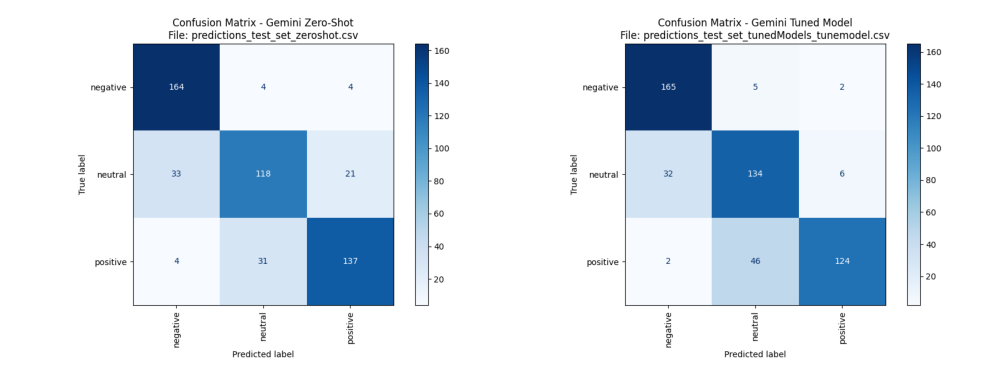

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
from PIL import Image

# 圖片檔案路徑（假設你已經上傳）
path1 = '/content/drive/MyDrive/Financial-Sentiment/Results_Gemini_ZeroShot/gemini_zeroshot_confusion_matrix.png'
path2 = '/content/drive/MyDrive/Financial-Sentiment/Results_Gemini_TunedModel/gemini_tuned_model_confusion_matrix.png'

# 讀取圖片
img1 = Image.open(path1)
img2 = Image.open(path2)

# 建立子圖畫布（1列2欄）
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img1)
#axs[0].set_title('圖一')
axs[0].axis('off')

axs[1].imshow(img2)
#axs[1].set_title('圖二')
axs[1].axis('off')

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


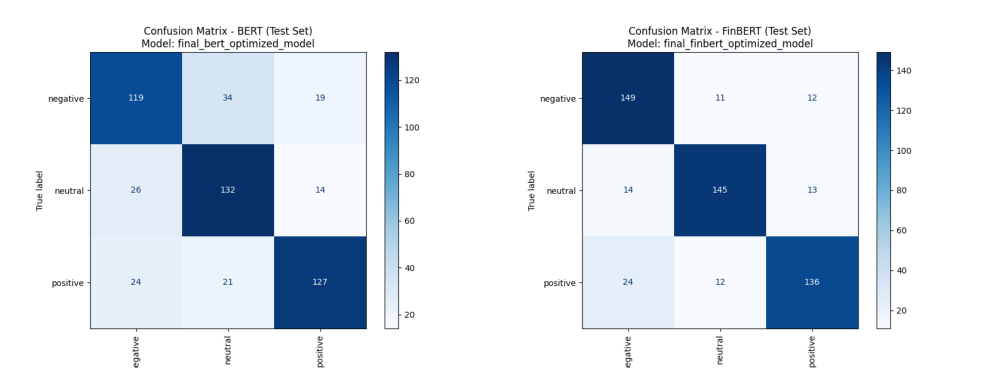

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
from PIL import Image

# 圖片檔案路徑（假設你已經上傳）
path1 = '/content/drive/MyDrive/Financial-Sentiment/OptimizationResults_BERT_CM/bert_test_confusion_matrix.png'
path2 = '/content/drive/MyDrive/Financial-Sentiment/OptimizationResults_FinBERT_CM/finbert_test_confusion_matrix_dropout_updated.png'

# 讀取圖片
img1 = Image.open(path1)
img2 = Image.open(path2)

# 建立子圖畫布（1列2欄）
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img1)
#axs[0].set_title('圖一')
axs[0].axis('off')

axs[1].imshow(img2)
#axs[1].set_title('圖二')
axs[1].axis('off')

plt.tight_layout()
plt.show()

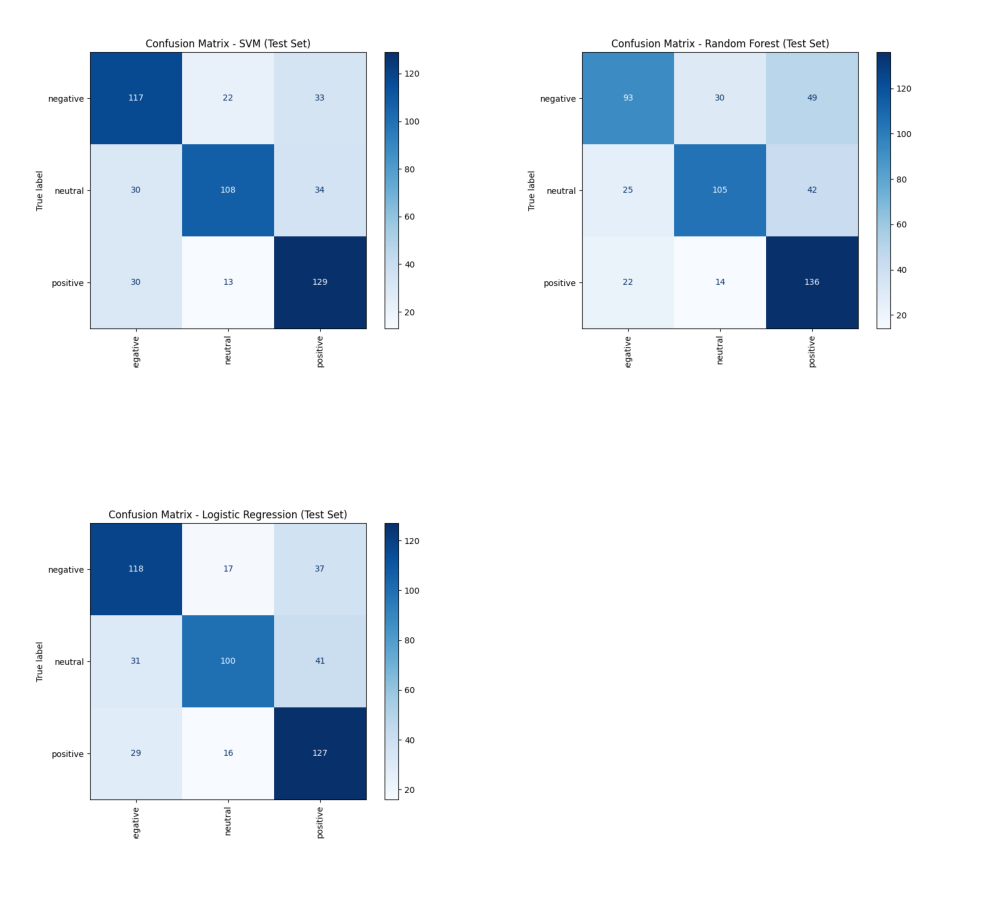

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# 圖片檔案路徑（假設你已經上傳）
path1 = '/content/drive/MyDrive/Financial-Sentiment/Results_SVM_ConfusionMatrix/svm_confusion_matrix.png'
path2 = '/content/drive/MyDrive/Financial-Sentiment/Results_RF_ConfusionMatrix/rf_confusion_matrix.png'
path3 = '/content/drive/MyDrive/Financial-Sentiment/Results_LogReg_ConfusionMatrix/logreg_confusion_matrix.png'

# 讀取圖片
img1 = Image.open(path1)
img2 = Image.open(path2)
img3 = Image.open(path3)

# 建立子圖畫布（2列2欄）
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(img1)
#axs[0].set_title('圖一')
axs[0, 0].axis('off')

axs[0, 1].imshow(img2)
#axs[1].set_title('圖二')
axs[0, 1].axis('off')

axs[1, 0].imshow(img3)
#axs[2].set_title('圖三')
axs[1, 0].axis('off')

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()